# Energy Analysis
We will be using the new energy layer to analyze the following future PV options
- modules..

We will use a literture-sourced global scale deployment schedule through 2050, then assume that capacity increases at a lower constant rate through 2100.

In [1]:
import numpy as np
import pandas as pd
import os,sys
from pathlib import Path
import matplotlib.pyplot as plt

cwd = os.getcwd() #grabs current working directory

testfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP' / 'EnergyAnalysis')
inputfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP')
baselinesfolder = str(Path().resolve().parent.parent /'PV_ICE' / 'baselines')
supportMatfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'baselines' / 'SupportingMaterial')
altBaselinesfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'baselines' / 'Energy_CellModuleTechCompare')

if not os.path.exists(testfolder):
    os.makedirs(testfolder)

In [2]:
from platform import python_version 
print(python_version())

3.8.8


Graphing settings

In [3]:
#https://www.learnui.design/tools/data-color-picker.html#palette
#color pallette - modify here for all graphs below
colorpalette=['#000000', #PV ICE baseline
              '#0079C1','#7030A0','#F6A01A', #extreme cases (3) long life, high eff, circular
                '#41B8FF','#EF5675','#FFC425', #hypothetical modules (3) 50 yr, recycleSi, perovskite
                '#067872','#0aa39e','#09d0cd','#00ffff'] #realistic cases (4) teals, perc, shj, topcon, irena

colormats = ['#00bfbf','#ff7f0e','#1f77be','#2ca02c','#d62728','#9467BD','#8C564B'] #colors for material plots       

import matplotlib as mpl #import matplotlib
from cycler import cycler #import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=colorpalette) #reset the default color palette of mpl

plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (8, 6)

scennames_labels = ['PV_ICE','Extreme\nLong-Lived','Extreme\nHigh Eff','Extreme\nCircular',
                    'Ambitious\n50-year\nPERC','Ambitious\nRecycled Si','Ambitious\nCircular\nPerovskite',
                    'PERC','SHJ','TOPCon','IRENA\nreg. loss'] 

scennames_labels_flat = ['PV_ICE','Extreme Long-Lived','Extreme High Eff','Extreme Circular',
                    'Ambitious 50-year PERC','Ambitious Recycled Si','Ambitious Circular Perovskite',
                    'PERC','SHJ','TOPCon','IRENA reg. loss'] 
#,'Lightweight'

Scenarios and materials

In [4]:
#creating scenarios for identical power of multiple technologies, moved to below due to reordering
scennames_ex = ['PV_ICE', 'ex_PERC_50', 'ex_High_eff', 'ex_Perovskite'] #extreme boundaries
scennames_r = ['PV_ICE','r_PERC', 'r_SHJ', 'r_TOPCon', 'r_IRENA'] #realistic cases
scennames_hyp = ['PV_ICE', 'h_50PERC','h_RecycledPERC', 'h_Perovskite'] #hypothetical modules



In [5]:
MATERIALS = ['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet']
moduleFile_m = os.path.join(baselinesfolder, 'baseline_modules_mass_US.csv')
moduleFile_e = os.path.join(baselinesfolder, 'baseline_modules_energy.csv')

We will be deploying based on power (not area) because each of these have different efficiencies, and those differences should be accounted for in the simulation. Additionally, we will run the installation compensation to simulate the required replacements for each module type.

In [6]:
import PV_ICE
PV_ICE.__version__


'v0.2.0+449.g6485773.dirty'

In [7]:
#load in a baseline and materials for modification
sim1 = PV_ICE.Simulation(name='sim1', path=testfolder)
for scen in scennames_ex:
    sim1.createScenario(name=scen, massmodulefile=moduleFile_m, energymodulefile=moduleFile_e)
    for mat in range (0, len(MATERIALS)):
        matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+MATERIALS[mat]+'.csv')
        matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+MATERIALS[mat]+'.csv')
        sim1.scenario[scen].addMaterial(MATERIALS[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

path = C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP\EnergyAnalysis


In [8]:
sim1.scenario.keys()

dict_keys(['PV_ICE', 'ex_PERC_50', 'ex_High_eff', 'ex_Perovskite'])

# 1. Module & Scenario Creation
Starting modifications in 2022, using PV ICE baseline as historical for all modules

**NOTE: Currently have to modify all scenarios before extending the years to avoid errors.**

**NOTE: all dynamic values changed with PV ICE modify functions must feed in a Pandas Series**

In [9]:
celltech_modeff = pd.read_csv(os.path.join(supportMatfolder, 'output-celltech-modeffimprovements.csv'),index_col=0) #pull in module eff
celltech_aguse = pd.read_csv(os.path.join(supportMatfolder, 'output-celltech-Agusageimprovements.csv'),index_col=0) #pull in Ag use

In [10]:
celltech_modeff.loc[2020]

PERC      22.8
SHJ       23.5
TOPCon    23.2
Name: 2020, dtype: float64

In [11]:
#glass-glass package mass per area calculation
#ITRPV 2022 Figs 36 and 38, we are assuming that the front and back glass heave equal thickness of 2.5mm
density_glass = 2500*1000 # g/m^3 
glassperm2 = (2.5/1000)* 2 * density_glass
print('The mass per module area of glass is '+str(glassperm2)+' g/m^2 for all modules with a glass-glass package')

The mass per module area of glass is 12500.0 g/m^2 for all modules with a glass-glass package


In [12]:
timeshift = 2022-1995

## 1.1 Extreme modules

### 1.1.1 Ideal Lifetime - 50 year module
This module represents current PERC technology (so good efficiency) if it were to have it's lifetime extended significantly. Glass-glass technology is assumed, expected decreases in silver usage and increases in module efficiency are derived from Zhang et al 2021, Gervais et al 2021 and ITRPV 2022. It is assumed that this module is no more recyclable than current technology (downcycle glass and recycle aluminium frames).

In [13]:
#module efficiency modify for PERC
sim1.modifyScenario('ex_PERC_50', 'mod_eff', 24.5, start_year=2022) #PERC 2030 module eff

In [14]:
#silver modify for PERC
sim1.scenario['ex_PERC_50'].modifyMaterials('silver', 'mat_massperm2', celltech_aguse.loc[2022:,'PERC'], start_year=2022)
#old way
#sim1.scenario['PERC_50'].material['silver'].matdataIn_m.loc[timeshift:,'mat_massperm2'] = celltech_aguse.loc[2022:,'PERC'].values

In [15]:
#modify package to glass glass
sim1.scenario['ex_PERC_50'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022) #
sim1.scenario['ex_PERC_50'].modifyMaterials('backsheet', 'mat_massperm2', 0.0, start_year=2022) #

In [16]:
#Lifetime and Degradation
#degradation rate from Theristis et al 2022
#failure is T10 at 50 years
#degradation rate:
sim1.modifyScenario('ex_PERC_50', 'mod_degradation', 0.4, start_year=2022) #annual power degradation to reach 80% at 55 yrs
#T50
sim1.modifyScenario('ex_PERC_50', 'mod_reliability_t50', 56.07, start_year=2022)
#t90
sim1.modifyScenario('ex_PERC_50', 'mod_reliability_t90', 59.15, start_year=2022) 
#Mod Project Lifetime
sim1.modifyScenario('ex_PERC_50', 'mod_lifetime', 50, start_year=2022) #project lifetime of 50 years


In [17]:
#Merchant Tail set high
sim1.modifyScenario('ex_PERC_50', 'mod_MerchantTail', 100, start_year=2022) #all installations stay for merchant tail
#Change recycling?

### 1.1.2 Ideal High Efficiency
This represents a 25 year lifetime module where efficiency has been prioritized. This could represent a silicon based tandem, along the lines of SHJ 

In [18]:
#idx_temp = pd.RangeIndex(start=2022,stop=2051,step=1) #create the index
#df_higheff = pd.DataFrame(index=idx_temp, columns=['mod_eff_p'], dtype=float)
#df_higheff.loc[2022] = 22.0
#df_higheff.loc[2030] = 25.0
#df_higheff.loc[2050] = 30.0
#df_higheff.interpolate(inplace=True)
#module efficiency modify for PERC
sim1.modifyScenario('ex_High_eff', 'mod_eff', 30.0, start_year=2022) #changing module eff

In [19]:
#Lifetime and Degradation
#degradation rate:
sim1.modifyScenario('ex_High_eff', 'mod_degradation', 0.7, start_year=2022) #standard current degrdation
#T50
sim1.modifyScenario('ex_High_eff', 'mod_reliability_t50', 30.7, start_year=2022)
#t90
sim1.modifyScenario('ex_High_eff', 'mod_reliability_t90', 35, start_year=2022) 
#Mod Project Lifetime
sim1.modifyScenario('ex_High_eff', 'mod_lifetime', 25, start_year=2022) #project lifetime of 25 years

In [20]:
#modify package to glass glass
sim1.scenario['ex_High_eff'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022)
sim1.scenario['ex_High_eff'].modifyMaterials('backsheet', 'mat_massperm2', 0.0, start_year=2022) #

### 1.1.3 Ideal Circular - Tandem Perovskite
This perovskite module uses current best module and cell efficiencies, has a prospective life of 15 years and 1.5% degradation rate, and is highly circular. This is a best case scenario for perovskites given current data.

#2022 module eff = 17.9% #https://www.nrel.gov/pv/assets/pdfs/champion-module-efficiencies-rev220401b.pdf
#2050 module eff = 27.3% # Sofia et al 2019 4T future
idx_perovskite_eff = pd.RangeIndex(start=2022,stop=2051,step=1) #create the index
df_perovskite_eff = pd.DataFrame(index=idx_perovskite_eff, columns=['mod_eff_p'], dtype=float)
df_perovskite_eff.loc[2022] = 17.9
df_perovskite_eff.loc[2030] = 27.3
df_perovskite_eff.loc[2050] = 27.3
df_perovskite_eff.interpolate(inplace=True)

In [21]:
#module efficiency modify for PERC
sim1.modifyScenario('ex_Perovskite', 'mod_eff', 27.3, start_year=2022) #changing module eff

In [22]:
#modify package to glass glass
sim1.scenario['ex_Perovskite'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022)
sim1.scenario['ex_Perovskite'].modifyMaterials('backsheet', 'mat_massperm2', 0.0, start_year=2022) #

In [23]:
#Lifetime and Degradation
#values taken from lifetime vs recycling paper
#degradation rate:
sim1.modifyScenario('ex_Perovskite', 'mod_degradation', 1.47, start_year=2022) #annual power degradation
#Mod Project Lifetime
sim1.modifyScenario('ex_Perovskite', 'mod_lifetime', 15, start_year=2022) #project lifetime of 15 years
#T50
sim1.modifyScenario('ex_Perovskite', 'mod_reliability_t50', 19, start_year=2022)
#t90
sim1.modifyScenario('ex_Perovskite', 'mod_reliability_t90', 22, start_year=2022) 

In [24]:
#As Circular as possible
#100% collection rate
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_collection_eff', 100.0, start_year=2022) #100% collection
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_pg1_landfill', 0.0, start_year=2022) #100% collection
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_pb1_landfill', 0.0, start_year=2022) #100% collection

# remanufacturing
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_pg3_reMFG', 100.0, start_year=2022) #all modules attempt remfg
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_sp_reMFG_recycle', 100.0, start_year=2022) # recycle if can't remfg
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_pb3_reMFG', 100.0, start_year=2022) # remfg bad mods too
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_reMFG_yield', 98.0, start_year=2022) # REMFG YIELD 98%

#set all other paths to 0
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_pg0_resell', 0.0, start_year=2022) # 
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_pg1_landfill', 0.0, start_year=2022) # 
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_pg2_stored', 0.0, start_year=2022) #
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_pg4_recycled', 0.0, start_year=2022) # 
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_pb1_landfill', 0.0, start_year=2022) # 
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_pb2_stored', 0.0, start_year=2022) # 
sim1.modifyScenario('ex_Perovskite', 'mod_EOL_pb4_recycled', 0.0, start_year=2022) # 
sim1.modifyScenario('ex_Perovskite', 'mod_Repair', 0.0, start_year=2022) #
sim1.modifyScenario('ex_Perovskite', 'mod_MerchantTail', 0.0, start_year=2022) #


#Material Remanufacture
#Glass
#mfg scrap
sim1.scenario['ex_Perovskite'].modifyMaterials('glass', 'mat_MFG_scrap_Recycled', 100.0, start_year=2022) #send mfg scrap to recycle
sim1.scenario['ex_Perovskite'].modifyMaterials('glass', 'mat_MFG_scrap_Recycling_eff', 98.0, start_year=2022) #99% yield
sim1.scenario['ex_Perovskite'].modifyMaterials('glass', 'mat_MFG_scrap_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['ex_Perovskite'].modifyMaterials('glass', 'mat_MFG_scrap_Recycled_into_HQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
#eol
sim1.scenario['ex_Perovskite'].modifyMaterials('glass', 'mat_PG3_ReMFG_target', 100.0, start_year=2022) #send all to remfg
sim1.scenario['ex_Perovskite'].modifyMaterials('glass', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #send none to recycle
sim1.scenario['ex_Perovskite'].modifyMaterials('glass', 'mat_ReMFG_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['ex_Perovskite'].modifyMaterials('glass', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild


#silicon ReMFG 
#mfg scrap
sim1.scenario['ex_Perovskite'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled', 100.0, start_year=2022) #send mfg scrap to recycle
sim1.scenario['ex_Perovskite'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycling_eff', 98.0, start_year=2022) #98% yield
sim1.scenario['ex_Perovskite'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['ex_Perovskite'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled_into_HQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
#eol
sim1.scenario['ex_Perovskite'].modifyMaterials('silicon', 'mat_PG3_ReMFG_target', 100.0, start_year=2022) #send to remfg
sim1.scenario['ex_Perovskite'].modifyMaterials('silicon', 'mat_ReMFG_yield', 98.0, start_year=2022) #98% yeild
sim1.scenario['ex_Perovskite'].modifyMaterials('silicon', 'mat_PG4_Recycling_target', 0.0, start_year=2022) #send to remfg
sim1.scenario['ex_Perovskite'].modifyMaterials('silicon', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['ex_Perovskite'].modifyMaterials('silicon', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['ex_Perovskite'].modifyMaterials('silicon', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop


#aluminium_frames recycle
#mfg scrap
sim1.scenario['ex_Perovskite'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycled', 100.0, start_year=2022) #send mfg scrap to recycle
sim1.scenario['ex_Perovskite'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycling_eff', 98.0, start_year=2022) #98% yield
sim1.scenario['ex_Perovskite'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['ex_Perovskite'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycled_into_HQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
#eol
sim1.scenario['ex_Perovskite'].modifyMaterials('aluminium_frames', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['ex_Perovskite'].modifyMaterials('aluminium_frames', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #send to recycle
sim1.scenario['ex_Perovskite'].modifyMaterials('aluminium_frames', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['ex_Perovskite'].modifyMaterials('aluminium_frames', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['ex_Perovskite'].modifyMaterials('aluminium_frames', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
sim1.scenario['ex_Perovskite'].modifyMaterials('aluminium_frames', 'mat_ReMFG_yield', 0.0, start_year=2022) #0% yeild


### Lightweighting
- 10% Si
- 50% encapsulant
- 2mm glass
- frameless
- possibly reduced reliability

Could represent a thin film. This does work, it looks very good on Energy basis, however, we need a more realistic existing module to include this further, with more realistic energy demands (e.g.; CdTe).

In [25]:
#module efficiency modify for PERC
#sim1.modifyScenario('ex_Lightweight', 'mod_eff', celltech_modeff.loc[2022:,'PERC'], start_year=2022) #changing module eff

In [26]:
#2mm glass calculation
#lightweightglass = (2.0/1000)* 1 * density_glass

#50% encapsulant
#light_encap = pd.Series(sim1.scenario['PV_ICE'].material['encapsulant'].matdataIn_m.loc[timeshift:,'mat_massperm2']*0.5)

#10% silicon
#light_Si = pd.Series(sim1.scenario['PV_ICE'].material['silicon'].matdataIn_m.loc[timeshift:,'mat_massperm2']*0.1)

#modify BOM
#sim1.scenario['ex_Lightweight'].modifyMaterials('glass', 'mat_massperm2', lightweightglass, start_year=2022) #glass
#sim1.scenario['ex_Lightweight'].modifyMaterials('aluminium_frames', 'mat_massperm2', 0.0, start_year=2022) #frameless
#sim1.scenario['ex_Lightweight'].modifyMaterials('encapsulant', 'mat_massperm2', light_encap, start_year=2022) #50% encapsulant
#sim1.scenario['ex_Lightweight'].modifyMaterials('silicon', 'mat_massperm2', light_Si, start_year=2022) #10% silicon


In [27]:
#Lifetime and Degradation
#values taken from lifetime vs recycling paper
#degradation rate:
#sim1.modifyScenario('ex_Lightweight', 'mod_degradation', 0.7, start_year=2022) #annual power degradation
#Mod Project Lifetime
#sim1.modifyScenario('ex_Lightweight', 'mod_lifetime', 25, start_year=2022) #project lifetime of 15 years
#T50
#sim1.modifyScenario('ex_Lightweight', 'mod_reliability_t50', 29, start_year=2022) #this will get changed with IRENA alpha/b
#t90
#sim1.modifyScenario('ex_Lightweight', 'mod_reliability_t90', 32, start_year=2022) #this will get changed with IRENA alpha/b

In [28]:
#len(sim1.scenario['ex_Lightweight'].material['silicon'].matdataIn_m)

## 1.2 Hypothetical Modules

These are modules which have a basis in laboratory or field but have not yet been fully/completely demonstrated or commercialized. These are:
- 50 year PERC module; this is the closest to an existing module, but we don't yet have 50 years worth of data to assert that this exists yet.
- Recycled Silicon PERC; this was a demonstration from Fraunhofer to recycle a silicon cell by skipping the mg-Si step, which has energy and carbon implications
- Circular Perovskite Tandem; cells have been demonstrated in the lab to deposit a perovskite on top of a silicon cell which is removable and remanufacturable, i.e. the silicon wafer doesn't get melted or reprocessed beyond cleaning and a new module is made.

### 1.2.1 PERC gradual improvement to 50 year lifetime

In [29]:
#modified module
moduleinput_m_r_50PERC = os.path.join(altBaselinesfolder, 'mod_r_50PERC.csv')
sim1.createScenario(name='h_50PERC', massmodulefile=moduleinput_m_r_50PERC, energymodulefile=moduleFile_e) 

#load standard materials
for mat in range (0, len(MATERIALS)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+MATERIALS[mat]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+MATERIALS[mat]+'.csv')
    sim1.scenario['h_50PERC'].addMaterial(MATERIALS[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [ ]:
#modify package to glass glass
sim1.scenario['h_50PERC'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022)
sim1.scenario['h_50PERC'].modifyMaterials('backsheet', 'mat_massperm2', 0.0, start_year=2022) #

In [30]:
#glass recycling
#create improvement series
idx_temp = pd.RangeIndex(start=2022,stop=2051,step=1) #create the index
df_glass_target = pd.DataFrame(index=idx_temp, columns=['mat_PG4_Recycling_target'], dtype=float)
df_glass_target.loc[2022] = 0
df_glass_target.loc[2030] = 100
df_glass_target.loc[2050] = 100
df_glass_target.interpolate(inplace=True)

df_glass_lowrecycle = pd.DataFrame(index=idx_temp, columns=['mat_EOL_Recycled_into_HQ'], dtype=float)
df_glass_lowrecycle.loc[2022] = 0
df_glass_lowrecycle.loc[2030] = 0
df_glass_lowrecycle.loc[2050] = 50
df_glass_lowrecycle.interpolate(inplace=True)

#eol
sim1.scenario['h_50PERC'].modifyMaterials('glass', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['h_50PERC'].modifyMaterials('glass', 'mat_PG4_Recycling_target', 
                                          df_glass_target.loc[2022:,'mat_PG4_Recycling_target'], start_year=2022) #send to recycle

sim1.scenario['h_50PERC'].modifyMaterials('glass', 'mat_EOL_Recycled_into_HQ', 
                                          df_glass_lowrecycle.loc[2022:,'mat_EOL_Recycled_into_HQ'], start_year=2022) #all HQ
sim1.scenario['h_50PERC'].modifyMaterials('glass', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop


In [31]:
#silicon recycled
#create improvement series
idx_temp = pd.RangeIndex(start=2022,stop=2051,step=1) #create the index
df_si_target = pd.DataFrame(index=idx_temp, columns=['mat_PG4_Recycling_target'], dtype=float)
df_si_target.loc[2022] = 0
df_si_target.loc[2030] = 0
df_si_target.loc[2050] = 50
df_si_target.interpolate(inplace=True)

#eol
sim1.scenario['h_50PERC'].modifyMaterials('silicon', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['h_50PERC'].modifyMaterials('silicon', 'mat_PG4_Recycling_target', 
                                          df_si_target.loc[2022:,'mat_PG4_Recycling_target'], start_year=2022) #send to recycle

sim1.scenario['h_50PERC'].modifyMaterials('silicon', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['h_50PERC'].modifyMaterials('silicon', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop



In [32]:
#aluminium_frames recycle
idx_temp = pd.RangeIndex(start=2022,stop=2051,step=1) #create the index
df_al_target = pd.DataFrame(index=idx_temp, columns=['mat_PG4_Recycling_target'], dtype=float)
df_al_target.loc[2022] = 0
df_al_target.loc[2030] = 100
df_al_target.loc[2050] = 100
df_al_target.interpolate(inplace=True)

df_al_lowrecycle = pd.DataFrame(index=idx_temp, columns=['mat_EOL_Recycled_into_HQ'], dtype=float)
df_al_lowrecycle.loc[2022] = 0
df_al_lowrecycle.loc[2030] = 100
df_al_lowrecycle.loc[2050] = 100
df_al_lowrecycle.interpolate(inplace=True)

df_al_lowCL = pd.DataFrame(index=idx_temp, columns=['mat_EOL_RecycledHQ_Reused4MFG'], dtype=float)
df_al_lowCL.loc[2022] = 0
df_al_lowCL.loc[2030] = 20
df_al_lowCL.loc[2050] = 50
df_al_lowCL.interpolate(inplace=True)

#eol
sim1.scenario['h_50PERC'].modifyMaterials('aluminium_frames', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['h_50PERC'].modifyMaterials('aluminium_frames', 'mat_PG4_Recycling_target', 
                                          df_al_target.loc[2022:,'mat_PG4_Recycling_target'], start_year=2022) #send to recycle
sim1.scenario['h_50PERC'].modifyMaterials('aluminium_frames', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['h_50PERC'].modifyMaterials('aluminium_frames', 'mat_EOL_Recycled_into_HQ', 
                                          df_al_lowrecycle.loc[2022:,'mat_EOL_Recycled_into_HQ'], start_year=2022) #all HQ
sim1.scenario['h_50PERC'].modifyMaterials('aluminium_frames', 'mat_EOL_RecycledHQ_Reused4MFG', 
                                          df_al_lowCL.loc[2022:,'mat_EOL_RecycledHQ_Reused4MFG'], start_year=2022) #closed-loop


### 1.2.2 Recycled Silicon PERC
This module is based on the recent test from Fraunhofer ISE in which an old module was dissassembled, and the silicon wafer cleaned, put into a Cz ingot growth process and made using standard PERC processing, creating a 19% efficient module.
https://www.ise.fraunhofer.de/en/press-media/press-releases/2022/solar-cells-from-recycled-silicon.html

In [33]:
#modified module
moduleinput_m_r_RecyclePERC = os.path.join(altBaselinesfolder, 'mod_r_PERCrecycleSi.csv')
sim1.createScenario(name='h_RecycledPERC', massmodulefile=moduleinput_m_r_RecyclePERC, energymodulefile=moduleFile_e) 

for mat in range (0, len(MATERIALS)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+MATERIALS[mat]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+MATERIALS[mat]+'.csv')
    sim1.scenario['h_RecycledPERC'].addMaterial(MATERIALS[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [34]:
#glass recycling
#eol
sim1.scenario['h_RecycledPERC'].modifyMaterials('glass', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['h_RecycledPERC'].modifyMaterials('glass', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #send to recycle
#sim1.scenario['h_RecycledPERC'].modifyMaterials('glass', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['h_RecycledPERC'].modifyMaterials('glass', 'mat_EOL_Recycled_into_HQ', 0.0, start_year=2022) #all HQ
sim1.scenario['h_RecycledPERC'].modifyMaterials('glass', 'mat_EOL_RecycledHQ_Reused4MFG', 0.0, start_year=2022) #closed-loop

#silicon recycled
#mfg scrap
sim1.scenario['h_RecycledPERC'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled', 100.0, start_year=2022) #send mfg scrap to recycle
sim1.scenario['h_RecycledPERC'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycling_eff', 98.0, start_year=2022) #98% yield
sim1.scenario['h_RecycledPERC'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['h_RecycledPERC'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled_into_HQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
#eol
sim1.scenario['h_RecycledPERC'].modifyMaterials('silicon', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['h_RecycledPERC'].modifyMaterials('silicon', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #send to recycle
sim1.scenario['h_RecycledPERC'].modifyMaterials('silicon', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['h_RecycledPERC'].modifyMaterials('silicon', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['h_RecycledPERC'].modifyMaterials('silicon', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop

#aluminium_frames recycle
#mfg scrap
sim1.scenario['h_RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycled', 100.0, start_year=2022) #send mfg scrap to recycle
sim1.scenario['h_RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycling_eff', 98.0, start_year=2022) #98% yield
sim1.scenario['h_RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['h_RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycled_into_HQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
#eol
sim1.scenario['h_RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['h_RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #send to recycle
sim1.scenario['h_RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['h_RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['h_RecycledPERC'].modifyMaterials('aluminium_frames', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop

#silver recycling improvement
#create improvement series
idx_temp = pd.RangeIndex(start=2022,stop=2051,step=1) #create the index
df_silver_recycleimprove = pd.DataFrame(index=idx_temp, columns=['mat_PG4_Recycling_target'], dtype=float)
df_silver_recycleimprove.loc[2022] = 0
df_silver_recycleimprove.loc[2030] = 40
df_silver_recycleimprove.loc[2050] = 100
df_silver_recycleimprove.interpolate(inplace=True)

#eol
sim1.scenario['h_RecycledPERC'].modifyMaterials('silver', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['h_RecycledPERC'].modifyMaterials('silver', 'mat_PG4_Recycling_target',
                                        df_silver_recycleimprove.loc[2022:,'mat_PG4_Recycling_target'], start_year=2022) 
sim1.scenario['h_RecycledPERC'].modifyMaterials('silver', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['h_RecycledPERC'].modifyMaterials('silver', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['h_RecycledPERC'].modifyMaterials('silver', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop


In [35]:
#the cool feature of this module was that the wafer was directly put into the Cz process
#therefore, we need to modify the recycling energy to reflect this
#this energy profile is output by the (baseline development) Energy Silicon Manufacturing journal.
altHQRecycle_e = pd.read_csv(os.path.join(supportMatfolder, 'output_energy_silicon_eol_recycleHQ_ALT.csv'), index_col=0)
altHQRecycle_e

E_MFG_kWhpkg  E_mfgFuelFraction
1995    600.817735           0.064489
1996    527.042434           0.072326
1997    485.167804           0.077357
1998    432.693843           0.085473
1999    380.620553           0.095834
2000    269.697933           0.075408
2001    236.759317           0.066235
2002    204.221370           0.054188
2003    172.084094           0.037719
2004    159.669155           0.030097
2005    140.254886           0.022532
2006    130.586287           0.022463
2007    121.318358           0.022639
2008    112.451100           0.023120
2009    103.984511           0.023976
2010     95.918593           0.025298
2011     88.253345           0.027195
2012     88.388767           0.027307
2013     88.924859           0.027745
2014     89.861622           0.028498
2015     91.199054           0.029547
2016     76.337157           0.037576
2017     61.875930           0.049814
2018     62.915373           0.053028
2019     64.355487           0.056410
2020     74.096270           0.053503
2021     77.837724           0.055738
2022     77.837724           0.055738
2023     77.837724           0.055738
2024     77.837724           0.055738
2025     77.837724           0.055738
2026     77.837724           0.055738
2027     77.837724           0.055738
2028     77.837724           0.055738
2029     77.837724           0.055738
2030     77.837724           0.055738
2031     77.837724           0.055738
2032     77.837724           0.055738
2033     77.837724           0.055738
2034     77.837724           0.055738
2035     77.837724           0.055738
2036     77.837724           0.055738
2037     77.837724           0.055738
2038     77.837724           0.055738
2039     77.837724           0.055738
2040     77.837724           0.055738
2041     77.837724           0.055738
2042     77.837724           0.055738
2043     77.837724           0.055738
2044     77.837724           0.055738
2045     77.837724           0.055738
2046     77.837724           0.055738
2047     77.837724           0.055738
2048     77.837724           0.055738
2049     77.837724           0.055738
2050     77.837724           0.055738

In [36]:
#modify silicon recycling energy
sim1.scenario['h_RecycledPERC'].modifyMaterialEnergy('silicon', 'e_mat_Recycled_HQ', altHQRecycle_e.loc[2022:,'E_MFG_kWhpkg'], start_year=2022)
sim1.scenario['h_RecycledPERC'].modifyMaterialEnergy('silicon', 'e_mat_Recycled_HQ_fuelfraction', altHQRecycle_e.loc[2022:,'E_mfgFuelFraction'], start_year=2022)


In [37]:
sim1.scenario['h_RecycledPERC'].material['silicon'].matdataIn_e.iloc[25:30,]

year  e_mat_extraction  e_mat_MFG  e_mat_MFG_fuelfraction  \
25  2020            0.0062     169.06                    0.22   
26  2021            0.0062     170.73                    0.21   
27  2022            0.0062     169.05                    0.20   
28  2023            0.0062     168.80                    0.20   
29  2024            0.0062     169.09                    0.20   

    e_mat_MFGScrap_LQ  e_mat_MFGScrap_HQ  e_mat_Landfill  \
25               24.5              600.0            0.09   
26               24.5              600.0            0.09   
27               24.5              600.0            0.09   
28               24.5              600.0            0.09   
29               24.5              600.0            0.09   

    e_mat_Landfill_fuelfraction  e_mat_EoL_ReMFG_clean  e_mat_Recycled_LQ  \
25                          0.0                    0.4                1.6   
26                          0.0                    0.4                1.6   
27                          0.0                    0.4                1.6   
28                          0.0                    0.4                1.6   
29                          0.0                    0.4                1.6   

    e_mat_Recycled_HQ  e_mat_Recycled_HQ_fuelfraction  
25         138.380000                        0.200000  
26         143.040000                        0.190000  
27          77.837724                        0.055738  
28          77.837724                        0.055738  
29          77.837724                        0.055738

### 1.2.3 Hopeful Perovskite

In [38]:
#modified module
moduleinput_m_r_perovskite = os.path.join(altBaselinesfolder, 'mod_r_perovskite.csv')
sim1.createScenario(name='h_Perovskite', massmodulefile=moduleinput_m_r_perovskite, energymodulefile=moduleFile_e) 

#modified materials
#glass
matinput_glass_m_remfg = os.path.join(altBaselinesfolder,'material_mass_glass_r_perovskite.csv')
matbaseline_e_glass = os.path.join(baselinesfolder,'baseline_material_energy_glass.csv')
sim1.scenario['h_Perovskite'].addMaterial('glass', massmatfile=matinput_glass_m_remfg, energymatfile=matbaseline_e_glass)

#silicon
matinput_silicon_m_remfg = os.path.join(altBaselinesfolder,'material_mass_silicon_r_perovskite.csv')
matbaseline_e_si = os.path.join(baselinesfolder,'baseline_material_energy_silicon.csv')
sim1.scenario['h_Perovskite'].addMaterial('silicon', massmatfile=matinput_silicon_m_remfg, energymatfile=matbaseline_e_si)

#load standard materials
subMats =['silver', 'aluminium_frames','copper','encapsulant', 'backsheet']
for mat in range (0, len(subMats)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+subMats[mat]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+subMats[mat]+'.csv')
    sim1.scenario['h_Perovskite'].addMaterial(subMats[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [ ]:
sim1.scenario['h_Perovskite'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022)
sim1.scenario['h_Perovskite'].modifyMaterials('backsheet', 'mat_massperm2', 0.0, start_year=2022) #

In [39]:
#aluminium_frames recycle
#eol
sim1.scenario['h_Perovskite'].modifyMaterials('aluminium_frames', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['h_Perovskite'].modifyMaterials('aluminium_frames', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #send to recycle
sim1.scenario['h_Perovskite'].modifyMaterials('aluminium_frames', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['h_Perovskite'].modifyMaterials('aluminium_frames', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['h_Perovskite'].modifyMaterials('aluminium_frames', 'mat_EOL_RecycledHQ_Reused4MFG',100.0, start_year=2022) #closed-loop


## 1.3 Commercialized Modules with Expected Continued Improvement

For these more realisitic evolving modules, some module and material input files have been modified and are stored in the baselines\Energy_CellModuleTechCompare folder.

In [40]:
altBaselinesfolder

'C:\\Users\\hmirletz\\Documents\\GitHub\\PV_ICE\\PV_ICE\\baselines\\Energy_CellModuleTechCompare'

Improving recycling:
- 2022: 15% collection, 75% recycled module, 100% downcycled glass, 100% HQ al frames, 20% closed loop
- 2030: 30% collection, 80% recycled module, 30% closed-loop glass, 30% closed-loop silicon, 30% closed-loop silver, 50% closed loop Al frames
- 2050: 75% collection, 95% recycled module, 75% closed loop recycled glass, 75% closed loop recycled silicon, 75% closed-loop silver, 100% closed loop al frames

### 1.3.1 PERC

In [41]:
#modified module
moduleinput_m_r_PERC = os.path.join(altBaselinesfolder, 'mod_r_PERC.csv')
sim1.createScenario(name='r_PERC', massmodulefile=moduleinput_m_r_PERC, energymodulefile=moduleFile_e) 

In [42]:
#module efficiency modify for PERC
sim1.modifyScenario('r_PERC', 'mod_eff', celltech_modeff.loc[2022:,'PERC'], start_year=2022) #changing module eff
#sim1.scenario['SHJ'].dataIn_m.loc[timeshift:,'mod_eff'] = celltech_modeff.loc[2022:,'SHJ'].values

In [43]:
#modified materials
#glass
matinput_glass_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_glass_improvedRecycle.csv')
matbaseline_e_glass = os.path.join(baselinesfolder,'baseline_material_energy_glass.csv')
sim1.scenario['r_PERC'].addMaterial('glass', massmatfile=matinput_glass_m_improvedRecycle, energymatfile=matbaseline_e_glass)
#silicon
matinput_silicon_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silicon_improvedRecycle.csv')
matbaseline_e_si = os.path.join(baselinesfolder,'baseline_material_energy_silicon.csv')
sim1.scenario['r_PERC'].addMaterial('silicon', massmatfile=matinput_silicon_m_improvedRecycle, energymatfile=matbaseline_e_si)
#silver
matinput_silver_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silver_improvedRecycle.csv')
matbaseline_e_ag = os.path.join(baselinesfolder,'baseline_material_energy_silver.csv')
sim1.scenario['r_PERC'].addMaterial('silver', massmatfile=matinput_silver_m_improvedRecycle, energymatfile=matbaseline_e_ag)
#aluminium frames
matinput_Al_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_aluminium_frames_improvedRecycle.csv')
matbaseline_e_al = os.path.join(baselinesfolder,'baseline_material_energy_aluminium_frames.csv')
sim1.scenario['r_PERC'].addMaterial('aluminium_frames', massmatfile=matinput_Al_m_improvedRecycle, energymatfile=matbaseline_e_al)

#standard materials
baselineMats=['copper', 'encapsulant', 'backsheet']
for mats in range (0, len(baselineMats)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+baselineMats[mats]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+baselineMats[mats]+'.csv')
    sim1.scenario['r_PERC'].addMaterial(baselineMats[mats], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [44]:
#modify silver usage for PERC
sim1.scenario['r_PERC'].modifyMaterials('silver', 'mat_massperm2', celltech_aguse.loc[2022:,'PERC'], start_year=2022)

In [45]:
#modify package to glass glass
sim1.scenario['r_PERC'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022)
sim1.scenario['r_PERC'].modifyMaterials('backsheet', 'mat_massperm2', 0.0, start_year=2022) #

### 1.3.2 SHJ
This is a modern SHJ module with expected silver and module efficiency improvements taken from Zhang et al 2021, Gervais et al 2021, and ITPRV 2022. See PERC vs SHJ vs TOPCon for a more detailed evaluation.

In [46]:
#modified module
moduleinput_m_r_SHJ = os.path.join(altBaselinesfolder, 'mod_r_SHJ.csv')
sim1.createScenario(name='r_SHJ', massmodulefile=moduleinput_m_r_SHJ, energymodulefile=moduleFile_e) 

In [47]:
#module efficiency modify for SHJ
sim1.modifyScenario('r_SHJ', 'mod_eff', celltech_modeff.loc[2022:,'SHJ'], start_year=2022) #changing module eff
#sim1.scenario['SHJ'].dataIn_m.loc[timeshift:,'mod_eff'] = celltech_modeff.loc[2022:,'SHJ'].values

In [48]:
#load modified materials
#modified materials
#glass
matinput_glass_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_glass_improvedRecycle.csv')
matbaseline_e_glass = os.path.join(baselinesfolder,'baseline_material_energy_glass.csv')
sim1.scenario['r_SHJ'].addMaterial('glass', massmatfile=matinput_glass_m_improvedRecycle, energymatfile=matbaseline_e_glass)
#silicon
matinput_silicon_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silicon_improvedRecycle.csv')
matbaseline_e_si = os.path.join(baselinesfolder,'baseline_material_energy_silicon.csv')
sim1.scenario['r_SHJ'].addMaterial('silicon', massmatfile=matinput_silicon_m_improvedRecycle, energymatfile=matbaseline_e_si)
#silver
matinput_silver_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silver_improvedRecycle.csv')
matbaseline_e_ag = os.path.join(baselinesfolder,'baseline_material_energy_silver.csv')
sim1.scenario['r_SHJ'].addMaterial('silver', massmatfile=matinput_silver_m_improvedRecycle, energymatfile=matbaseline_e_ag)
#aluminium frames
matinput_Al_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_aluminium_frames_improvedRecycle.csv')
matbaseline_e_al = os.path.join(baselinesfolder,'baseline_material_energy_aluminium_frames.csv')
sim1.scenario['r_SHJ'].addMaterial('aluminium_frames', massmatfile=matinput_Al_m_improvedRecycle, energymatfile=matbaseline_e_al)

#standard materials
baselineMats=['copper', 'encapsulant', 'backsheet']
for mats in range (0, len(baselineMats)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+baselineMats[mats]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+baselineMats[mats]+'.csv')
    sim1.scenario['r_SHJ'].addMaterial(baselineMats[mats], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [49]:
#modify silver usage for SHJ
sim1.scenario['r_SHJ'].modifyMaterials('silver', 'mat_massperm2', celltech_aguse.loc[2022:,'SHJ'], start_year=2022)

In [50]:
#modify package to glass glass
sim1.scenario['r_SHJ'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022)
sim1.scenario['r_SHJ'].modifyMaterials('backsheet', 'mat_massperm2', 0.0, start_year=2022) #

### 1.3.3 TOPCon

In [51]:
#modified module
moduleinput_m_r_TOPCon = os.path.join(altBaselinesfolder, 'mod_r_TOPCon.csv')
sim1.createScenario(name='r_TOPCon', massmodulefile=moduleinput_m_r_TOPCon, energymodulefile=moduleFile_e) 

In [52]:
#module efficiency modify
sim1.modifyScenario('r_TOPCon', 'mod_eff', celltech_modeff.loc[2022:,'TOPCon'], start_year=2022) #changing module eff
#sim1.scenario['SHJ'].dataIn_m.loc[timeshift:,'mod_eff'] = celltech_modeff.loc[2022:,'SHJ'].values

In [53]:
#modified materials
#glass
matinput_glass_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_glass_improvedRecycle.csv')
matbaseline_e_glass = os.path.join(baselinesfolder,'baseline_material_energy_glass.csv')
sim1.scenario['r_TOPCon'].addMaterial('glass', massmatfile=matinput_glass_m_improvedRecycle, energymatfile=matbaseline_e_glass)
#silicon
matinput_silicon_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silicon_improvedRecycle.csv')
matbaseline_e_si = os.path.join(baselinesfolder,'baseline_material_energy_silicon.csv')
sim1.scenario['r_TOPCon'].addMaterial('silicon', massmatfile=matinput_silicon_m_improvedRecycle, energymatfile=matbaseline_e_si)
#silver
matinput_silver_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silver_improvedRecycle.csv')
matbaseline_e_ag = os.path.join(baselinesfolder,'baseline_material_energy_silver.csv')
sim1.scenario['r_TOPCon'].addMaterial('silver', massmatfile=matinput_silver_m_improvedRecycle, energymatfile=matbaseline_e_ag)
#aluminium frames
matinput_Al_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_aluminium_frames_improvedRecycle.csv')
matbaseline_e_al = os.path.join(baselinesfolder,'baseline_material_energy_aluminium_frames.csv')
sim1.scenario['r_TOPCon'].addMaterial('aluminium_frames', massmatfile=matinput_Al_m_improvedRecycle, energymatfile=matbaseline_e_al)

#standard materials
baselineMats=['copper', 'encapsulant', 'backsheet']
for mats in range (0, len(baselineMats)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+baselineMats[mats]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+baselineMats[mats]+'.csv')
    sim1.scenario['r_TOPCon'].addMaterial(baselineMats[mats], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [54]:
#modify silver usage for PERC
sim1.scenario['r_TOPCon'].modifyMaterials('silver', 'mat_massperm2', celltech_aguse.loc[2022:,'TOPCon'], start_year=2022)

In [55]:
#modify package to glass glass
sim1.scenario['r_TOPCon'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022)
sim1.scenario['r_TOPCon'].modifyMaterials('backsheet', 'mat_massperm2', 0.0, start_year=2022) #

### 1.3.4 IRENA Reg. Loss with improved recycling
This scenario uses the IRENA 2016 regular loss scenario results, or a low quality module, and assumes the same EoL recycling improvement as the previous three scenarios

In [56]:
#modified module
moduleinput_m_r_IRENA = os.path.join(altBaselinesfolder, 'mod_r_IRENAregloss.csv')
sim1.createScenario(name='r_IRENA', massmodulefile=moduleinput_m_r_IRENA, energymodulefile=moduleFile_e) 

In [57]:
#modified materials
#glass
matinput_glass_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_glass_improvedRecycle.csv')
matbaseline_e_glass = os.path.join(baselinesfolder,'baseline_material_energy_glass.csv')
sim1.scenario['r_IRENA'].addMaterial('glass', massmatfile=matinput_glass_m_improvedRecycle, energymatfile=matbaseline_e_glass)
#silicon
matinput_silicon_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silicon_improvedRecycle.csv')
matbaseline_e_si = os.path.join(baselinesfolder,'baseline_material_energy_silicon.csv')
sim1.scenario['r_IRENA'].addMaterial('silicon', massmatfile=matinput_silicon_m_improvedRecycle, energymatfile=matbaseline_e_si)
#silver
matinput_silver_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silver_improvedRecycle.csv')
matbaseline_e_ag = os.path.join(baselinesfolder,'baseline_material_energy_silver.csv')
sim1.scenario['r_IRENA'].addMaterial('silver', massmatfile=matinput_silver_m_improvedRecycle, energymatfile=matbaseline_e_ag)
#aluminium frames
matinput_Al_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_aluminium_frames_improvedRecycle.csv')
matbaseline_e_al = os.path.join(baselinesfolder,'baseline_material_energy_aluminium_frames.csv')
sim1.scenario['r_IRENA'].addMaterial('aluminium_frames', massmatfile=matinput_Al_m_improvedRecycle, energymatfile=matbaseline_e_al)

#standard materials
baselineMats=['copper', 'encapsulant', 'backsheet']
for mats in range (0, len(baselineMats)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+baselineMats[mats]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+baselineMats[mats]+'.csv')
    sim1.scenario['r_IRENA'].addMaterial(baselineMats[mats], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

## 1.4 Modify Scenarios 
### 1.4.1 Time Period for study: 2000 to 2100
We do this after we modify the baselines to propogate the modified 2050 values forward

In [58]:
#trim to start in 2000, this trims module and materials
#had to specify and end year, cannot use to extend
sim1.trim_Years(startYear=2000, endYear=2100)

Trimming and extending  PV_ICE
PV_ICE glass : Data trimmed for Energy, years now encompass  2000  to  2100
PV_ICE silicon : Data trimmed for Energy, years now encompass  2000  to  2100
PV_ICE silver : Data trimmed for Energy, years now encompass  2000  to  2100
PV_ICE aluminium_frames : Data trimmed for Energy, years now encompass  2000  to  2100
PV_ICE copper : Data trimmed for Energy, years now encompass  2000  to  2100
PV_ICE encapsulant : Data trimmed for Energy, years now encompass  2000  to  2100
PV_ICE backsheet : Data trimmed for Energy, years now encompass  2000  to  2100
PV_ICE backsheet : Data trimmed for Mass, years now encompass  2000  to  2100
Trimming and extending  ex_PERC_50
ex_PERC_50 glass : Data trimmed for Energy, years now encompass  2000  to  2100
ex_PERC_50 silicon : Data trimmed for Energy, years now encompass  2000  to  2100
ex_PERC_50 silver : Data trimmed for Energy, years now encompass  2000  to  2100
ex_PERC_50 aluminium_frames : Data trimmed for Energy, y

In [59]:
#check
#sim1.scenario['h_Perovskite'].dataIn_m

### 1.4.2 Apply deployment curve
For the full derivation of the deployment curve, see the "PV Installations - Global" development journal. Essentially, the projection is 2000-2021 IRENA historical installation data, 2022 through 2050 is a quadratic fit to achieve 75 TW in 2050, and from 2050 to 2100 is a linear increase to 86 TW based on 2000-2021 global increase in electricity capacity.

This is the deployment curve applied to all PV technologies - however, it will be modified for each PV tech using the installation compensation method, increasing it for any replacement modules required to maintain capacity.

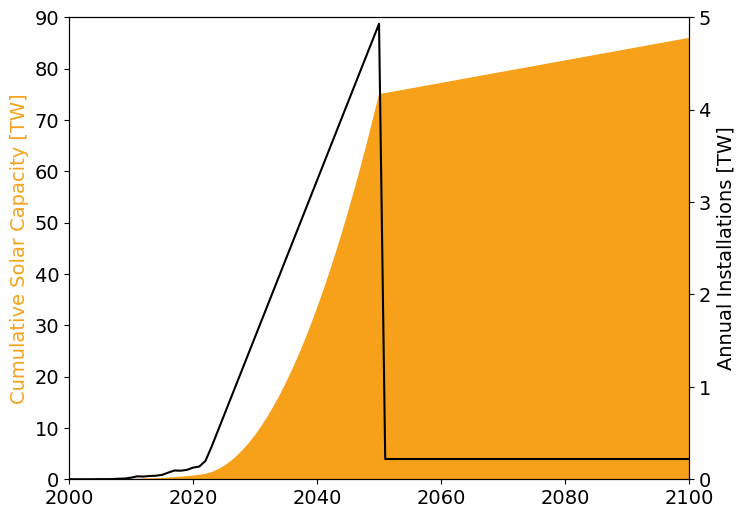

In [60]:
global_projection = pd.read_csv(os.path.join(supportMatfolder,'output-globalInstallsProjection.csv'), index_col=0)

fig, ax1 = plt.subplots()

ax1.stackplot(global_projection.index, global_projection['World_cum']/1e6, color='#F7A11A')
ax1.set_ylabel('Cumulative Solar Capacity [TW]', color='#F7A11A')
ax1.set_ylim(0,90)
ax1.set_xlim(2000,2100)
ax2 = ax1.twinx()
ax2.plot(global_projection['World_annual_[MWdc]']/1e6)
ax2.set_ylabel('Annual Installations [TW]')
ax2.set_ylim(0,5)
plt.show()

fig.savefig('energyresults-deployment.png', dpi=300, bbox_inches='tight')

In [61]:
#deployment projection for all scenarios
sim1.modifyScenario(scenarios=None,stage='new_Installed_Capacity_[MW]', 
                    value= global_projection['World_annual_[MWdc]'], start_year=2000)
#for scen in scennames:
#    sim1.scenario[scen].dataIn_m.loc[0:len(global_projection.index-1),'new_Installed_Capacity_[MW]'] = global_projection['World_annual_[MWdc]'].values

# 2. Calculate Mass flow: Identical Installations
Can just calc mass here (exclude energy) because we're going to immediately do Install Compensation.

In [62]:
sim1.scenario.keys()

dict_keys(['PV_ICE', 'ex_PERC_50', 'ex_High_eff', 'ex_Perovskite', 'h_50PERC', 'h_RecycledPERC', 'h_Perovskite', 'r_PERC', 'r_SHJ', 'r_TOPCon', 'r_IRENA'])

In [63]:
scennames_ex = ['PV_ICE', 'ex_PERC_50', 'ex_High_eff', 'ex_Perovskite'] #extreme boundaries
scennames_r = ['PV_ICE','r_PERC', 'r_SHJ', 'r_TOPCon', 'r_IRENA'] #realistic cases
scennames_hyp = ['PV_ICE', 'h_50PERC','h_RecycledPERC', 'h_Perovskite'] #hypothetical modules

scennames_all = ['PV_ICE', 'ex_PERC_50', 'ex_High_eff', 'ex_Perovskite',
                 'h_50PERC','h_RecycledPERC', 'h_Perovskite',
                'r_PERC', 'r_SHJ', 'r_TOPCon', 'r_IRENA']

In [64]:
for scen in sim1.scenario.keys():
    print(sim1.scenario[scen].material.keys())

dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])


#evolving weibulls

idx_temp = pd.RangeIndex(start=2022,stop=2101,step=1) #create the index
evolve_weibull = pd.DataFrame(index=idx_temp, columns=['alpha','beta'], dtype=float)
evolve_weibull.loc[2022] = [5.3759,30]
evolve_weibull.loc[2030] = [5.1   ,35]
evolve_weibull.loc[2050] = [4.602 ,40.767]

evolve_weibull.interpolate(inplace=True)
evolve_weibull = round(evolve_weibull,3)
#evolve_weibull_temp = evolve_weibull.reset_index(drop=True)
#evolve_weibull_temp.to_dict(orient='dict')
#dict([(i,[a,b,c ]) for i, a,b,c in zip(df.ID, df.A,df.B,df.C)])
dict_weibull = {'alpha':evolve_weibull['alpha'].tolist(),
                'beta':evolve_weibull['beta'].tolist()}
evolve_weibull.to_csv(os.path.join(altBaselinesfolder,'evolve_weibull.csv'))

In [65]:
IRENAregloss = {'alpha':5.3759,
                   'beta':30} #IRENA values

In [66]:
bifiFactors = {'PV_ICE':0.0,
               'ex_PERC_50':0.7, # ITRPV 2022, Fig. 58
               'ex_High_eff': 0.9,
               'ex_Perovskite': 0.0,
               'h_50PERC':0.7,
               'h_RecycledPERC': 0.0,
               'h_Perovskite': 0.0,
               'r_PERC':0.7,
               'r_SHJ':0.9, # ITRPV 2022, Fig. 58
               'r_TOPCon':0.8, # ITRPV 2022, Fig. 58              
                'r_IRENA':0.0 } 

#MAY NEED TO CHANGE TO BE DYNAMIC
#               'ex_Lightweight':0.0,

In [67]:
#PV ICE currently set up to read in a csv of bifi factors, so generate files to read in 
idx_temp = pd.RangeIndex(start=2000,stop=2101,step=1) #create the index
df_temp = pd.DataFrame(index=idx_temp, columns=['bifi'], dtype=float)
bifiPathDict={}

for f in bifiFactors.keys(): #loop over module types
    bifi = df_temp.copy() #copy of df
    bifi['bifi'] = bifiFactors[f] #assign column
    bifipath = os.path.join(testfolder,'bifi_'+str(f)+'.csv') #create file path
    bifi.to_csv(path_or_buf=bifipath, index_label='year') #create file
    bifiPathDict[str(f)] = bifipath
    #append bifi path to dict? or list?


In [68]:
for scen in sim1.scenario.keys(): #loop over scenarios
    if scen in ['r_IRENA']: #,'ex_Lightweight'
        sim1.calculateMassFlow(scenarios=[scen], bifacialityfactors=bifiPathDict[scen], weibullInputParams=IRENAregloss)
    #elif scen in ['ex_PERC_50','h_50PERC']:
    #    sim1.calculateMassFlow(scenarios=[scen], bifacialityfactors=bifiPathDict[scen], nameplatedeglimit=0.0) 
    else:
        sim1.calculateMassFlow(scenarios=[scen], bifacialityfactors=bifiPathDict[scen]) 


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on 

==> Working on Material :  backsheet


In [69]:
ii_yearly, ii_cumu = sim1.aggregateResults() #have to do this to get auto plots

In [73]:
sim1.saveSimulation(customname='_EnergyAnalysis_identicalinstalls')

:) Saved Input and Output Dataframes


In [ ]:
effective_capacity = ii_yearly.filter(like='ActiveCapacity')
#plt.plot(ii_cumu['newInstalledCapacity_sim1_PV_ICE_[MW]']/1e6, label='Capacity Target', color='black', ls='--')
#plt.plot(effective_capacity/1e6, label=sim1.scenario.keys())
#plt.legend()
#plt.ylabel('Effective Capacity [TW]')
#plt.title('Effective Capacity: No Replacements')
#plt.ylim(0,)

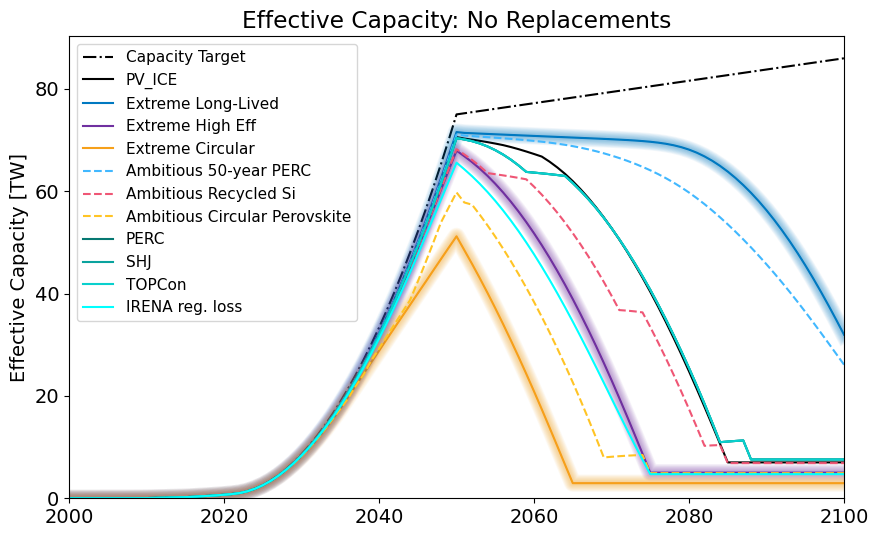

In [75]:
effective_capacity_tw = ii_yearly.filter(like='ActiveCapacity')/1e6

plt.rcParams['figure.figsize'] = (10, 6)

plt.plot(ii_cumu['newInstalledCapacity_sim1_PV_ICE_[MW]']/1e6, 
         label='Capacity Target', color='black', ls='dashdot')

plt.plot(effective_capacity_tw.iloc[:,0:4], label=scennames_labels_flat[0:4]) #color=colorpalette[1:4], 
#create glowlines for idealized scens
n_lines = 10
diff_linewidth = 1.05
alpha_value = 0.05
for n in range(1, n_lines+1):    
    plt.plot(effective_capacity_tw.iloc[:,1],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[1])

for n in range(1, n_lines+1):    
    plt.plot(effective_capacity_tw.iloc[:,2],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[2])

for n in range(1, n_lines+1):    
    plt.plot(effective_capacity_tw.iloc[:,3],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[3])

plt.plot(effective_capacity_tw.iloc[:,4:7], label=scennames_labels_flat[4:7],  ls='--') #color=colorpalette[4:7],
plt.plot(effective_capacity_tw.iloc[:,7:], label=scennames_labels_flat[7:])#, color=colorpalette[7:])

#plt.plot(effective_capacity/1e6, label=sim1.scenario.keys())
plt.legend(prop={'size': 11}) #bbox_to_anchor=(1,1.02), 
plt.ylabel('Effective Capacity [TW]')
plt.title('Effective Capacity: No Replacements')
plt.ylim(0,)
plt.xlim(2000,2100)

plt.savefig('energyresults-effectivecapacity.png', dpi=300, bbox_inches='tight')

In [76]:
plt.rcParams['figure.figsize'] = (8, 6)

effective_capacity = ii_yearly.filter(like='ActiveCapacity')

plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.plot(ii_cumu['newInstalledCapacity_sim1_PV_ICE_[MW]']/1e6, label='Capacity Target', color='black', ls='--')
plt.plot(effective_capacity/1e6, label=sim1.scenario.keys())

plt.subplot(1, 3, 2)


plt.subplot(1, 3, 3)


plt.legend()
plt.ylabel('Effective Capacity [TW]')
plt.title('Effective Capacity: No Replacements')
plt.ylim(0,)

# 3. Calculate Mass and Energy Flow: Installation Compensation
Make the installations always match up to the cumulative capacity deployment schedule. 

In [74]:
#currently takes ~40 mins to run with 7 materials and 12 scenarios
UnderInstall_df = pd.DataFrame()


for row in range (0,len(sim1.scenario['PV_ICE'].dataIn_m)): #loop over length of years
    print(row)
    for scen in sim1.scenario.keys(): #loop over scenarios
        print(scen)
        Under_Installment = global_projection.iloc[row,0] - ((sim1.scenario[scen].dataOut_m['Effective_Capacity_[W]'][row])/1e6)  # MWATTS
        sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed
        UnderInstall_df.loc[row,scen] = Under_Installment #save the underinstallment as df
        #calculate flows for that scenario with it's bifi factor and modified weibull
        if scen in ['r_IRENA']: #,'ex_Lightweight'
            sim1.calculateFlows(scenarios=[scen], bifacialityfactors=bifiPathDict[scen], weibullInputParams=IRENAregloss)
        #elif scen in ['ex_PERC_50','h_50PERC']:
        #    sim1.calculateMassFlow(scenarios=[scen], bifacialityfactors=bifiPathDict[scen], nameplatedeglimit=0.0) 
        else:
            sim1.calculateFlows(scenarios=[scen], bifacialityfactors=bifiPathDict[scen]) 


0
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2286015779.360064  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11399047.994346652  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  60979171.60898491  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  215480556.58063576  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6965632.679115519  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2591670.1919490653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  24793365.506877523  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  85989051.91329204  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  466988.9573589953  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  295432881.60088825  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2084001632.3159513  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.40619942  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  46772470.20863377  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1865534.95208879  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  241617026.8598689  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1234805768.2411082  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43197078.41449269  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  255968.74065249972  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  229395718.3704415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2286015779.360064  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11399047.994346652  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  60979171.60898491  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  215480556.58063576  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6965632.679115519  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2591670.1919490653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  24793365.506877523  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  85989051.91329204  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  466988.9573589953  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  295432881.60088825  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2084001632.3159513  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.40619942  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  46772470.20863377  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1865534.95208879  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  241617026.8598689  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1234805768.2411082  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43197078.41449269  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  255968.74065249972  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  229395718.3704415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2286015779.360064  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11399047.994346652  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  60979171.60898491  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  215480556.58063576  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6965632.679115519  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2591670.1919490653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  24793365.506877523  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  85989051.91329204  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  466988.9573589953  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  295432881.60088825  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2084001632.3159513  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.40619942  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  46772470.20863377  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1865534.95208879  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  241617026.8598689  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1234805768.2411082  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43197078.41449269  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  255968.74065249972  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  229395718.3704415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2286015779.360064  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11399047.994346652  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  60979171.60898491  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  215480556.58063576  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6965632.679115519  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2591670.1919490653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  24793365.506877523  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  85989051.91329204  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  466988.9573589953  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  295432881.60088825  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2084001632.3159513  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.40619942  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  46772470.20863377  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1865534.95208879  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  241617026.8598689  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1234805768.2411082  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43197078.41449269  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  255968.74065249972  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  229395718.3704415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2286015779.360064  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11399047.994346652  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  60979171.60898491  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  215480556.58063576  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6965632.679115519  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2591670.1919490653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  24793365.506877523  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  85989051.91329204  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  466988.9573589953  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  295432881.60088825  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2084001632.3159513  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.40619942  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  46772470.20863377  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1865534.95208879  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  241617026.8598689  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1234805768.2411082  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43197078.41449269  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  255968.74065249972  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  229395718.3704415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2286015779.360064  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11399047.994346652  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  60979171.60898491  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  215480556.58063576  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6965632.679115519  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2591670.1919490653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  24793365.506877523  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  85989051.91329204  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  466988.9573589953  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  295432881.60088825  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2084001632.3159513  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.40619942  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  46772470.20863377  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1865534.95208879  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  241617026.8598689  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1234805768.2411082  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43197078.41449269  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  255968.74065249972  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  229395718.3704415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2286015779.360064  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11399047.994346652  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  60979171.60898491  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  215480556.58063576  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6965632.679115519  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2591670.1919490653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  24793365.506877523  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  85989051.91329204  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  466988.9573589953  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  295432881.60088825  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2084001632.3159513  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.40619942  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  46772470.20863377  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1865534.95208879  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  241617026.8598689  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1234805768.2411082  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43197078.41449269  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  255968.74065249972  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  229395718.3704415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2286015779.360064  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11399047.994346652  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  60979171.60898491  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  215480556.58063576  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6965632.679115519  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2591670.1919490653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  24793365.506877523  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  85989051.91329204  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  466988.9573589953  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  295432881.60088825  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2084001632.3159513  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.40619942  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  46772470.20863377  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1865534.95208879  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  241617026.8598689  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1234805768.2411082  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43197078.41449269  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  255968.74065249972  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  229395718.3704415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2286015779.360064  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11399047.994346652  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  60979171.60898491  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  215480556.58063576  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6965632.679115519  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2591670.1919490653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  24793365.506877523  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  85989051.91329204  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  466988.9573589953  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  295432881.60088825  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2084001632.3159513  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.40619942  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  46772470.20863377  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1865534.95208879  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  241617026.8598689  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1234805768.2411082  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43197078.41449269  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  255968.74065249972  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  229395718.3704415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2286015779.360064  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11399047.994346652  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  60979171.60898491  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  215480556.58063576  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6965632.679115519  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2591670.1919490653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  24793365.506877523  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  85989051.91329204  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  466988.9573589953  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  295432881.60088825  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2084001632.3159513  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.40619942  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  46772470.20863377  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1865534.95208879  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  241617026.8598689  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1234805768.2411082  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43197078.41449269  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  255968.74065249972  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  229395718.3704415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2286015779.360064  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11399047.994346652  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  60979171.60898491  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  215480556.58063576  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6965632.679115519  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2591670.1919490653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  24793365.506877523  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  85989051.91329204  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  466988.9573589953  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  295432881.60088825  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2084001632.3159513  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.40619942  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  46772470.20863377  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1865534.95208879  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  241617026.8598689  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1234805768.2411082  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43197078.41449269  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  255968.74065249972  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  229395718.3704415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2286015779.360064  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11399047.994346652  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  60979171.60898491  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  215480556.58063576  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6965632.679115519  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2591670.1919490653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  24793365.506877523  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  85989051.91329204  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  466988.9573589953  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  295432881.60088825  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2084001632.3159513  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.40619942  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  46772470.20863377  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1865534.95208879  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  241617026.8598689  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1234805768.2411082  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43197078.41449269  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  255968.74065249972  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  229395718.3704415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2286015779.360064  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11399047.994346652  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  60979171.60898491  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  215480556.58063576  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6965632.679115519  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2591670.1919490653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  24793365.506877523  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  85989051.91329204  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  466988.9573589953  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  295432881.60088825  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2084001632.3159513  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.40619942  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  46772470.20863377  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1865534.95208879  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  241617026.8598689  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1234805768.2411082  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43197078.41449269  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  255968.74065249972  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  229395718.3704415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2286015779.360064  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11399047.994346652  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  60979171.60898491  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  215480556.58063576  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6965632.679115519  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2591670.1919490653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  24793365.506877523  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  85989051.91329204  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  466988.9573589953  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  295432881.60088825  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2084001632.3159513  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.40619942  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  46772470.20863377  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1865534.95208879  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  241617026.8598689  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1234805768.2411082  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43197078.41449269  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  255968.74065249972  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  229395718.3704415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2286015779.360064  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11399047.994346652  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  60979171.60898491  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  215480556.58063576  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6965632.679115519  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2591670.1919490653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  24793365.506877523  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  85989051.91329204  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  466988.9573589953  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  295432881.60088825  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2084001632.3159513  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.40619942  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  46772470.20863377  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1865534.95208879  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  241617026.8598689  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1234805768.2411082  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43197078.41449269  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  255968.74065249972  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  229395718.3704415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2286015779.360064  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11399047.994346652  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  60979171.60898491  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  215480556.58063576  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6965632.679115519  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2591670.1919490653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  24793365.506877523  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  85989051.91329204  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  466988.9573589953  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  295432881.60088825  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2084001632.3159513  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.40619942  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  46772470.20863377  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1865534.95208879  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  241617026.8598689  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1234805768.2411082  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43197078.41449269  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  255968.74065249972  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  229395718.3704415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2286015779.360064  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11399047.994346652  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  60979171.60898491  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  215480556.58063576  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6965632.679115519  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2591670.1919490653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  24793365.506877523  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  85989051.91329204  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  466988.9573589953  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  295432881.60088825  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2084001632.3159513  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.40619942  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  46772470.20863377  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1865534.95208879  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  241617026.8598689  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1234805768.2411082  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43197078.41449269  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  255968.74065249972  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  229395718.3704415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2286015779.360064  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11399047.994346652  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  60979171.60898491  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  215480556.58063576  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6965632.679115519  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2591670.1919490653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  24793365.506877523  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  85989051.91329204  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  466988.9573589953  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  295432881.60088825  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2084001632.3159513  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.40619942  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  46772470.20863377  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1865534.95208879  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  241617026.8598689  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1234805768.2411082  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43197078.41449269  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  255968.74065249972  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  229395718.3704415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2286015779.360064  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11399047.994346652  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  60979171.60898491  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  215480556.58063576  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6965632.679115519  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2591670.1919490653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  24793365.506877523  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  85989051.91329204  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  466988.9573589953  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  295432881.60088825  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2084001632.3159513  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.40619942  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  46772470.20863377  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1865534.95208879  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  241617026.8598689  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1234805768.2411082  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43197078.41449269  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  255968.74065249972  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  229395718.3704415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2286015779.360064  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11399047.994346652  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  60979171.60898491  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  215480556.58063576  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6965632.679115519  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2591670.1919490653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  24793365.506877523  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  85989051.91329204  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  466988.9573589953  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  295432881.60088825  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2084001632.3159513  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.40619942  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  46772470.20863377  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1865534.95208879  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  241617026.8598689  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1234805768.2411082  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43197078.41449269  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  255968.74065249972  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  229395718.3704415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2286015779.360064  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11399047.994346652  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  60979171.60898491  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  215480556.58063576  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6965632.679115519  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2591670.1919490653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  24793365.506877523  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  85989051.91329204  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  466988.9573589953  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  295432881.60088825  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2084001632.3159513  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.40619942  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  46772470.20863377  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1865534.95208879  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  241617026.8598689  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1234805768.2411082  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43197078.41449269  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  255968.74065249972  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  229395718.3704415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2286219276.7311816  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11399146.669806607  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  60987696.36875637  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  215509008.8867792  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6965632.679115519  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2591670.1919490653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  24793365.506877523  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  85997258.26655683  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  467059.4553876401  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  295459723.3991367  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2084205129.6870687  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.40619942  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  46778733.29744546  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1865711.3411206293  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  241645479.16601238  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009645375  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.7050073073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1234859442.5600138  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43199526.764227115  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  255989.9882258923  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  229406395.96904394  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2286219276.7311816  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11399146.669806607  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  60987696.36875637  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  215509008.8867792  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6965632.679115519  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2591670.1919490653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  24793365.506877538  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  85997258.26655683  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  467059.4553876401  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  295459723.3991367  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2084205129.6870687  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.40619942  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  46778733.29744546  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1865711.3411206293  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  241645479.16601238  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209839.50857876305  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.96324486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369842.86644672893  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35583487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768220496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.423886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1234859442.5600138  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43199526.764227115  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  255989.9882258923  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  229406395.96904394  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2286219276.7311816  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11399146.669806607  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  60987696.36875637  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  215509008.8867792  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6965632.679115519  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2591670.1919490653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  24793365.507053025  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  85997258.26655683  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  467059.4553876401  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  295459723.3991367  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2084205129.6870687  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.40619942  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  46778733.29744546  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1865711.3411206293  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  241645479.16601238  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.476181  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92358141  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209895.40357867477  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188339048.300161  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  co

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.163131  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79518448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369957.91923384333  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179048051.1800522  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5683703  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.884777226  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355975.5179465118  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182879774.38958934  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1234859442.5600138  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43199526.764227115  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  255989.9882258923  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  229406395.96904394  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2286219276.7311816  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11399146.669806607  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  60987696.36875637  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  215509008.8867792  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6965632.679115519  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2591670.1919490653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  24793365.628382195  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  85997258.26655683  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  467059.4553876401  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  295459723.3991367  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2084205129.6870687  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.40619942  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  46778733.29744546  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1865711.3411206293  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  241645479.16601238  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254491403.7147644  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35661361.64218097  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209965.67292664107  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188377368.29546827  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192601250.772926  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33902175.11280083  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  370099.64887870854  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179084518.73791635  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1218121288.0343707  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34627715.571472384  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  356090.04288967274  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182917041.2139616  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1234859442.5600138  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43199526.764227115  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  255989.9882258923  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  229406395.96904394  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2286219276.7311816  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11399146.669806607  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  60987696.36875637  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  215509008.8867792  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6965632.679115519  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2591670.1919490653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  24793376.221635733  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  85997258.26655683  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  467059.4553876401  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  295459723.3991367  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2084205129.6870687  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.40619942  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  46778733.29744546  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1865711.3411206293  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  241645479.16601238  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254853701.0736341  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35672717.93791386  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  210054.98202755855  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188428166.10920003  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192945968.6182742  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33912980.374557056  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  370275.70946639485  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179132851.7231543  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1218473528.5374782  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34638756.63270139  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  356235.93319201085  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182966428.95314202  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1234859442.5600138  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43199526.764227115  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  255989.9882258923  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  229406395.96904394  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2286219276.7311816  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11399146.669806607  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  60987696.36875637  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  215509008.8867792  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6965632.679115519  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2591670.191949125  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  24793591.987457227  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  86031845.3604882  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  467294.06218044535  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  295576103.0642611  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2084205129.6870687  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.40619942  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  46778733.29744546  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1865711.3411206293  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  241645479.16601238  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1255331469.5854616  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35687451.37772081  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  210166.42076470036  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188494506.43689585  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1193400469.4494245  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33926996.2849241  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  370489.77694306633  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179195961.22771588  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1218937905.4506652  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34653077.10198475  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  356417.8111272193  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  183030909.79654747  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1235302104.3603833  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43216760.034410946  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  256108.07556183945  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  229483711.9843557  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2286219276.7311816  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11399146.669806607  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  60987696.36875637  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  215509008.8867792  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6965632.679115519  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2591670.1924473788  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  24795185.85634182  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  86075050.9129988  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  467575.04151474836  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  295722567.69694525  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2084205129.6870687  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.40619942  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  46778733.29744546  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1865711.3411206293  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  241645479.16601238  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1255930964.1157963  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35705654.81296289  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  210298.2904771869  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188576915.72079563  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1193970662.752752  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33944309.99897381  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  370735.6963514335  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179274342.62977043  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1219520436.4516768  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34670765.44577579  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  356632.83277933946  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  183110987.19544548  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1235907029.1718557  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43239701.155827075  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  256258.79129076438  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  229587404.30247474  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2286219276.7311816  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11399146.669806607  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  60987696.36875637  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  215509008.8867792  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6965632.679115519  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2591670.423129491  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  24801279.13603382  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  86130505.83420871  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  467919.21287644247  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  295911994.2227185  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2084205129.6870687  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.40619942  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  46778733.29744546  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1865711.3411206293  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  241645479.16601238  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1256713097.1752064  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35729033.74667193  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  210460.31886212292  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188683465.52935836  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1194714432.3188088  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33966542.19996625  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  371027.68920647725  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179375666.1883704  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1220280232.2574058  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34693476.69108225  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  356896.5155475025  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  183214494.00502625  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1236779988.9140863  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43271952.725920096  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  256460.9975609879  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  229734293.64947724  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2286219276.7311816  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11399146.669806607  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  60987696.36875637  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  215509008.8867792  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6965632.679115519  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2591684.3746371525  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  24816234.3797835  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  86200211.42198268  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  468330.54125822603  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  296151963.7116504  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2084205129.6870687  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.40619942  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  46778733.29744546  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1865711.3411206293  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  241645479.16601238  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1257716992.4520526  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35758566.195149966  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  210655.69124164846  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188819080.31640822  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1195668915.245957  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33994621.04296844  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  371365.9542914554  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179504605.9312832  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1221255196.6727393  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34722158.05559092  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  357213.6062154303  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  183346200.5630868  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1237992925.9269073  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43315610.05540741  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  256721.24554185852  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  229934687.47498956  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silve

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2286219276.7311816  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11399146.669806607  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  60987696.36875637  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  215509008.8867792  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6965632.67911555  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2591894.018664764  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  24846294.1567236  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  86286183.0016889  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  468806.3952461801  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  296447543.26592225  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2084205129.6870687  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.40619942  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  46778733.29744546  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1865711.3411206293  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  241645479.16601238  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1258973000.9909654  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35795260.4544701  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  210884.38060256097  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188987319.33619037  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1196862890.7997737  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34029503.01011776  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  371743.5344310427  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179664535.796881  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1222474687.9263542  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34757785.46329748  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  357583.63812343613  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  183509548.18914565  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1239544945.5556676  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43371335.41731868  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  257032.83361322456  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230190140.5396985  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2286219276.7311816  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11399146.669806607  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  60987696.36875637  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  215509008.8867792  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6965632.679260206  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2592734.4554885947  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  24887925.32490894  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  86379617.93707561  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  469327.1755500729  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  296768355.6339155  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2084205129.6870687  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.40619942  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  46778733.29744546  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1865711.3411206293  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  241645479.16601238  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1260333497.291831  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35834731.30133981  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  211128.3746751157  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  189168036.177755  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  cop

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1198156193.5711844  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34067024.43197979  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  372148.55768299947  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179836327.2173262  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1223795629.056991  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34796108.73184154  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  357980.629630536  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  183685010.8558722  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1241323400.3731337  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43435034.97548921  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  257391.5001010087  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230481760.3142825  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2286219276.7311816  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11399146.669806607  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  60987696.36875637  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  215509008.8867792  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6965632.745436109  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2595190.529905791  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  24943456.37076278  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  86506076.02321994  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  470032.01769781293  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  297202554.23318607  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2089456462.7474847  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.40619942  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  46905640.42145016  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1869285.460123211  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  242250674.14888477  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1262209621.54705  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35889161.59500482  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  211459.72754078862  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  189417234.57692537  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1199939657.956381  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34118766.46876509  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  372701.63732420147  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  180073217.9608534  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1225617206.7366414  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34848956.515116654  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  358522.82290391676  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  183926964.04232597  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243790608.1473327  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43523403.84693192  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  257889.06952943327  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886317.44325626  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2286219276.7311816  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11399146.669806607  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  60987696.36875637  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  215509008.8867792  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6965638.881265347  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2600264.2957549025  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25009731.595835365  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  86635034.10666177  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  470750.7941341245  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  297645336.66728956  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2095227744.1751618  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.40619942  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  47045112.955258615  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1873213.4620957756  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  242915791.08673495  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1264093914.4306712  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35943828.87768671  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  211787.39522882967  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  189667511.91178688  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1201730887.529726  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34170733.78992061  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  373251.66920701275  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  180311134.35253468  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1227446715.5493872  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34902034.39717242  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  359062.10523012176  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  184169964.79541463  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1246434424.5586622  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43618098.37368163  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258422.25616835416  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  231319833.73972976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2286219276.7311816  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11399146.669806607  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  60987696.36875637  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  215509008.8867792  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6965817.620210448  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2611388.713149591  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25092302.17966153  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  86809641.9266559  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  471724.0094864146  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  298244859.1903224  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2102650871.6598687  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406199452  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  47224505.07329156  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1878265.7299097623  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  243771276.62903097  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1266705484.158342  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  36019595.984693795  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  212234.42803338706  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  190014380.94267303  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1204213474.4830163  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34242758.83652432  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  374006.4388001059  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  180640871.87455234  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1229982356.305346  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34975598.645698  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  359802.2295712808  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  184506748.93040282  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1250073206.8358333  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43748429.95200351  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  259156.10065309814  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  231916498.24703538  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2286219276.7311816  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11399146.669806607  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  60987696.36875637  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  215509008.8867792  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6967813.312333542  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2627412.412515595  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25188389.276698828  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  87002000.01872107  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  472796.15991095663  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  298905327.9407171  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2116557446.0523918  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406199325  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  47560580.37847755  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1887730.7078925516  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  245373953.3121645  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1269577055.5303488  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  36102906.28390429  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  212718.16790626184  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  190395781.61535597  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1206943221.8637016  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34321954.52473563  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  374828.06375979475  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  181003435.55567732  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1232770439.3985736  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  35056486.775098115  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  360608.02165913186  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  184877060.73167628  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1254222100.6304717  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43897032.378682785  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  259992.82090648776  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  232596807.61519188  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2298569013.5713215  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11405135.031996848  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  61316739.793188214  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  216661848.6669555  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6978997.271872179  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2647832.0644824305  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25296372.341369946  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  87192390.78729795  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  473857.3450223654  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  299559041.8118552  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2135312602.0693932  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406199325  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  48013829.6549934  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1900495.6875168753  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  247535409.4974593  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1272372418.293422  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  36184005.61177186  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  213181.48001942612  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  190767059.34983703  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1209600524.5011878  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34399048.43923134  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  375619.81870333455  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  181356376.26022896  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1235484529.5776095  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  35135228.21509991  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  361384.6261182284  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  185237543.90980297  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1258512321.8558543  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  44050696.78096434  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  260858.04310027795  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  233300290.961732  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2320929840.7791324  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11415977.751475573  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  61912516.30671461  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  218749217.12318256  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  7019615.865614089  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2673884.294972176  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25423047.700094663  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  87440770.58157252  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  475241.74481038627  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  300411863.1857137  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2145989731.7291422  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406199325  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  48271860.102149375  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1907762.6674571864  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  248765905.68332618  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working o

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1276107112.6362886  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  36292356.9159383  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  213790.34089687932  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  191263097.65811923  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1213150766.0865033  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34502048.382616185  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  376666.85579143156  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  181827915.7406517  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1239110641.1405077  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  35240429.305423  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  362411.7712268275  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  185719160.3635666  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1263995795.6450276  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  44247100.34105459  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  261963.91223201161  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  234199436.3179318  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2349890182.4686666  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11430020.56205809  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  62684128.70020854  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.95619056333  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  221452645.89898267  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  7117763.13452946  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2704056.009911  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25562049.887590703  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  87681426.83612277  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  476583.0957393471  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  301238165.4951775  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2171731933.473677  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406199325  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  48893962.86184163  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1925283.11252607  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  251732590.74493766  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1279658923.1236627  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  36395402.37645748  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  214359.74466770355  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  191734845.2072892  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1216527156.2640612  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34600004.53257847  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  377652.3762865893  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  182276364.157865  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1242559186.026675  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  35340478.81459004  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  363378.7058988569  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  186177192.2895477  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1269681026.9488082  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  44450730.322874434  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  263110.4704262043  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  235131664.59552637  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2387216483.73972  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11448120.009368299  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  63678641.71296218  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.95619056333  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  224937031.47813556  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  7307371.331164671  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2739095.5214170804  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25717978.721796375  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  87950835.04264374  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  478084.70203984354  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  302163188.7140952  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2183942041.2645926  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406199325  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  49189040.25375434  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1933593.4554003468  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  253139756.4855941  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1283647504.9305415  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  36511119.48765169  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  214988.34166255567  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  192264604.07525977  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1220318746.0695992  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34710006.49326874  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  378747.5841607658  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  182779958.77380756  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1246431803.5106497  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  35452831.55792175  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  364453.41512354993  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  186691548.90894952  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1276190354.3963542  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  44683877.253751606  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  264423.2266404859  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  236199022.94745293  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2434032606.817114  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11470821.051905667  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  64925999.26036674  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  229307285.65730393  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  7615755.468231898  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2779355.38595462  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25893251.847304024  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88279595.95605418  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  479917.12379606697  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  303292001.68644094  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2217707537.869886  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406199325  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  50005039.165929414  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1956574.64925344  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  257031093.96212056  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1288598875.9777858  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  36654769.13100352  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  215755.2328796944  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  192922239.41505787  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1225025573.9335263  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34846561.426744774  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  380092.88032421854  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  183405114.17261115  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  cop

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1251239218.0292988  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  35592304.72090206  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  365773.7270891594  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  187330064.11016464  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1284077137.507638  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  44966361.01136055  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  266013.7786020304  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  237492247.7685266  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2488501271.387694  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11497232.796195403  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  66377249.28670576  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  234391899.53230968  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8075851.21655482  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2823129.863613147  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  26081257.602168422  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88608666.19965588  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  481751.26967261336  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  304421876.75564307  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2257165388.499158  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406205726  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  50958603.201034136  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1983430.1261604764  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  261578452.31114095  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1293484407.6189563  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  36796508.63530281  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  216498.66486387033  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  193571129.99145812  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1229669814.1327248  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34981300.56099455  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  381406.19786569756  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  184021956.70299283  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1255982707.3616428  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  35729923.28035414  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  367062.8490057853  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  187960088.7938807  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1292461850.550239  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  45266679.30505849  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  267704.7496340368  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  238867119.99098668  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2551818573.64126  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11527935.226839172  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  68064260.29179724  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.9561905673  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  240302527.89275432  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  8647290.598854851  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2869762.9690676117  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  26279888.79844449  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88971699.00593324  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  483774.71341336885  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305668363.56230706  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2303387268.769648  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406205726  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  52075631.16778686  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2014889.2811424918  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  266905337.83083698  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1298879839.633384  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  36953041.41727498  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  217305.04268997163  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  194287744.92836487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1234798771.244021  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  35130102.34796922  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  382841.02530357626  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  184703178.75655228  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1261221272.1860213  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  35881905.01662822  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  368471.4594771377  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  188655868.81502926  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1301963217.1205635  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  45606993.18124016  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  269620.91963929037  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  240425093.99756026  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2625096894.1888013  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11563467.734925332  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  70016670.27766877  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.95619057125  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  247143010.73423007  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  9268987.1984315  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2917211.9177791267  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  26481053.819423877  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  89396357.60199831  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  486141.64214076725  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  307126444.8381002  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2357360707.6858635  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406205726  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  53379988.33323356  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2051624.2380469136  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  273125559.26121753  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1304805457.4919913  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  37124956.000913784  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  218174.57485811829  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  195074778.5225564  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1240431728.8595483  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  35293526.24506069  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  384399.757648758  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  185451341.56148866  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1266974608.1920724  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  36048821.34292787  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  370001.952086075  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  189420020.13620436  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1313154821.8861847  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  46007846.92899233  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  271877.96521308343  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  242260222.57486826  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2707964822.6738434  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11603650.224329507  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  72224583.47592138  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.95619057125  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  254878677.1451818  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  9881225.60297328  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2962073.6171350162  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  26670737.805238258  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  89866687.77794732  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  488763.1315327901  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  308741341.2027238  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2418859267.993462  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406207231  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  54866202.46767838  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2093480.8810169925  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  280213020.62080735  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1311644512.1982603  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  37323371.300442986  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  219159.58140236454  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  195983133.72329438  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1246933009.6052723  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  35482142.01462076  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  386179.04560416023  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  186314834.02213866  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1273614823.7152147  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  36241467.901341155  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  371749.28590895206  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  190301965.75055054  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1325890095.3402994  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  46463990.815382265  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  274446.3272293111  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  244348472.1820444  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2798783018.694415  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11647687.782236626  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  74644321.69432642  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.95619057125  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  263356495.78145155  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10425556.060005648  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3000966.6796961683  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  26834922.402533736  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  90330411.29224229  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  491347.7972330145  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  310333553.34585166  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2438303938.9777937  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406207231  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  55336115.01054113  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2106715.152632311  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  282453940.6287241  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1319140322.2270122  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  37540840.44726902  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  220218.8310850258  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  196978718.39301792  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1254058609.195646  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  35688870.58132651  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  388107.5810139184  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  187261247.77696344  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1280892700.0079463  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  36452614.33408355  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  373643.49874015775  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  191268604.71783957  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1339387510.9043818  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  46947432.620837286  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  277168.39280386944  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  246561693.03286806  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2900442926.5037847  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11696982.46406444  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  77352923.87962139  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.95619057125  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  272846381.05502075  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10878543.301468128  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3032812.822940457  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  26969224.99521254  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  90876487.5981478  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  494391.474454613  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  312208526.8991318  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2460710574.38449  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406207231  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  55877608.30859919  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2121965.3720470066  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  285036215.1055425  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1327248423.8077168  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  37776073.45429178  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  221342.59583889652  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  198055626.90626505  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1261766259.880571  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  35912485.66922952  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  390170.2642484977  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  188284968.87333986  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1288765066.0426927  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  36681008.15923544  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  375669.8130750489  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  192314203.1132015  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1355340445.4458876  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  47518824.6358816  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  280385.6704910269  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  249177554.35768655  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3010581588.7498813  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11750388.476614788  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  80287431.96322747  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.95619057125  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  283127752.4572041  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  11227157.64312387  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3057053.7189961406  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27071387.264541358  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  91609348.38597873  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  498476.2363503428  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  314724832.00257415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2483730843.2047243  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406207231  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  56433931.070111424  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2137633.2375753107  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  287689208.3615589  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1335028455.287061  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  38001788.46062236  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  222399.77212976923  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  199088961.53458697  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1269162043.5129826  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  36127052.840820216  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  392127.04967843136  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  189267268.154678  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1296318900.3105083  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  36900160.710752346  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  377592.427823953  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  193317494.49399635  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1374804929.1464438  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  48215991.0747284  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  284311.1331661799  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  252369217.30768305  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3131457219.0651345  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11809000.823069697  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  83508013.2471958  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.95619057125  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  294411412.7396147  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  11483027.541960308  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3074698.826487727  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27145715.724210866  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  92565961.91479817  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  503808.13369885087  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  318009400.5653359  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2509867147.3039236  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406207231  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  57065557.96316533  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2155421.9133388693  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  290701312.1321034  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1343951942.346709  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  38260677.50798767  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  223588.10237051855  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  200274168.5878734  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1277644808.6168256  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  36373155.62127788  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  394345.69478862226  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  190393939.0362787  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1304982945.246385  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  37151522.79877758  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  379772.71354043396  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  194468242.74962234  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1398664145.1592803  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  49070565.227181815  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  289122.8951095047  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  256281500.67135426  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3263083694.220304  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11872826.232246978  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  87015037.46087608  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.95619057125  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  306698657.2896412  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  11664112.642533286  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3087112.5169320386  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27197989.89631007  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  93727073.0819899  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  510279.8439215913  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  321996119.4677292  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2581810223.993156  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406207231  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  58804181.06127014  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2204387.2169181476  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  298992461.9342225  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1353382263.8509645  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  38534270.88401496  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  224818.3288091707  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  201526692.7958304  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1286609376.127216  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  36633236.4985508  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  396663.15716041124  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  191584602.34670377  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1314139088.884683  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  37417161.700724095  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  382050.51858722104  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  195684350.97597763  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1426462269.3720098  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  50066220.67646846  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  294729.0288613708  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  260839661.2932378  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3407188617.8768334  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11942702.41563635  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  90854534.46159896  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  267559.95619057125  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  320150756.7684376  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  11788172.910307938  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3095576.398280076  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27233622.320432555  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  95155073.43606189  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  518239.12013101473  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  326899212.44027597  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2662042075.3799305  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5602589.406207231  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  60743116.06994817  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2258993.957978873  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  308238859.63309497  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1364437704.8631742  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  38855012.38032939  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  226230.54946394553  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  202995063.46497306  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1297118800.1448777  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  36938136.8983725  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  399348.10218452  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  192980451.68098858  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
=

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1324873103.1859818  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  37728577.93501606  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  384690.0047574053  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  197110030.1275174  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1458322355.9295528  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  51207364.897316106  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  301154.3511320666  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  266063876.81386247  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3439898284.4377537  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11752751.994032033  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  91651824.31497113  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  262208.75706675946  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  322940683.4434214  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  11882312.466800062  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3101979.000707393  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27260572.58241332  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  95493755.449061  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  518209.59388762986  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  328181357.803881  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2685130187.534394  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5378485.829959077  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  61413768.59926043  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2255950.9445069064  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  310726886.41235405  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1376182572.863893  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  39195755.59739381  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  227730.83743616694  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  204555003.0156578  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1308283601.0528395  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  37262051.15428665  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  402200.48273293243  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  194463347.40282938  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1336276500.024458  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  38059414.3585473  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  387494.09159793047  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  198624615.88015446  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1476710031.5204427  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  51822770.17706307  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  303391.656664248  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  268318773.94653717  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3470217112.779757  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11561642.259854374  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  92459631.9007967  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  256857.55794294956  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  325733610.7499397  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  11949436.221576387  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3106531.2847419903  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27279731.76815457  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  95875792.95939122  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  519194.2253070016  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  329555398.32710546  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2714713447.739647  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5378485.829959077  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  62128696.87140362  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2276085.6591101214  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  314136237.98980105  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1389516241.6478653  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  39582593.252482325  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  229310.62661958602  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  206325965.2172402  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1320958733.488269  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  37629783.290782474  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  404936.4718789102  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  196146843.58132896  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1349222504.734526  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  38435005.06699713  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  390677.50457207137  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  200344088.99550572  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1494292261.454491  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  52433905.01784768  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  305902.7154486082  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  270523752.64332163  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3497923660.624292  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11369265.83619493  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  93197838.511995  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  251506.35881913773  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  328282683.39676416  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  11996932.707944015  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3109744.039942369  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27293251.72942133  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  96235113.14588371  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  520396.4463936276  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  330813544.23839974  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2733210756.494773  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5266434.041835118  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  62648148.81756866  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2279749.732792141  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  316241385.65034395  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1405781317.6902018  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  40054477.17115421  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  230327.58979165315  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  208188496.23012695  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1336420493.9571323  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  38078361.34234655  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  406509.222491503  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  197915861.97624806  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1365014688.7511861  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  38893169.39766315  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  393106.62147715065  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  202150154.75192097  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1510825024.9941156  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  53023894.13086358  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  308476.8527990495  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  272608080.47533196  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3522671203.508722  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  11175454.597068863  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  93857206.10519747  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  246155.1596953303  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  330555534.8842306  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12030307.983590195  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3111996.102345943  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27302727.967219897  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  97589255.76750068  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  529402.8114721434  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  335398310.8121637  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2750209570.6272054  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5154382.253709811  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  63131387.169830054  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2282393.913421368  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  318173837.84154916  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1423023423.8613217  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  40538603.70616593  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  230851.34894193316  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  209930971.7996716  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1352797861.4911387  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  38538158.11785749  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  407138.2953213339  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  199570420.69150427  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1381735506.0408723  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  39362583.96804834  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  394823.20033404895  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  203839149.2740643  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1526311788.0617573  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  53597280.48659396  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  311198.3094695683  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  274586558.2200008  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3544243359.8098087  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  10980103.619469166  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  94431969.46036613  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  240803.9605715185  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  332531966.1306749  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12053609.898369402  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3113564.8430172377  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27309328.378679127  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  98237786.30997725  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  533017.5400701435  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  337625064.84358346  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2764824147.7799315  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  5042330.465585601  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  63557006.50334726  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2283415.3543390194  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  319831516.32453674  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1439526822.9906678  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  40998210.2648206  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  230964.05147669147  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  211569152.56810996  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1368471767.3028958  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  38974613.71284609  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  407075.0669669408  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  201125684.45125243  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1397737215.1356938  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  39808142.60714437  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  395973.7283087908  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  205426652.06573126  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1541153043.2394001  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  54149699.58659208  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  314143.2053583725  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  276474348.6249284  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3562970777.087957  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  10783373.233722588  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  94930938.27174495  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  235452.76144770472  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  334242842.86755216  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12069747.172972023  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3114648.896674682  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27313889.175672892  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  98900505.238572  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  536711.350780244  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  339900535.2328595  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2777416477.810634  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  4930278.677461517  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  63933754.90003179  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2283060.4300968926  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  321256138.9723114  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1455401438.8759785  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41440981.42388542  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  230802.95447088304  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213120963.7685404  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1383548265.5735974  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39395082.52214829  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  406683.0272956493  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  202598904.52515814  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1413128911.0627508  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  40237381.382803276  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  396786.29602403066  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  206930388.01571432  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1555280222.916985  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  54679038.66456197  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  316918.1862801126  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  278262704.9158222  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3578617800.851686  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  10585149.171447637  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  95347833.81762007  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  230101.5623238929  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  335666166.9036726  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12080845.88901559  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3115392.9547227453  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27317019.374835968  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  99582908.45621751  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  540514.8762345285  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  342243592.3696031  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2790464089.218908  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  4818226.889337307  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  64321505.92206419  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2283015.3757115086  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  322733230.96498024  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1477858844.2008297  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  42177660.00862624  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  230454.2177018212  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  214598934.56734544  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1404868898.0209875  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  40094548.25130134  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  406223.8120311821  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  204002159.83085087  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1434891466.69351  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  40951383.597264305  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  397413.90723763895  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  208362777.80263838  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1568504757.938092  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  55176047.393040895  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  319511.1280600784  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  279903051.24398535  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3590975640.054826  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  10385330.190291371  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  95677093.11946711  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  224750.363200085  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  336782447.7327294  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12088431.527295796  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3115900.5171845183  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27319154.553827625  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  100292437.74693687  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  544469.5948642598  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  344679787.89940244  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2799652858.621133  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  4706175.101212846  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  64616001.66294376  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2280343.948101813  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  323765606.9598462  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1510748595.908738  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  43131860.58412156  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  230528.63926377922  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  216649974.81385723  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1436134258.3220644  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  41001621.830247894  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  408261.85097211105  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  205949852.76662645  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  cop

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1466824979.3239837  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  41877841.67454614  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  400761.79879302514  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  210351077.39797294  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1580952594.446359  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  55645236.83051864  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  321947.43064689095  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  281416039.4616082  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3600119932.2588964  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  10183952.966753768  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  95920731.44632223  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  219399.16407627315  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  337598746.0711509  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12093590.540653985  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3116245.085821569  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27320604.006542962  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  101038954.78380184  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  548630.4728882075  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  347242982.24799055  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2810344254.5694065  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  4594123.313088542  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  64946810.85246928  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2278695.2257805206  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  324971154.61157286  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1547088336.258862  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  44186152.55517043  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  235170.67315957096  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  221476576.37551808  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1470679215.8329787  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  42003843.392457224  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  417087.38809204294  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  210538073.38304368  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  cop

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1502108175.3713357  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  42901481.08273305  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  409437.9105805435  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  215037349.98830405  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1592500978.7437484  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  56082210.263481796  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  324202.33792231476  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  282781541.19354135  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3606363649.9221673  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  9981169.260540625  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  96087087.56125021  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  214047.96495246133  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  338144277.69127846  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12097088.325440593  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3116478.3036745167  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27321585.024496384  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  101334473.39199185  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  550711.2176614368  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  348240458.74851567  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2816113413.204207  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  4482071.524964081  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  65158666.059465975  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2273696.3708900455  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  325609434.2396663  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1556864472.245978  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  44469778.733557895  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  236419.47555014465  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  222775031.25625762  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1479972518.4004183  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  42273461.562179364  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  419461.6387116817  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  211772398.89700782  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1511600079.256605  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  43176861.09260074  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  411771.962718974  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  216298053.49565923  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1603270958.4460473  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  56491303.29807989  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  326300.261933697  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  284019405.0623552  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3609203977.753209  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  9776735.257543774  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  96162764.57430178  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  208696.7658286495  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  338372105.1176381  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12099455.63002843  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3116635.894258592  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27322247.904820655  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  101594291.73441933  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  552511.8454978423  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  349124936.5671247  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2819963787.070928  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  4370019.736839871  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  65324150.66804523  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2267391.568533912  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  326026581.652093  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1566843276.5665362  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  44759284.74473108  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  237694.16676833175  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  224100404.30661705  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1489458479.7183065  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  42548669.16572234  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  421885.1097407839  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  213032313.11955458  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1521288759.0811768  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  43457949.98456017  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  414154.4019152034  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  217584892.55177674  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1613351817.3694706  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  56875713.844987355  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  328259.2088246087  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  285144271.2636304  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3609151495.0781436  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  9570898.536636207  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  96161366.23850323  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  203345.56670483373  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  338329890.5932161  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12101055.268467138  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3116742.2236444736  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27322695.154725093  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  101800810.49586885  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  554015.3963162765  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  349826408.26799226  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2821778408.043574  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  4257967.948715662  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  65440437.95053622  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2259701.20883083  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  326209116.74347925  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1577104225.237928  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  45056976.35439487  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  239004.89907067228  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  225463251.43772733  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1499212650.5643203  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  42831658.08936653  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  424377.10287316656  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  214327850.6160937  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1531251380.1708252  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  43746986.48631334  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  416604.2030657135  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  218908116.16444546  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1622590202.8057513  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  57229949.21489605  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  330048.2514797103  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  286130993.990019  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3605929712.85159  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  9363525.02884383  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  96075525.8460866  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  197994.36758101993  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  337991824.04817635  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12102133.007219328  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3116813.7635599608  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27322996.066670634  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  101964250.68201163  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  555278.8391553274  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  350379968.05885786  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2821460358.5120864  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  4145916.160591828  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  65505185.73305351  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2250559.3285162323  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  326145870.1496488  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1577643424.248798  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  45072619.64690276  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  239073.77628500914  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  225534867.21601418  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1499725219.0841005  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  42846528.775557734  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  424508.0537506253  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  214395929.363883  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1531774902.4697123  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  43762174.96457612  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  416732.9368114411  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  218977649.78028947  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1631189211.4087837  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  57561283.79397084  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  331708.3490298255  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  287012875.746508  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3599805910.8014765  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  9154744.33756175  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  95912364.7339759  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  192643.16845720613  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  337382855.8686512  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12102855.072905086  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3116861.633541396  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27323197.41587076  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  102077034.80029969  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  556259.9391822143  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  350759598.3338047  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2819157964.9544854  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  4033864.372467493  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  65521978.56956132  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2240066.880334432  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  325853935.89973545  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1578037892.32596  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  45084063.99192506  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  239124.16558794174  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  225587260.0019535  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  co

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1500100204.7838795  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  42857407.896011725  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  424603.8550035808  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  214445734.5233783  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1532157901.752779  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  43773286.575863495  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  416827.11605160846  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  219028519.29448947  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1639074978.619782  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  57867071.94864655  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  333224.6049807553  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  287777804.68984336  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3590929155.857231  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  8944628.745039577  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  95675854.60566261  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  187291.96933339577  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  336731822.06089926  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12103334.520784156  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3116893.38236595  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27323330.955817204  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  102148750.76683444  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  557012.1367706096  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  350998219.56370324  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2823474193.689957  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  3921812.584343535  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  65698721.32934073  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2234079.14427743  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  326324771.2093249  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1552692268.7607021  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  44361277.30120563  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  233854.3510616766  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  221739236.49090794  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1476006375.8045402  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  42170318.90528722  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  416248.5150242454  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  210787760.98230925  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1507549178.7245119  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  43071514.23892982  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  408645.81045100203  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  215292373.50404277  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1646200428.968869  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  58145627.55982569  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  334587.52547677985  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  288418061.6821651  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3619074012.0524883  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  8752464.85620464  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  96425739.39936356  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  181940.77020958444  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  339106889.7960554  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12103648.942925945  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3116914.1815723325  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27323418.439724423  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  99038178.9714419  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  540027.1487884123  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  340310335.9663205  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2826628831.6798887  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  3809760.796219451  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  65847392.33303635  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2227300.815906232  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  326661737.864372  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1523246246.9784927  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  43526574.45988188  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  227962.5921796215  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  217385036.91912678  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1448014663.1084294  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  41376841.18888215  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  406793.05482968246  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  206648610.90165353  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1478959272.760785  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  42261079.60984456  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  399384.6225850453  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  211064768.25314495  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1652758169.4132774  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  58403849.30042127  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  335835.95415912906  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  288965229.1943351  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3645351862.811357  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  8559395.660244064  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  97125880.14829868  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  176589.57108577262  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  341522594.51322275  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12103851.997238321  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3116927.6011937046  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27323474.884044655  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  95601922.32611513  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  521226.8841709819  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  328504201.1763354  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2829082311.6618657  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  3697709.008095241  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  65979118.697106406  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2220045.271153746  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  326917898.8832628  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1489437742.7488976  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  42565306.866751775  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  221420.35891796177  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  212451417.56089696  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1415875926.5388672  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  40463049.62511867  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  396179.081765098  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  201958657.98886403  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1446133719.487494  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  41327759.98192209  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  388986.0671899801  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  206274589.30958956  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1658699924.9064212  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  58640008.085663766  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  336960.15524973505  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  289411391.38949025  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3669515193.1497936  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  8365301.137646714  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  97769682.1226367  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  171238.37196196473  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  343740910.1452441  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12103980.855178336  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3116936.1102147484  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27323510.673795585  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  91916279.11281216  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  501036.60828935093  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  315841788.2170873  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2830474404.619775  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  3585657.219971001  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  66085194.89327995  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2212067.333917637  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  327051739.322891  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1451869778.1474998  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41494969.45509019  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  214353.23991444474  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  207018471.09887618  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1380163405.5240486  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39445575.09029951  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  384604.6379424908  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  196794039.2304105  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1409658008.6717293  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  40288541.63945145  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  377644.0359862893  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  200999600.735446  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1664004053.4922848  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  58853328.757802434  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  337955.76414834126  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  289752999.5565399  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3691299237.28704  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  8170052.904026347  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  98350090.9664589  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  165887.17283815288  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  345737120.981296  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working o

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12104061.104742203  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3116941.4055809616  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27323532.946580764  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  87960947.02855428  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  479343.1617618461  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  302253388.367022  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2840538405.259583  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  3025398.2793505844  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  66725136.19332498  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2164297.834781517  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  328078611.5267492  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1408883898.6723318  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  40267446.98662284  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  206495.31316930603  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  200865923.5571907  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1339300554.944162  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  38278678.70886312  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  371609.5001607345  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  190945359.7581951  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1367921903.840562  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  39096708.25015993  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  364906.98567379155  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  195025932.81673184  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1668778238.5014942  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  59047668.249560945  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  338844.49768554035  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  290007710.92708474  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3710543333.3593216  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  7973573.054772592  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  98862826.04362573  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  160535.9737143391  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  347496229.3424711  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12104110.114936352  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3116944.63755123  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27323546.54052772  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  83716421.81563513  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  456037.8332888515  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  287731570.44367766  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2867059922.8671727  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  3025398.2793505844  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  67366072.40287977  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2182348.69129551  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  331135109.6024977  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1361722934.1113563  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  38918796.556260236  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  198083.62906372597  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  194158846.1261589  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1294468822.4871886  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  36996636.75245177  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  357578.68495363987  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  184569538.06422928  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1322132100.6566377  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  37787268.58230972  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  351152.1285129295  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  188513857.45175034  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1673234081.8125682  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  59230605.58180476  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  339669.0302671325  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  290210222.63906133  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3727491808.0967007  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  7775980.063418489  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  99314397.13689455  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  155184.7745905273  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  349041042.96770537  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12104139.451502547  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3116946.5711141312  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27323554.673257615  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  79436850.5938218  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  433379.5569895519  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  272955109.4064092  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2894542033.604153  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  3025398.2793505844  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  68030222.93261352  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2201053.3388676024  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  334302312.1671448  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1310754083.5320797  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  37459671.377947204  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  189200.1628358338  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  186946009.75393826  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1246017271.6319203  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  35609576.28360179  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  342638.6302389968  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  177712936.3491129  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1272645122.2145731  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  36370566.117514305  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  336503.1858587861  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  181510727.61849985  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1677219671.6785083  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  59396699.67665563  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  340398.72538089694  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  290335625.16483843  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3741965371.041465  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  7577186.992387234  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  99700027.27433974  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  149833.5754667194  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  350354825.21114707  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12104156.65246079  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3116947.704316857  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27323559.43960368  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  79441988.81417166  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  433408.19599854964  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  272972751.679408  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2923366042.9463844  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  3025398.2793505844  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  68726802.65547402  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2220671.298409387  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  337624163.1408868  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1255060144.6959555  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35863461.4939182  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  179714.80104191328  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  179105592.71824133  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1193073999.826104  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34092201.58331459  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  326552.8237206681  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  170259749.54159957  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1218570433.0816472  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34820764.55789134  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  320727.86245157477  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  173898263.44847038  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1680719661.9052987  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  59545400.873942964  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  341030.48811238614  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  290381402.132566  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3753813033.1394954  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  7377120.627393882  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  100015693.53984074  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  144482.37634290755  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  351423481.3442836  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12104166.524106644  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3116948.3544245963  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27323562.174011327  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  79445526.61570457  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  433427.9147188525  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  272984898.854151  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2954037301.724566  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  3025398.2793505844  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  69468024.20748025  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2241546.5176291545  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  341158902.17141163  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1195780371.419195  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  34163219.04323213  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  169835.01647668084  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  170788909.37066975  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1136721994.2979357  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  32475932.379096046  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  309663.7596551858  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  162353818.7312654  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1161014164.3242292  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  33169955.082160417  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  304161.83663561643  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  165823379.96859682  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1683777684.6902173  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  59678271.96382665  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  341573.1179018776  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  290354708.0740372  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3763104092.0328217  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  7175814.570724376  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  100263242.2831404  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  139131.17721909573  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  352253480.2562452  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12104172.064022137  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3116948.719154396  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27323563.70809539  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  79409386.2584947  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  433441.5078706266  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  272853191.3362386  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2985639782.897778  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2913346.491226527  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  70269626.00497675  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2264122.241721912  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  344774368.16557676  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1132397222.4185102  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  32343929.069414444  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  159498.12036647173  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  161927220.48683545  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1076469274.6020684  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  30746495.287910245  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  291849.3825750055  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  153929799.65414628  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1099473821.692639  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  31403559.279803716  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  286685.06327914936  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  157219336.48379242  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1686656606.9446108  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  59804728.14535813  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  342079.6279330187  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  290298646.2430878  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3770090131.032638  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  6973390.814612628  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  100449376.62960215  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  133779.9780952839  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  352868307.08302546  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12104175.10033489  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3116948.9190093474  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27323564.54870204  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  74783904.40128833  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  407580.3977844578  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  257095857.7175793  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2971830527.3886504  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  6083407.52668462  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  69984755.9273031  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2245133.980855009  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  343935241.14268017  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1064513644.715667  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  30394072.234049328  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  148664.66128677712  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  152467789.9572794  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1011938397.8032857  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  28892939.899757195  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  273025.2351908525  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  144937560.78362697  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1033563896.156341  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  29510392.726503845  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  268214.3300182649  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  148034930.13815123  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1689542880.0513625  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  59931447.615022  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  342587.62043330766  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  290243789.75842375  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3774439317.276643  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  6769688.453980921  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  100565255.30408272  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  128428.77897147207  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  353236985.446019  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12104176.722823782  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3116949.025785591  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27323564.997811835  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  69926837.50161822  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  380287.1042152694  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  240549513.80034277  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2891458893.7567735  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2689242.914978175  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  68138457.44190384  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2182170.7974848105  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  333867214.71931994  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  991976941.5404358  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  28309218.48405146  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  137336.08758845687  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  142390336.77661884  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  942984208.6696347  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  26911054.95737064  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  253176.49561327006  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  135357822.7725665  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  963136130.4623156  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  27486154.168867026  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  248734.72185002913  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  138250469.57774314  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1668786513.2729695  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  59211350.117576055  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  338327.5285682987  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  286312162.6939487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3776610026.8376145  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  6564929.754451227  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  100623091.16865495  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  123077.57984766025  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  353402304.4489796  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12104177.566172352  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3116949.0812794436  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27304471.782527212  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  64850631.66769314  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  351665.32095262985  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  223256584.3876763  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2860067205.564204  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2577191.126854118  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  67452259.49893196  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2151879.8334727725  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  330222856.4342446  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  915120893.1928998  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  26099051.484936386  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  125587.08234574618  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  131739193.25163724  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  869924002.4314418  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  24810045.859869048  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  232418.2735661256  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  125232728.40017676  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  888514600.5574764  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  25340245.728800304  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  228358.8733755191  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  127908998.18858047  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1643539548.7280662  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  58330411.25894454  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  333161.8039522365  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  281644195.80483705  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3776528865.5443716  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  6359079.127340233  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  100620928.72663648  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  117726.38072384449  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  353357412.7944856  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12104177.991266098  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3116949.109248893  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27191792.182465743  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  59592327.41776833  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  321986.6650148435  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  205343271.8473586  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2773486545.5851536  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2465139.3387297834  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  65432329.03402311  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2084026.606598023  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  320218191.45165  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  833969690.5339142  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  23764273.064238578  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  113444.16308230931  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  120517572.38401426  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  792780775.1875315  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  22590579.772238284  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  210781.33445731588  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  114565331.98125029  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  809722793.975799  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  23073348.8288524  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  207116.6444336023  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  117013635.55729401  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1613188157.689781  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  57266645.31404181  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  326966.6538458255  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  276139237.3381147  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3774613302.4544597  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  6152339.002541712  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  100569890.92340405  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  112375.18160003265  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  353141280.9434271  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12104178.198226782  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3116949.1228652652  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  26978176.70127571  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  54088090.626096696  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  290827.48032779514  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  186592126.13460368  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2679555811.56222  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2353087.550605824  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  63234771.90796  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  2011170.8329397396  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  309366460.04155564  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ener

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  748215606.556214  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  21295955.417028487  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  100885.84540196018  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  108684602.23466837  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  711261998.2547466  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  20244169.824759867  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  188209.8808496502  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  103316780.20023331  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  726461930.5878205  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  20676795.23175564  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  184952.88961311718  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  105524698.05858639  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1577821167.6705337  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  56023233.849944495  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  319759.99236843793  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  269811852.66755116  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3771306721.2128506  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  5944924.375880243  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  100481791.16638209  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  107023.98247621885  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  352795298.46632004  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12104178.295075653  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3116949.129236919  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  26657804.178987913  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  48260022.64188498  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  257676.774062438  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  166737779.23225158  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2575234693.348148  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2241035.7624812387  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  60786114.011896074  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1931243.2416773501  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  297317278.7058428  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  658199954.4653671  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  18704000.754185386  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  87984.94057676077  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  96285615.62202738  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  625692127.7263514  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  17780229.168182578  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  164817.8408879663  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  91530166.93372916  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  639063400.2336887  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  18160199.250776663  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  161979.1284768253  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  93486200.50116473  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1537576312.181595  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  54605110.11754376  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  311569.59666361  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  262684626.46334144  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3795913014.8407016  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  5751044.645277927  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  101137395.34829208  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  101672.78335240703  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  355054964.428944  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12104178.338391788  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3116949.1320866127  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  26227479.600883577  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  42083406.15776374  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  222393.08551064125  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  145696031.87783754  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2461860541.7592697  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2128983.9743562774  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  58118674.63389262  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1845154.049495038  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  284224771.7392513  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  564092559.9256661  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  15993336.073883057  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  74787.89813934512  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  83343168.59103234  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  536232601.7496947  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  15203441.461248327  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  140672.7607277349  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  79226934.20654584  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  547692091.0537535  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  15528344.63617942  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  138261.35705932984  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  80920043.13384865  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1492656661.3650699  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  53019547.55342216  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  302436.420515451  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  254790856.883237  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3819002297.822115  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  5556429.319309091  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  101752580.66262093  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  96321.58422859914  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  357173018.4493215  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12104178.356794996  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3116949.1332973135  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25687262.60116515  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  35580037.18184072  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  186586.3342260838  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  123541139.02653603  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2348492350.237572  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2016932.1862323189  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  55451379.290742144  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1759068.9138044987  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  271132951.64639574  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working o

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  465814350.73794174  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  13161667.326028848  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  61306.34629554654  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  69846758.86521372  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  442808253.42115283  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  12511625.954666799  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  115778.52254233717  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  66397098.43897366  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  452271229.79982024  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  12779004.035253558  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  113803.03501513587  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  67816029.02413249  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1443061145.2472208  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  51266507.83394413  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  292360.24813904567  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  246130368.47971043  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3840380915.8778195  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  5360984.495409184  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  102322187.43122885  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  90970.38510478534  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  359131383.028342  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12104178.364175793  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3116949.1337828753  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25040140.99442825  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  34759143.53554375  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  186586.3998595905  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  120744617.26417  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2218826674.111458  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  1904880.3981081096  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  52390228.35400002  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1661891.5185393349  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  256162912.09905887  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  362805053.9222727  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  10192739.818139113  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  47487.84443929336  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  55721971.64650757  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  344886481.0738072  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  9689330.758694455  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  90019.38052026645  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  52969920.10418813  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  352256832.91008836  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  9896395.345648777  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  88490.06213433963  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  54101906.91530358  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1389165255.368808  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  49359440.07516714  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  281416.80607565545  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  236764731.98112616  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3859846782.9748955  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  5164612.182472762  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  102840831.32235523  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  85619.18598097352  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  360911193.5682585  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12104178.366952633  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3105617.7669891077  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  24290641.99113922  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  34487908.886590146  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  186586.4333811044  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  118537425.30876757  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  2093171113.363117  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  1792828.609984057  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  49425988.46892138  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1567443.4549332727  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  241655022.19628775  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  281654880.6312299  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  7916755.012834965  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  36610.644201509276  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  43170846.697598256  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  267744232.35840404  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  7525754.529552479  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  69604.96339286846  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  41038682.459206566  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  273466025.7684336  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  7686582.691165515  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  68426.48046868299  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  41915694.30287182  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1330836897.1240149  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  47293612.99691221  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  269579.45439726097  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  226672287.34934676  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3877280731.971421  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  4967254.596596152  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  103305337.27527086  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  80267.98685716168  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  362501325.8950522  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12104178.367926171  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3070937.5484370072  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  23442984.059712585  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  27863171.089264378  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  148309.63411166868  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  95969063.19680691  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  1946345782.163827  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  1680776.8218600987  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  45950146.16730187  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1458586.996738912  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  224707401.52076304  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  281654883.42763656  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  7916755.0939645795  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  36610.64455872192  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  43170847.0690137  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  267744235.01669908  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  7525754.606675184  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  69604.96407200902  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  41038682.81227818  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  273466028.4835373  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  7686582.769936361  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  68426.48113632502  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  41915694.663488716  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1268458982.0500572  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  45082741.47992827  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  256925.4160587758  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  215915821.9968338  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3657833493.993668  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  4655033.806586711  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  97458437.73392877  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  74916.78773335379  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  341978755.8173922  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12104178.36824175  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3013547.21908622  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  22499828.421152227  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  25920052.38366643  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  139536.53331257973  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  89104130.98854887  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  1790108889.7825904  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  1568725.0337361402  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  42246857.96799245  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1343324.9193851107  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  206675136.32873535  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  281654884.58145505  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  7916755.127439269  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  36610.64470611054  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  43170847.22226252  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  267744236.11353162  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  7525754.638496595  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  69604.96435222754  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  41038682.95795819  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  273466029.6038095  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  7686582.802437806  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  68426.4814117991  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  41915694.81228196  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1202346472.984808  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  42738106.66187241  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  243518.21059059957  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  204546981.5380166  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3421739363.71324  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  4334740.9724732  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  91168002.38932832  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  69565.58860954196  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  319902209.33430314  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working o

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12104178.36833539  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2933702.117986254  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  21462234.193529874  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  24221403.242096256  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  130421.2089169975  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  83264136.9746631  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  1623885798.3733068  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  1456673.2456121817  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  38302236.79973823  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1221266.117599804  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  187492001.9230797  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  281654885.0314638  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  7916755.140494966  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  36610.64476359462  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  43170847.282032155  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  267744236.54131493  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  7525754.650907485  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  69604.96446151748  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  41038683.01477587  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  273466030.04073477  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  7686582.815113923  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  68426.4815192387  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  41915694.870313846  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1132284744.0916984  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  40252021.21168219  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  229314.55373595297  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  192530572.98544037  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3170756631.0094914  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  4007228.6854292764  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  84480878.69502546  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  64214.38948573013  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  296435821.64512074  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12104178.36836047  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2831449.8803988  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  20330395.66378347  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  22358066.45490299  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  120387.96145784178  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  76858681.7298909  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  1447248545.8616753  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  1344621.4574883485  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  34105940.25321045  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  1092119.3153651694  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  167108677.3985616  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  173308744.3059353  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  4792994.614243093  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  22721.9003566944  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  28337226.73371251  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  cop

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  164749201.5803066  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  4556273.481973497  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  43199.37758644856  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  26937679.9080493  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
=

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  168269953.03630006  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  4653642.73379196  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  42467.96812454384  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  27513348.104602765  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1058867962.6547748  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  37645766.63344837  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  214434.27305010022  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  179964024.13301763  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2906731263.3682284  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3673392.051321525  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  77446250.16567989  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  58863.1903619183  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  271751912.5958547  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12104178.36836644  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2706800.9224233436  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  19104354.97024886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  20336532.01576047  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  109472.96435208691  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  69910048.8918261  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  1260893168.353052  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  1232569.6693647662  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  29674789.188811183  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  956358.2430353829  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  145605378.11269403  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  166739954.6093101  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  4622008.185729947  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  21834.182064678058  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  27021554.213773258  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  158504837.73010352  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  4393731.899369423  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  41511.62801069988  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  25686987.11658505  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  161892144.81789166  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  4487627.57736707  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  40808.79386811694  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  26235927.54496545  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  982065384.3285594  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  34918241.745851085  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  198871.16822572763  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  166842293.71739417  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2631666048.7601066  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  3334202.2179500917  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  70117478.60331258  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  53511.99123810647  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  246037441.12123492  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12104178.368367672  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2559821.4370758845  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  17784390.240180343  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  19663251.340387303  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  106072.75817452389  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  67590696.10645644  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  1101417740.4783275  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  1120517.8812408077  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  25893236.43824642  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  838891.9803605273  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  127199884.74984494  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  158537900.8026052  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  4403637.3449654  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  20737.830819131443  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  25488953.47617579  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  cop

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  150707875.02412516  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  4186146.172472277  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  39427.22086692031  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  24230079.971641168  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  153928558.1311221  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  4275605.666602518  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  38759.677860288764  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  24747885.754738826  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  901929203.1854457  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  32071316.002821907  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  182635.7654029682  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  153173940.1925026  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2345112153.145515  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2989441.546604908  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  62482605.38149235  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  48160.792114294636  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  219250508.86000425  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  12104178.368367879  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2390678.19682774  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  16371202.905116336  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  18961035.645658422  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  102511.27625881383  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  65171993.84287483  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  935327406.600364  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  1008466.0931167236  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  21951823.57468281  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  716923.534911428  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  108032050.11492723  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  147440725.18382293  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  4101272.957404049  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  19271.657074727493  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  23571826.065444726  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  140158777.62968874  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  3898715.2546813446  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  36639.699040068335  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  22407637.535106596  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  cop

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  143154022.61829388  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  3982032.2436425067  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  36019.35161710805  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  22886497.04835688  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  819097851.591509  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  29127856.36687311  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  165856.81921319006  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  139063649.66048813  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2049465226.8884816  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2640271.683258412  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  54605459.63356224  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  42809.59299048281  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  191614748.19192874  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  11893480.645347212  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2199663.612249034  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  14866022.867054552  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  18218546.627274156  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  98725.32205503278  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  62615011.606439784  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  764854143.8531356  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  896414.3049926398  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  17904490.00658261  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  591972.0165590419  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  88359100.58224  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  133275155.86356492  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  3709888.042664613  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  17413.527101945154  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  21247158.213074733  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  126692831.37989429  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  3526660.4430667805  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  33106.98139590902  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  20197782.66511053  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  129400304.10975382  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  3602026.482905662  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  32546.44648080269  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  20629416.76132423  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  733649094.9691745  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  26090648.190210868  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  148550.0128498364  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  124524173.60355604  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  1745189454.9932272  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  2286917.71027208  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  46498408.993370354  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  37458.393866667044  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  163173490.48067665  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  11356946.740396876  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  1987213.2461776063  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  13270682.139683323  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  17420592.10843392  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  94630.2186014185  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  59867586.48619944  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  588769952.9650587  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  784362.5168684933  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  13721559.106307905  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  463201.6345658255  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  68039514.1821075  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  115897106.30830476  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  3225302.3486602684  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  15145.035304979081  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  18495812.515192483  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  110173066.02865489  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  3066007.9439434744  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  28794.0748101699  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  17582323.13470545  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  112527505.2545265  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  3131529.669264044  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  28306.561796335292  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  17958063.892065637  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  645755115.4778206  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  22965858.583390664  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  130750.07082193434  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  109583745.36337596  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  1434778303.956061  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  1930588.7044610176  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  38227888.78381234  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  32107.19474285522  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  134159499.17737977  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10503811.917013062  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  1753934.6587964015  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  11587736.171933003  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  16547229.75468495  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  90114.81288059418  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  56861245.7260843  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  376454595.7898459  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  672310.7287443586  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  8663042.3195664  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  309771.8949537433  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  43820889.44664768  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ener

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  95455498.82917337  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  2651836.4235133366  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  12485.205001262137  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  15337568.657963732  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  90741048.7655215  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  2520864.917953454  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  23737.146833091934  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  14580061.731461743  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  92680218.58543593  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  2574736.7349037733  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  23335.252760483894  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  14891643.050685862  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  555934891.6231365  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  19772075.986887738  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  112561.65713108948  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  94327463.7534553  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  1121084708.5478158  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  1572668.0480732855  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  29869911.914217953  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  26755.99561904536  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  104839093.85925992  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Wor

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  9346986.865472047  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  1500677.205551597  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  9820757.42382901  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  14253050.29548581  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  77680.16837729745  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  48976475.94797778  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  348699541.75017816  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  560258.9406203061  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  8064729.638506545  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  281956.0668894326  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  40319180.95902416  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  71839976.40129986  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  1986288.57882018  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  9419.939198213933  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  11757769.1511739  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  68291872.98691209  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  1888187.8048290608  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  17909.395951784332  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  11177064.883708302  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  69751295.6059287  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  1928539.0775470745  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  17606.171637269195  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  11415922.899926813  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  464984129.66392213  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  16537800.499001656  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  94145.24432141651  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  78885803.65431812  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  912245315.3789792  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  1265590.980363274  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  24305645.244081832  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  21404.7964952355  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  85306759.09073678  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  7904973.717643062  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  1228658.0859989678  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  7974865.538478974  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  11779564.92544654  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  64246.12267197073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  40476052.57505993  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  319174086.3751413  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  448207.1524962534  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  7423632.289397468  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  252935.2828678172  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  36889898.48899388  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  45065752.154940926  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  1229100.1793492187  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  5951.181219194304  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  7758434.584886303  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  42840000.46204356  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  1168396.1707814396  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  11314.516855435952  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  7375253.386619081  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  43755507.138584584  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  1193365.2296903704  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  11122.950561028565  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  7532865.283066499  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  372780045.43416166  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  13258634.314936522  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  75476.07013010843  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  63238631.69486931  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  696450200.3503332  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  955141.0973187921  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  18556051.99008619  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  16053.597371427608  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  65125112.27908033  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6204408.411501139  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  939629.5983115027  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  6057430.82851678  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  9111940.862004671  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  49730.00196622706  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  31309046.69002478  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  287181311.9466959  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  336155.3643721969  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  6722908.106212609  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  222235.21249876148  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  33176267.436405767  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  15328276.42349645  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  385941.6485888156  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  2103.8978653923723  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  3365524.442446871  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  14571228.431010183  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  366880.38284643163  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  3999.9769765574288  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  3199304.6110434737  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  cop

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  14882620.97933213  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  374720.7525094829  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  3932.253292293688  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  3267674.9355091034  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  279573474.646508  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  9943561.707957206  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  56604.72137173283  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  47427078.32906416  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  472938357.75884426  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  640949.3888275118  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  12600856.098920783  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  10702.398247619718  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  44223114.04436246  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  4282880.542000429  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  636064.6487793145  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  4078854.544570508  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  6269515.329805757  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  34239.58656392895  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  21541853.38163953  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  251809394.72719607  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  224103.576248113  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  5940521.36453446  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  189235.25782928237  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  29073203.78831707  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on En

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  10667622.423844293  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  270314.2327050405  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  1459.9245891020123  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  2303288.2609662036  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  10140759.395187223  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  256963.68750635072  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  2775.640795105285  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  2189531.1948808446  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  10357471.179298861  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  262455.0966800884  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  2728.646369402524  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  2236322.287452884  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  185770662.76731735  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  6607133.318575652  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  37613.126826917294  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  31517757.1195083  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  240935788.84389642  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Perovskite  =  322640.5444699991  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  6419435.333367453  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Perovskite  =  5351.19912380986  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Perovskite  =  22528512.113308467  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  2191899.6166698528  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  321351.89283549093  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  2053389.654733897  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  3225601.7712844955  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  17626.133026648513  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  11082843.349892616  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  211899249.9939553  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite  =  112051.7881240526  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  5048460.870454428  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite  =  153146.53217379106  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  24447127.69922507  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on E

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  5611342.296428578  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  143208.87432581634  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  765.4140806397936  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  1188505.4826276724  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  5334203.8039262835  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  136135.93358419245  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  1455.2221143686547  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  1129806.4048694365  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  cop

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  5448197.714846908  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  139045.20890559375  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  1430.5837218016434  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  1153950.78618827  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  92342918.31078899  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  3284138.8544606306  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  18697.173290153998  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  15669937.094113186  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_PERC_50
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_PERC_50
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Perovskite
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Perovskite
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_Perovskite


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite  =  210903.19926597265  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_TOPCon
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_IRENA
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_10680\1411915970.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet


In [78]:
#test with one scenario
#scen='r_Perovskite'
#df_compensate = pd.DataFrame(columns=['underinstalls[W]'],dtype=float)

#for row in range (0,len(sim1.scenario['PV_ICE'].dataIn_m)): #loop over length of years
#    print(row)
#    Under_Installment = global_projection.iloc[row,0] - ((sim1.scenario[scen].dataOut_m['Installed_Capacity_[W]'][row])/1e6)  # MWATTS
#    if row==0:
#        df_compensate.loc[row,'underinstalls[W]'] = Under_Installment
#    else:
#        if Under_Installment < 0.7*df_compensate.iloc[row-1,0]:
#            Under_Installment = df_compensate.iloc[row-1,0]
#    df_compensate.loc[row,'underinstalls[W]'] = Under_Installment
#    sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed
    #calculate flows for that scenario with it's bifi factor and modified weibull
#    sim1.calculateFlows(scenarios=[scen], bifacialityfactors=bifiPathDict[scen])


In [81]:
#aggregate results - mass
cc_yearly, cc_cumu = sim1.aggregateResults() #have to do this to get auto plots
cc_yearly.to_csv(os.path.join(testfolder, 'cc_10scen_yearly.csv'))
cc_cumu.to_csv(os.path.join(testfolder, 'cc_10scen_cumu.csv'))

In [82]:
#aggregate results - energy
allenergy, energyGen, energy_demands = sim1.aggregateEnergyResults()
allenergy.to_csv(os.path.join(testfolder, 'cc_10scen_allenergy.csv'))
energyGen.to_csv(os.path.join(testfolder, 'cc_10scen_energyGen.csv'))
energy_demands.to_csv(os.path.join(testfolder, 'cc_10scen_energy_demands.csv'))

UnderInstall_df.to_csv(os.path.join(testfolder, 'cc_10scen_underInstalls.csv'))

C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\main.py:2177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_demands[colname] = energy_demands.filter(like=scen).sum(axis=1)
C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\main.py:2177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_demands[colname] = energy_demands.filter(like=scen).sum(axis=1)
C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\main.py:2177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [75]:
sim1.saveSimulation(customname='_EnergyAnalysis_withreplacements')

:) Saved Input and Output Dataframes


In [70]:
#read in saved results files for speed
cc_yearly = pd.read_csv(os.path.join(testfolder, 'cc_10scen_yearly.csv'), index_col='year')
cc_cumu = pd.read_csv(os.path.join(testfolder, 'cc_10scen_cumu.csv'), index_col='year')
allenergy = pd.read_csv(os.path.join(testfolder, 'cc_10scen_allenergy.csv'), index_col='year')
energyGen = pd.read_csv(os.path.join(testfolder, 'cc_10scen_energyGen.csv'), index_col='year')
energy_demands = pd.read_csv(os.path.join(testfolder, 'cc_10scen_energy_demands.csv'), index_col='year')


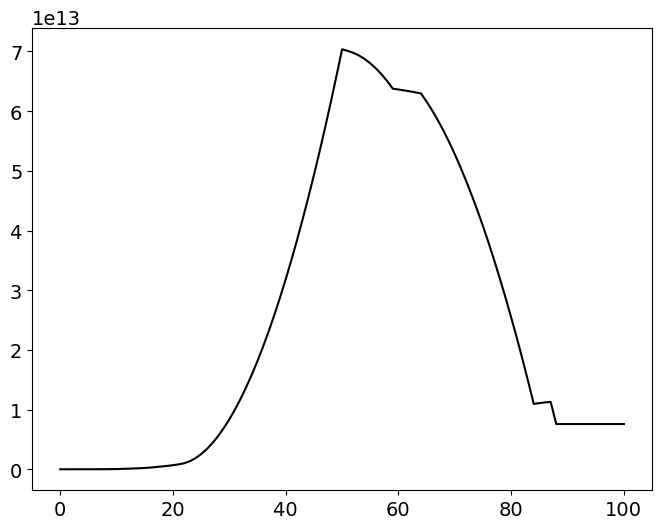

In [77]:
plt.plot(sim1.scenario['r_PERC'].dataOut_m['Effective_Capacity_[W]'])

In [78]:
#sim1.scenario['PV_ICE'].dataOut_m['irradiance_stc'].head(2)
sim1.scenario.keys()

dict_keys(['PV_ICE', 'ex_PERC_50', 'ex_High_eff', 'ex_Perovskite', 'h_50PERC', 'h_RecycledPERC', 'h_Perovskite', 'r_PERC', 'r_SHJ', 'r_TOPCon', 'r_IRENA'])

In [191]:
UnderInstall_df_temp = cc_yearly.filter(like='newInstalledCapacity_').subtract(global_projection[['World_annual_[MWdc]']].values)

In [193]:
#Attempt to make the deployment less dumb

UnderInstall_df_cumu = UnderInstall_df_temp.cumsum()

flatinstall = UnderInstall_df_cumu.iloc[-1,:]/(2100-2022)
flatinstall

newInstalledCapacity_sim1_PV_ICE_[MW]            1.342246e+06
newInstalledCapacity_sim1_ex_PERC_50_[MW]        1.026676e+06
newInstalledCapacity_sim1_ex_High_eff_[MW]       2.244034e+06
newInstalledCapacity_sim1_ex_Perovskite_[MW]     4.027728e+06
newInstalledCapacity_sim1_h_50PERC_[MW]          1.035524e+06
newInstalledCapacity_sim1_h_RecycledPERC_[MW]    1.512689e+06
newInstalledCapacity_sim1_h_Perovskite_[MW]      2.454031e+06
newInstalledCapacity_sim1_r_PERC_[MW]            1.306151e+06
newInstalledCapacity_sim1_r_SHJ_[MW]             1.306151e+06
newInstalledCapacity_sim1_r_TOPCon_[MW]          1.306151e+06
newInstalledCapacity_sim1_r_IRENA_[MW]           2.397069e+06
Name: 2100, dtype: float64

# RESULTS: Effective Capacity and Replacements

In [136]:
sim1.scenario['h_RecycledPERC'].dataOut_m['WeibullParams'].tail(4)

97     {'alpha': 12.283636210794834, 'beta': 42.04601...
98     {'alpha': 12.283636210794834, 'beta': 42.04601...
99     {'alpha': 12.283636210794834, 'beta': 42.04601...
100    {'alpha': 12.283636210794834, 'beta': 42.04601...
Name: WeibullParams, dtype: object

(0.0, 90.26425956655)

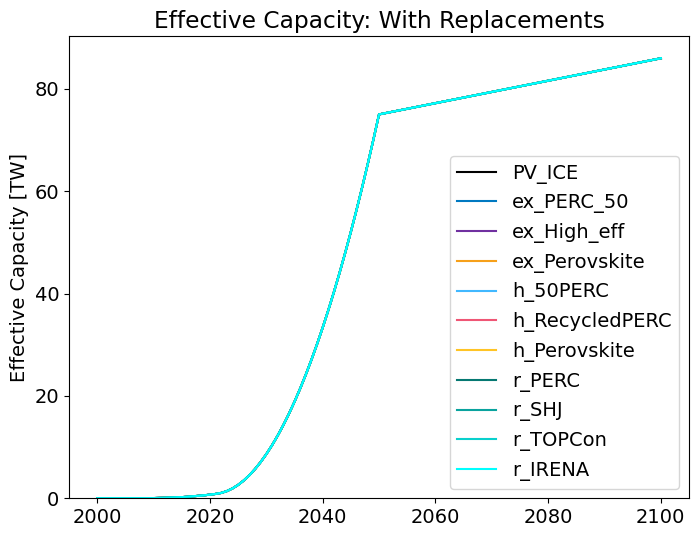

In [161]:
effective_capacity = cc_yearly.filter(like='ActiveCapacity')
plt.plot(effective_capacity/1e6)
plt.legend(sim1.scenario.keys())
plt.ylabel('Effective Capacity [TW]')
plt.title('Effective Capacity: With Replacements')
plt.ylim(0,)

(0.0, 329.87090864379934)

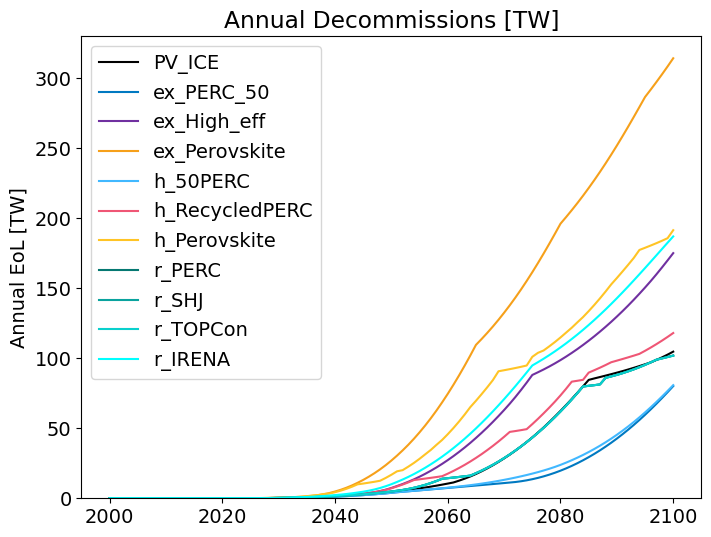

In [78]:
annual_EoL = cc_yearly.filter(like='DecommisionedCapacity')
plt.plot(annual_EoL/1e6)
plt.legend(sim1.scenario.keys())
plt.ylabel('Annual EoL [TW]')
plt.title('Annual Decommissions [TW]')
plt.ylim(0,)

(0.0, 8.61667530426398)

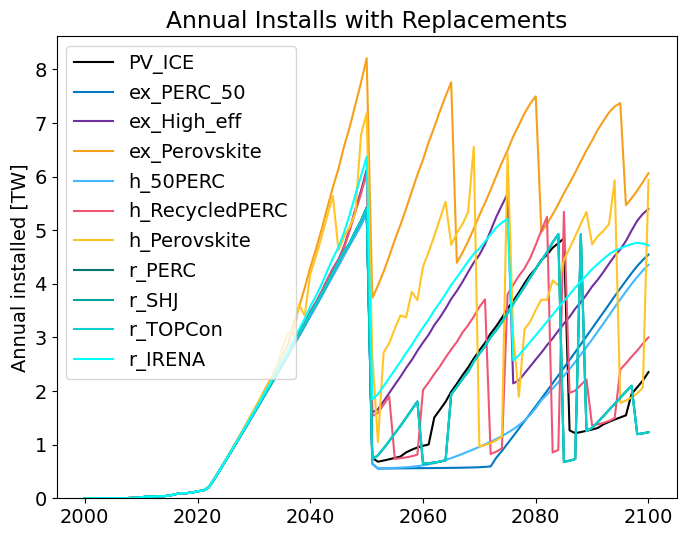

In [79]:
annual_installs = cc_yearly.filter(like='newInstalled')
plt.plot(annual_installs/1e6)
plt.legend(sim1.scenario.keys())
plt.ylabel('Annual installed [TW]')
plt.title('Annual Installs with Replacements')
plt.ylim(0,)

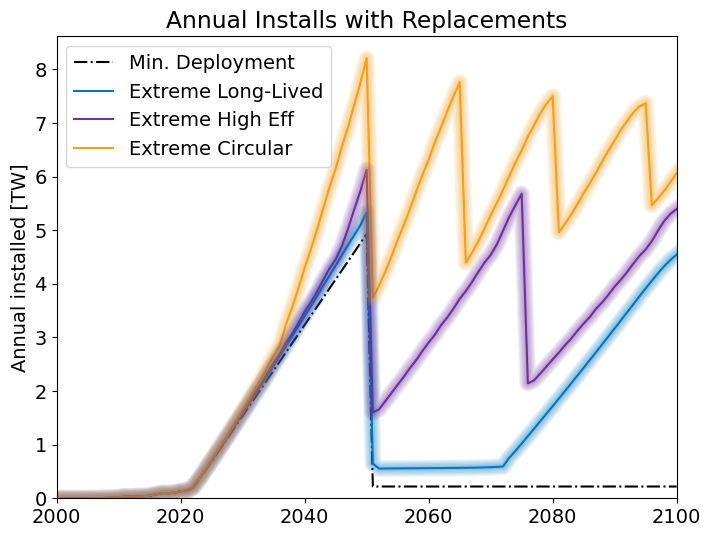

In [80]:
annual_installs_TW = cc_yearly.filter(like='newInstalled')/1e6

plt.plot(global_projection['World_annual_[MWdc]']/1e6, label='Min. Deployment', ls='dashdot')
plt.plot(annual_installs_TW.iloc[:,1:4], label = scennames_labels_flat[1:4])
#create glowlines for idealized scens
n_lines = 10
diff_linewidth = 1.05
alpha_value = 0.05
for n in range(1, n_lines+1):    
    plt.plot(annual_installs_TW.iloc[:,1],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[1])

for n in range(1, n_lines+1):    
    plt.plot(annual_installs_TW.iloc[:,2],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[2])

for n in range(1, n_lines+1):    
    plt.plot(annual_installs_TW.iloc[:,3],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[3])

plt.legend()
plt.ylabel('Annual installed [TW]')
plt.title('Annual Installs with Replacements')
plt.ylim(0,)
plt.xlim(2000,2100)

plt.savefig('energyresults-annualdeployment.png', dpi=300, bbox_inches='tight')

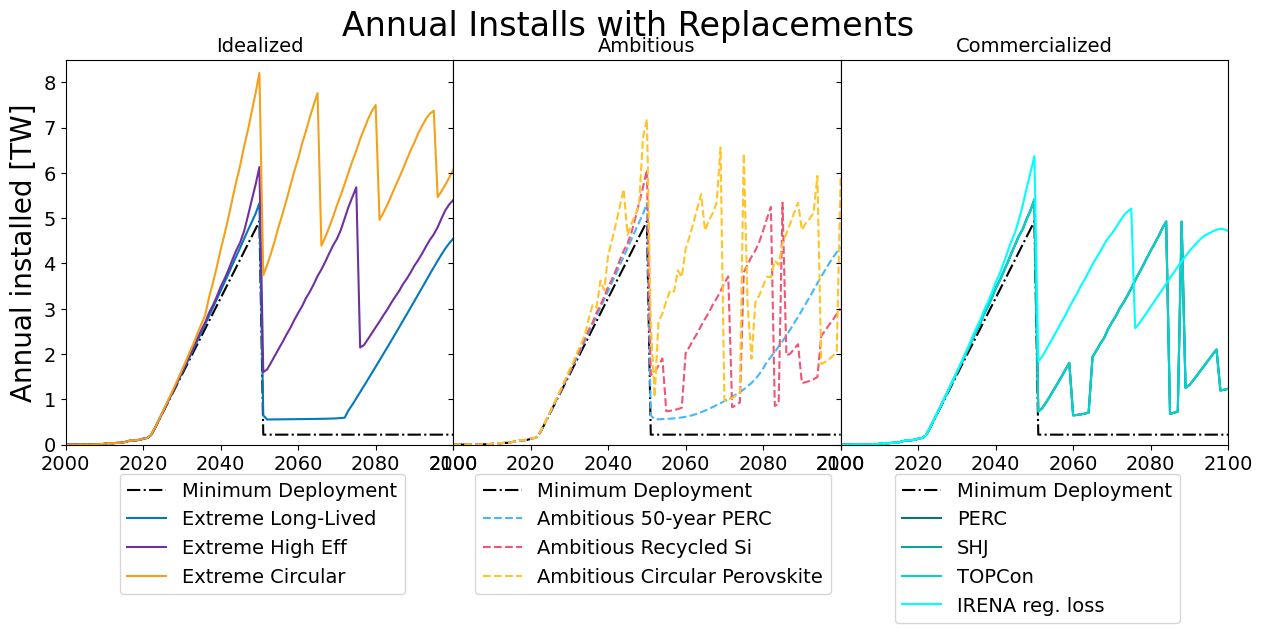

In [81]:
annual_installs_TW = cc_yearly.filter(like='newInstalled')/1e6

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5), sharey=True, sharex=True, 
                                      gridspec_kw={'wspace':0})
ax1.plot(global_projection['World_annual_[MWdc]']/1e6, label='Minimum Deployment', ls='dashdot')
ax1.set_prop_cycle(color=colorpalette[1:4])
ax1.plot(annual_installs_TW.iloc[:,1:4], label=scennames_labels_flat[1:4])# , color=colorpalette[1:4])
ax1.set_title('Idealized', fontsize=14)
ax1.set_ylabel('Annual installed [TW]', fontsize=20)
ax1.set_xlim(2000,2100)
ax1.set_ylim(0,8.5)
ax1.legend(bbox_to_anchor=(0.9,-0.05))

ax2.plot(global_projection['World_annual_[MWdc]']/1e6, label='Minimum Deployment', ls='dashdot')
ax2.set_prop_cycle(color=colorpalette[4:7])
ax2.plot(annual_installs_TW.iloc[:,4:7], label=scennames_labels_flat[4:7], ls='--') #, color=colorpalette[4:7])
ax2.set_title('Ambitious', fontsize=14)
ax2.legend(bbox_to_anchor=(1,-0.05))

ax3.plot(global_projection['World_annual_[MWdc]']/1e6, label='Minimum Deployment', ls='dashdot')
ax3.set_prop_cycle(color=colorpalette[7:11])
ax3.plot(annual_installs_TW.iloc[:,7:11], label=scennames_labels_flat[7:11])# , color=colorpalette[7:11])
ax3.set_title('Commercialized', fontsize=14)
ax3.legend(bbox_to_anchor=(0.9,-0.05))

fig.suptitle('Annual Installs with Replacements', fontsize=24)
plt.show()
fig.savefig('energyresults-annualInstalls.png', dpi=300, bbox_inches='tight')

#### Fixing Jagged Lines

In [82]:
posttransinstalls = annual_installs.loc[2051:,].cumsum()
flatinstallslate = posttransinstalls.loc[2100]/(2100-2050)
flatinstallslate

newInstalledCapacity_sim1_PV_ICE_[MW]            2.221055e+06
newInstalledCapacity_sim1_ex_PERC_50_[MW]        1.742914e+06
newInstalledCapacity_sim1_ex_High_eff_[MW]       3.572753e+06
newInstalledCapacity_sim1_ex_Perovskite_[MW]     5.963659e+06
newInstalledCapacity_sim1_h_50PERC_[MW]          1.756639e+06
newInstalledCapacity_sim1_h_RecycledPERC_[MW]    2.436506e+06
newInstalledCapacity_sim1_h_Perovskite_[MW]      3.711676e+06
newInstalledCapacity_sim1_r_PERC_[MW]            2.159963e+06
newInstalledCapacity_sim1_r_SHJ_[MW]             2.159963e+06
newInstalledCapacity_sim1_r_TOPCon_[MW]          2.159963e+06
newInstalledCapacity_sim1_r_IRENA_[MW]           3.757768e+06
Name: 2100, dtype: float64

In [83]:
annual_installs_modify = annual_installs.copy()
for col in annual_installs_modify:
    annual_installs_modify.loc[2051:,col] = flatinstallslate[col]

#annual_installs_modify
#plt.plot(annual_installs_modify)

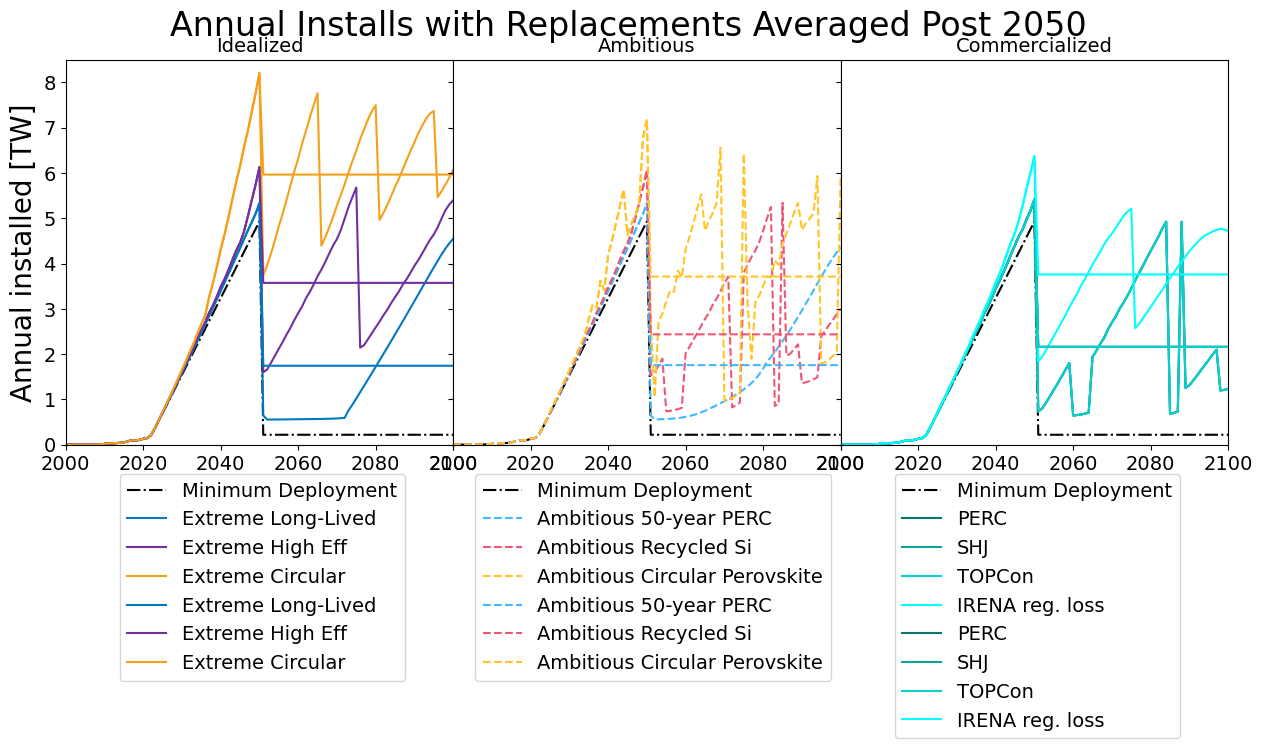

In [84]:
#annual_installs_TW = cc_yearly.filter(like='newInstalled')
annual_installs_modify_TW = annual_installs_modify/1e6

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5), sharey=True, sharex=True, 
                                      gridspec_kw={'wspace':0})
ax1.plot(global_projection['World_annual_[MWdc]']/1e6, label='Minimum Deployment', ls='dashdot')
ax1.set_prop_cycle(color=colorpalette[1:4])
ax1.plot(annual_installs_TW.iloc[:,1:4], label=scennames_labels_flat[1:4])# , color=colorpalette[1:4])
ax1.plot(annual_installs_modify_TW.iloc[:,1:4], label=scennames_labels_flat[1:4])# , color=colorpalette[1:4])
ax1.set_title('Idealized', fontsize=14)
ax1.set_ylabel('Annual installed [TW]', fontsize=20)
ax1.set_xlim(2000,2100)
ax1.set_ylim(0,8.5)
ax1.legend(bbox_to_anchor=(0.9,-0.05))

ax2.plot(global_projection['World_annual_[MWdc]']/1e6, label='Minimum Deployment', ls='dashdot')
ax2.set_prop_cycle(color=colorpalette[4:7])
ax2.plot(annual_installs_TW.iloc[:,4:7], label=scennames_labels_flat[4:7], ls='--')
ax2.plot(annual_installs_modify_TW.iloc[:,4:7], label=scennames_labels_flat[4:7], ls='--') #, color=colorpalette[4:7])
ax2.set_title('Ambitious', fontsize=14)
ax2.legend(bbox_to_anchor=(1,-0.05))

ax3.plot(global_projection['World_annual_[MWdc]']/1e6, label='Minimum Deployment', ls='dashdot')
ax3.set_prop_cycle(color=colorpalette[7:11])
ax3.plot(annual_installs_TW.iloc[:,7:11], label=scennames_labels_flat[7:11])
ax3.plot(annual_installs_modify_TW.iloc[:,7:11], label=scennames_labels_flat[7:11])# , color=colorpalette[7:11])
ax3.set_title('Commercialized', fontsize=14)
ax3.legend(bbox_to_anchor=(0.9,-0.05))

fig.suptitle('Annual Installs with Replacements Averaged Post 2050', fontsize=24)
plt.show()
fig.savefig('energyresults-annualInstalls-AVG.png', dpi=300, bbox_inches='tight')

In [85]:
#decade binning of post 2050 installs by decade
posttransinstalls_annual = annual_installs.loc[2051:,]
posttransinstalls_decades = posttransinstalls_annual.groupby(np.arange(len(posttransinstalls_annual))//10).sum()
posttransinstalls_decades.index = ['2051-2060','2061-2070','2071-2080','2081-2090','2091-2100']
posttransinstalls_decades
#this is the sum each decade, still need to divide by 10 for annual

newInstalledCapacity_sim1_PV_ICE_[MW]  \
2051-2060                           8.084245e+06   
2061-2070                           2.017992e+07   
2071-2080                           3.606240e+07   
2081-2090                           2.952406e+07   
2091-2100                           1.720211e+07   

           newInstalledCapacity_sim1_ex_PERC_50_[MW]  \
2051-2060                               5.666005e+06   
2061-2070                               5.692660e+06   
2071-2080                               1.102867e+07   
2081-2090                               2.509858e+07   
2091-2100                               3.965977e+07   

           newInstalledCapacity_sim1_ex_High_eff_[MW]  \
2051-2060                                2.208229e+07   
2061-2070                                3.796350e+07   
2071-2080                                3.783553e+07   
2081-2090                                3.325669e+07   
2091-2100                                4.749961e+07   

           newInstalledCapacity_sim1_ex_Perovskite_[MW]  \
2051-2060                                  4.982676e+07   
2061-2070                                  6.011196e+07   
2071-2080                                  6.575617e+07   
2081-2090                                  5.794755e+07   
2091-2100                                  6.454053e+07   

           newInstalledCapacity_sim1_h_50PERC_[MW]  \
2051-2060                             5.844223e+06   
2061-2070                             7.795488e+06   
2071-2080                             1.288077e+07   
2081-2090                             2.368093e+07   
2091-2100                             3.763053e+07   

           newInstalledCapacity_sim1_h_RecycledPERC_[MW]  \
2051-2060                                   1.263023e+07   
2061-2070                                   2.852800e+07   
2071-2080                                   3.175182e+07   
2081-2090                                   2.700252e+07   
2091-2100                                   2.191274e+07   

           newInstalledCapacity_sim1_h_Perovskite_[MW]  \
2051-2060                                 3.114650e+07   
2061-2070                                 4.786938e+07   
2071-2080                                 2.558590e+07   
2081-2090                                 4.462791e+07   
2091-2100                                 3.635409e+07   

           newInstalledCapacity_sim1_r_PERC_[MW]  \
2051-2060                           1.169165e+07   
2061-2070                           1.655666e+07   
2071-2080                           3.546531e+07   
2081-2090                           2.832288e+07   
2091-2100                           1.596166e+07   

           newInstalledCapacity_sim1_r_SHJ_[MW]  \
2051-2060                          1.169165e+07   
2061-2070                          1.655666e+07   
2071-2080                          3.546531e+07   
2081-2090                          2.832288e+07   
2091-2100                          1.596166e+07   

           newInstalledCapacity_sim1_r_TOPCon_[MW]  \
2051-2060                             1.169165e+07   
2061-2070                             1.655666e+07   
2071-2080                             3.546531e+07   
2081-2090                             2.832288e+07   
2091-2100                             1.596166e+07   

           newInstalledCapacity_sim1_r_IRENA_[MW]  
2051-2060                            2.483895e+07  
2061-2070                            4.030092e+07  
2071-2080                            3.909426e+07  
2081-2090                            3.731363e+07  
2091-2100                            4.634064e+07

In [86]:
annual_installs_decademod = annual_installs.copy()
for col in annual_installs_decademod:
    annual_installs_decademod.loc[2051:2060,col] = posttransinstalls_decades.loc['2051-2060',col]/10
    annual_installs_decademod.loc[2061:2070,col] = posttransinstalls_decades.loc['2061-2070',col]/10
    annual_installs_decademod.loc[2071:2080,col] = posttransinstalls_decades.loc['2071-2080',col]/10
    annual_installs_decademod.loc[2081:2090,col] = posttransinstalls_decades.loc['2081-2090',col]/10
    annual_installs_decademod.loc[2091:2100,col] = posttransinstalls_decades.loc['2091-2100',col]/10
    
#plt.plot(annual_installs_decademod)

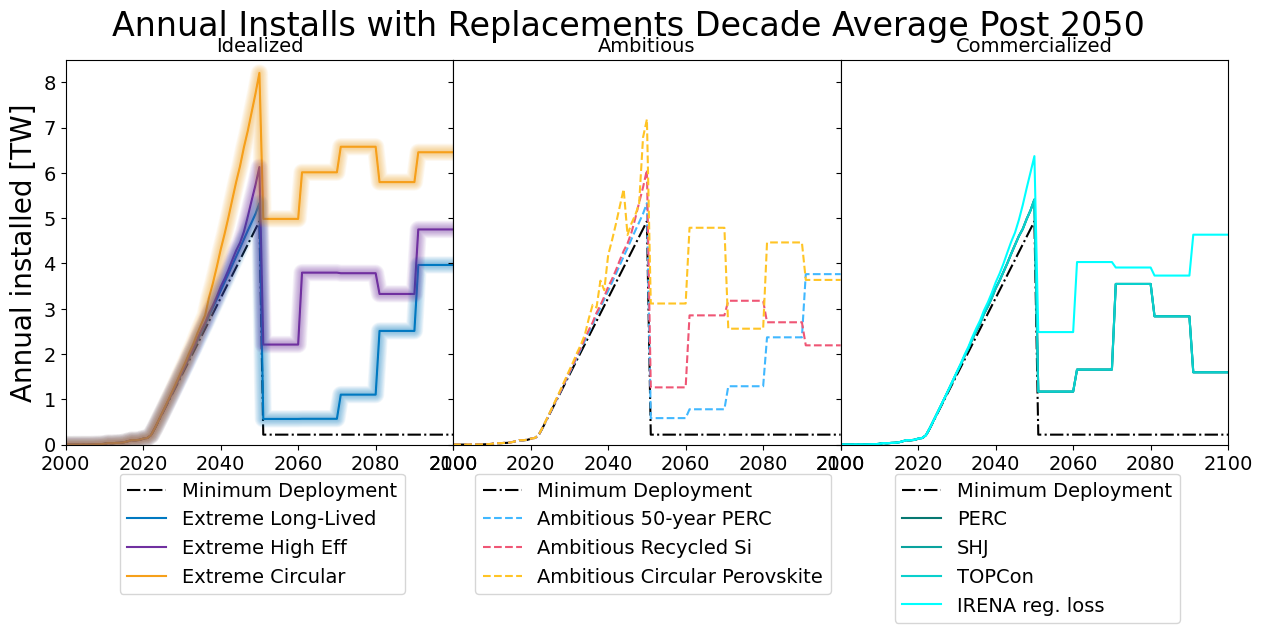

In [90]:
#annual_installs_TW = cc_yearly.filter(like='newInstalled')
annual_installs_decademod_TW = annual_installs_decademod/1e6

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5), sharey=True, sharex=True, 
                                      gridspec_kw={'wspace':0})
ax1.plot(global_projection['World_annual_[MWdc]']/1e6, label='Minimum Deployment', ls='dashdot')
ax1.set_prop_cycle(color=colorpalette[1:4])
#ax1.plot(annual_installs_TW.iloc[:,1:4], label=scennames_labels_flat[1:4])# , color=colorpalette[1:4])
ax1.plot(annual_installs_decademod_TW.iloc[:,1:4], label=scennames_labels_flat[1:4])# , color=colorpalette[1:4])

#create glowlines for idealized scens
n_lines = 10
diff_linewidth = 1.05
alpha_value = 0.05
for n in range(1, n_lines+1):    
    ax1.plot(annual_installs_decademod_TW.iloc[:,1],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[1])

for n in range(1, n_lines+1):    
    ax1.plot(annual_installs_decademod_TW.iloc[:,2],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[2])

for n in range(1, n_lines+1):    
    ax1.plot(annual_installs_decademod_TW.iloc[:,3],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[3])

ax1.set_title('Idealized', fontsize=14)
ax1.set_ylabel('Annual installed [TW]', fontsize=20)
ax1.set_xlim(2000,2100)
ax1.set_ylim(0,8.5)
ax1.legend(bbox_to_anchor=(0.9,-0.05))

ax2.plot(global_projection['World_annual_[MWdc]']/1e6, label='Minimum Deployment', ls='dashdot')
ax2.set_prop_cycle(color=colorpalette[4:7])
#ax2.plot(annual_installs_TW.iloc[:,4:7], label=scennames_labels_flat[4:7], ls='--')
ax2.plot(annual_installs_decademod_TW.iloc[:,4:7], label=scennames_labels_flat[4:7], ls='--') #, color=colorpalette[4:7])
ax2.set_title('Ambitious', fontsize=14)
ax2.legend(bbox_to_anchor=(1,-0.05))

ax3.plot(global_projection['World_annual_[MWdc]']/1e6, label='Minimum Deployment', ls='dashdot')
ax3.set_prop_cycle(color=colorpalette[7:11])
#ax3.plot(annual_installs_TW.iloc[:,7:11], label=scennames_labels_flat[7:11])
ax3.plot(annual_installs_decademod_TW.iloc[:,7:11], label=scennames_labels_flat[7:11])# , color=colorpalette[7:11])
ax3.set_title('Commercialized', fontsize=14)
ax3.legend(bbox_to_anchor=(0.9,-0.05))

fig.suptitle('Annual Installs with Replacements Decade Average Post 2050', fontsize=24)
plt.show()
fig.savefig('energyresults-annualInstalls-decade.png', dpi=300, bbox_inches='tight')

(0.0, 420.13516821034926)

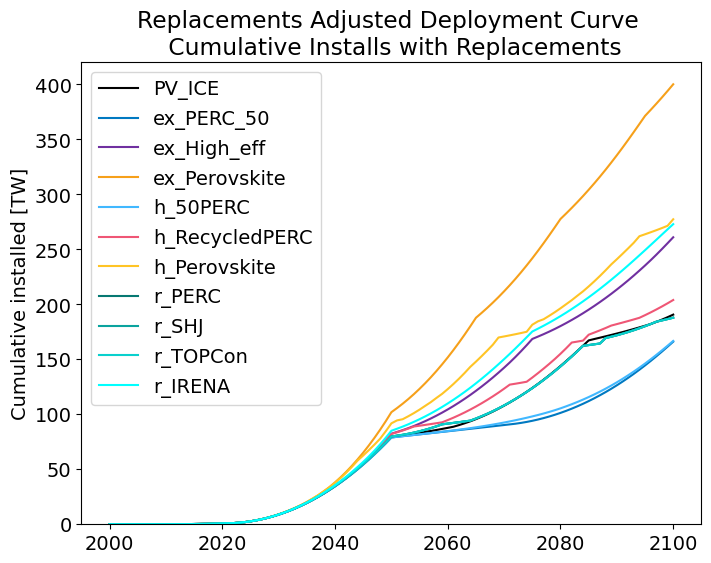

In [92]:
cumu_installs_annually = cc_cumu.filter(like='newInstalled')
plt.plot(cumu_installs_annually/1e6)
plt.legend(sim1.scenario.keys())
plt.ylabel('Cumulative installed [TW]')
plt.title('Replacements Adjusted Deployment Curve \n Cumulative Installs with Replacements')
plt.ylim(0,)

(0.0, 410.0)

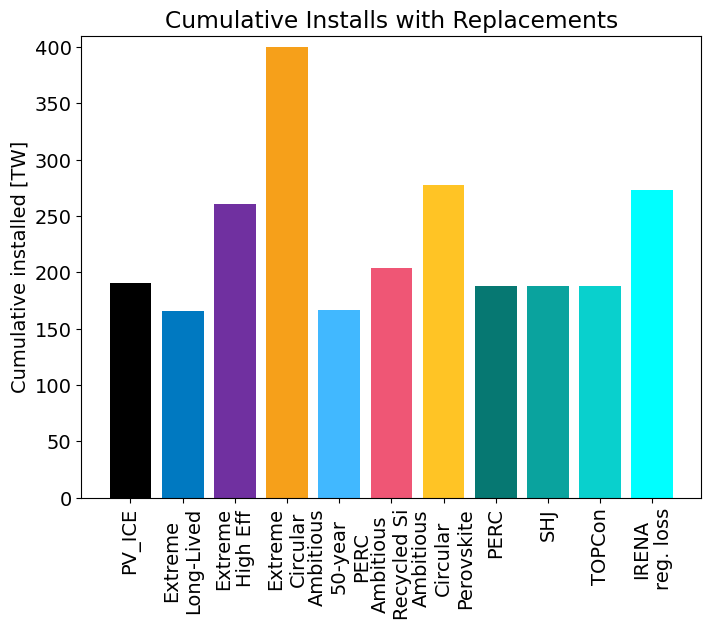

In [93]:
cumu_installs = cc_cumu.filter(like='newInstalled')
plt.bar(scennames_labels, cumu_installs.loc[2100]/1e6, tick_label=scennames_labels, color=colorpalette)
#plt.legend(scennames)
plt.xticks(rotation=90)
plt.ylabel('Cumulative installed [TW]')
plt.title('Cumulative Installs with Replacements')
plt.ylim(0,410)

In [94]:
replacements = cumu_installs.iloc[-1,]/1e6
replacements.index = scennames_labels

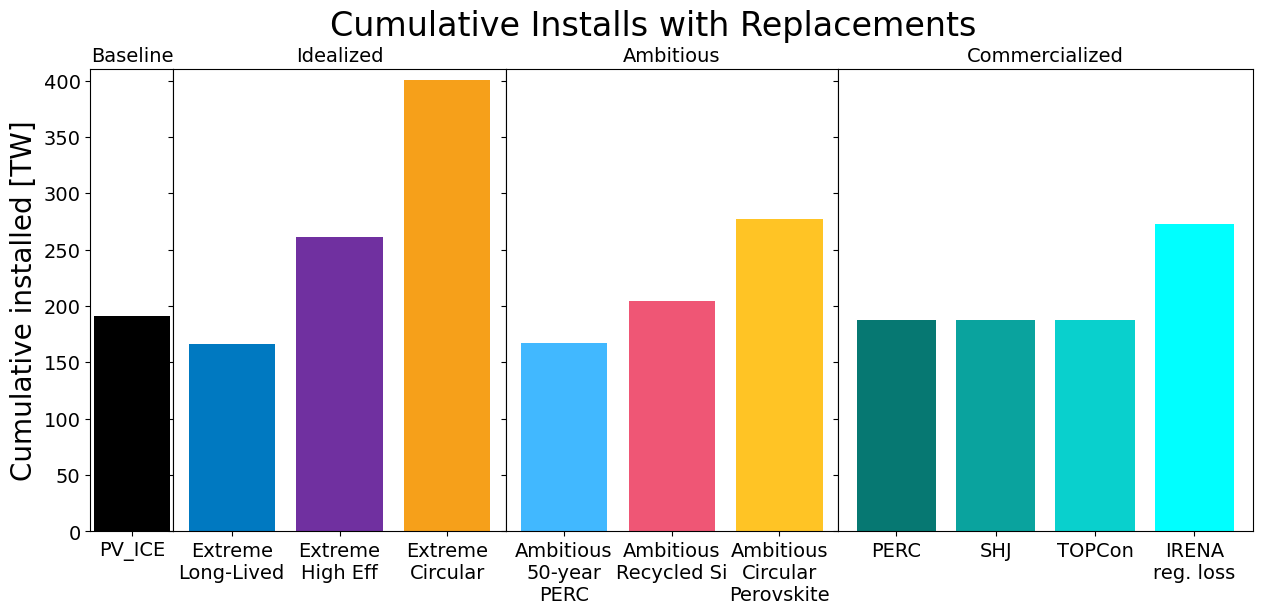

In [95]:
cumu_installs = cc_cumu.filter(like='newInstalled')

fig, (ax0,ax1,ax2,ax3) = plt.subplots(1,4,figsize=(15,6), sharey=True, 
                                      gridspec_kw={'wspace': 0, 'width_ratios': [0.5,2,2,2.5]})

ax0.bar(scennames_labels[0:1], cumu_installs.iloc[-1,0:1]/1e6, width=0.1, 
        tick_label=scennames_labels[0:1], color=colorpalette[0:1])
ax0.set_ylim(0,410)
ax0.set_ylabel('Cumulative installed [TW]', fontsize=20)
ax0.set_title('Baseline', fontsize=14)

ax1.bar(scennames_labels[1:4], cumu_installs.iloc[-1,1:4]/1e6, width=0.8, 
        tick_label=scennames_labels[1:4], color=colorpalette[1:4])
ax1.set_title('Idealized', fontsize=14)

ax2.bar(scennames_labels[4:7], cumu_installs.iloc[-1,4:7]/1e6, width=0.8,
        tick_label=scennames_labels[4:7], color=colorpalette[4:7])
ax2.set_title('Ambitious', fontsize=14)

ax3.bar(scennames_labels[7:11], cumu_installs.iloc[-1,7:11]/1e6, width=0.8,
        tick_label=scennames_labels[7:11], color=colorpalette[7:11])
ax3.set_title('Commercialized', fontsize=14)

fig.suptitle('Cumulative Installs with Replacements', fontsize=24)
plt.show()

fig.savefig('energyresults-cumulativedeploy.png', dpi=300, bbox_inches='tight')

cumu_installs = cc_cumu.filter(like='newInstalled')

fig = plt.subplots(figsize =(12, 8))

x = np.arange(len(scennames_labels))  # the label locations

plt.bar(x[0:4]-1, cumu_installs.iloc[-1,0:4]/1e6, tick_label=scennames_labels[0:4], color=colorpalette[0:4])

plt.bar(x[4:7], cumu_installs.iloc[-1,4:7]/1e6, tick_label=scennames_labels[4:7], color=colorpalette[4:7])

plt.bar(x[7:11]+1, cumu_installs.iloc[-1,7:11]/1e6, tick_label=scennames_labels[7:11], color=colorpalette[7:11])

plt.ylim(0,410)
plt.ylabel('Cumulative installed [TW]')
plt.title('Cumulative Installs with Replacements')
plt.xticks(rotation=90)

plt.show()

In [96]:
cumulative_nameplate_installs = global_projection.loc[2100,'World_cum'] #MW
print('The nameplate installations for energy transition and through 2100 are '+str(cumulative_nameplate_installs/1e6)+' TW.')

The nameplate installations for energy transition and through 2100 are 85.966 TW.


In [97]:
global_projection['World_annual_[MWdc]'].sum()

85966000.0

(0.0, 410.0)

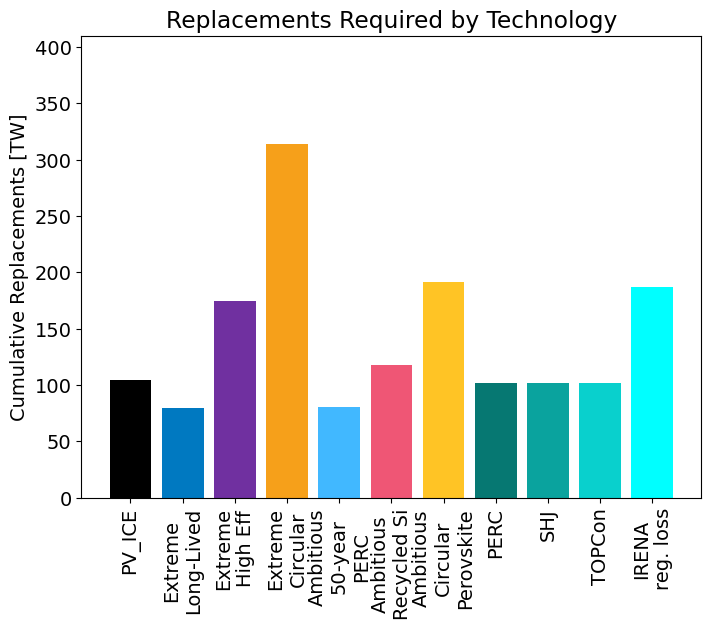

In [98]:
Additional_installs = cumu_installs.loc[2100]-global_projection.loc[2100,'World_cum']
plt.bar(scennames_labels, Additional_installs/1e6, tick_label=scennames_labels, color=colorpalette)
#plt.legend(scennames)
plt.ylabel('Cumulative Replacements [TW]')
plt.title('Replacements Required by Technology')
plt.xticks(rotation=90)
plt.ylim(0,410)

# RESULTS: Virgin Material Demands

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 [Text(0.0, 0, 'PV_ICE'),
  Text(1.0, 0, 'Extreme\nLong-Lived'),
  Text(2.0, 0, 'Extreme\nHigh Eff'),
  Text(3.0, 0, 'Extreme\nCircular'),
  Text(4.0, 0, 'Ambitious\n50-year\nPERC'),
  Text(5.0, 0, 'Ambitious\nRecycled Si'),
  Text(6.0, 0, 'Ambitious\nCircular\nPerovskite'),
  Text(7.0, 0, 'PERC'),
  Text(8.0, 0, 'SHJ'),
  Text(9.0, 0, 'TOPCon'),
  Text(10.0, 0, 'IRENA\nreg. loss')])

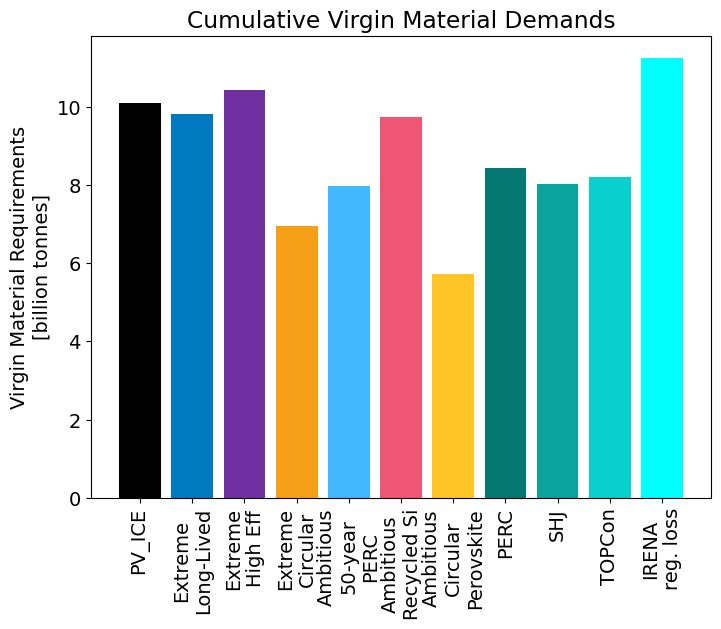

In [99]:
cumu_virgin_module = cc_cumu.filter(like='VirginStock_Module')
plt.bar(scennames_labels, cumu_virgin_module.loc[2100]/1e9, tick_label=scennames_labels, color=colorpalette)
#plt.legend(scennames)
plt.title('Cumulative Virgin Material Demands')
plt.ylabel('Virgin Material Requirements\n[billion tonnes]')
plt.xticks(rotation=90)

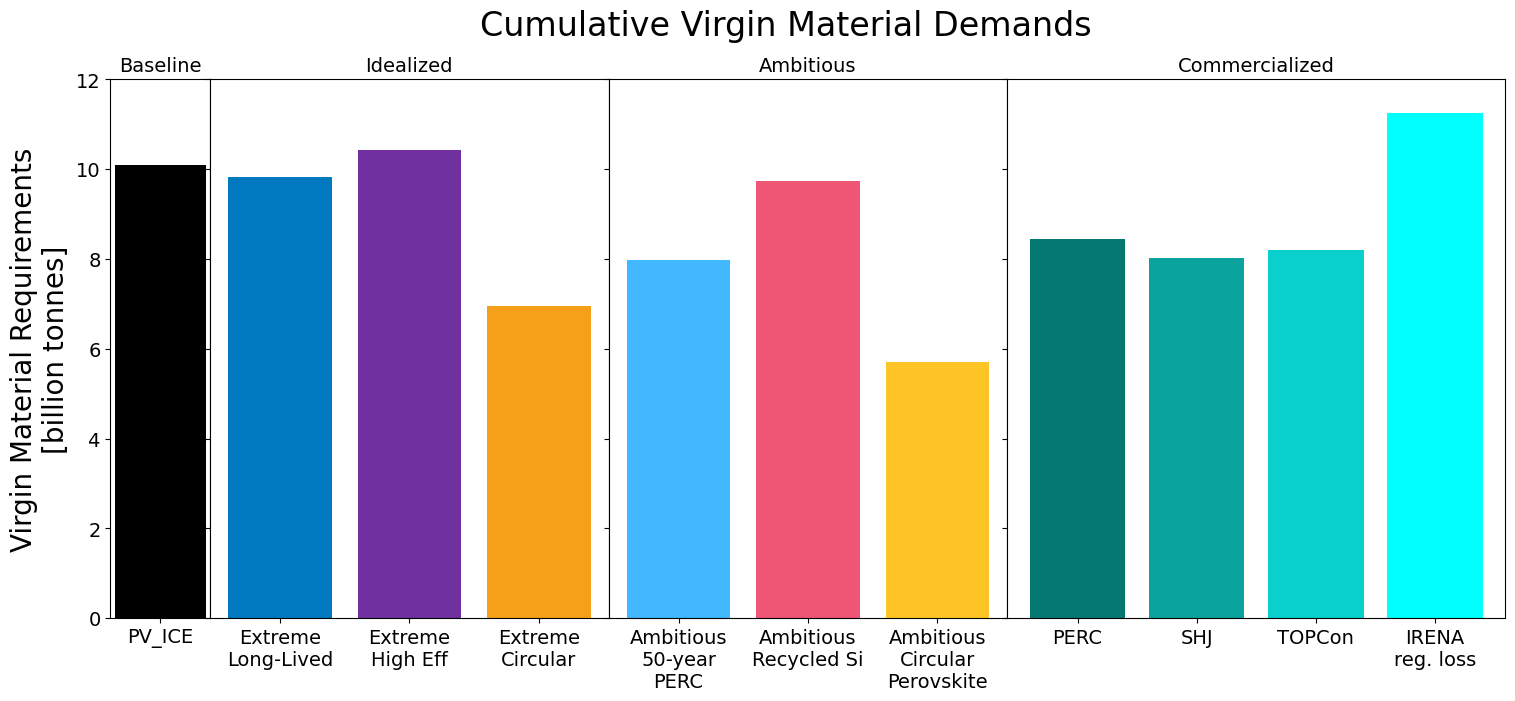

In [100]:
cumu_virgin_module_bt = cc_cumu.filter(like='VirginStock_Module')/1e9

fig, (ax0,ax1,ax2,ax3) = plt.subplots(1,4,figsize=(18,7), sharey=True, 
                                      gridspec_kw={'wspace': 0, 'width_ratios': [0.5,2,2,2.5]})

ax0.bar(scennames_labels[0:1], cumu_virgin_module_bt.iloc[-1,0:1], width=0.1, 
        tick_label=scennames_labels[0:1], color=colorpalette[0:1])
ax0.set_ylim(0,12)
ax0.set_ylabel('Virgin Material Requirements\n[billion tonnes]', fontsize=20)
ax0.set_title('Baseline', fontsize=14)

ax1.bar(scennames_labels[1:4], cumu_virgin_module_bt.iloc[-1,1:4], width=0.8, 
        tick_label=scennames_labels[1:4], color=colorpalette[1:4])
ax1.set_title('Idealized', fontsize=14)

ax2.bar(scennames_labels[4:7], cumu_virgin_module_bt.iloc[-1,4:7], width=0.8,
        tick_label=scennames_labels[4:7], color=colorpalette[4:7])
ax2.set_title('Ambitious', fontsize=14)

ax3.bar(scennames_labels[7:11], cumu_virgin_module_bt.iloc[-1,7:11], width=0.8,
        tick_label=scennames_labels[7:11], color=colorpalette[7:11])
ax3.set_title('Commercialized', fontsize=14)

fig.suptitle('Cumulative Virgin Material Demands', fontsize=24)
plt.show()

fig.savefig('energyresults-cumuMatDemand.png', dpi=300, bbox_inches='tight')

In [101]:
virgin = cumu_virgin_module_bt.iloc[-1,:]
virgin.index=scennames_labels

Text(0, 0.5, 'Million Metric tonnes')

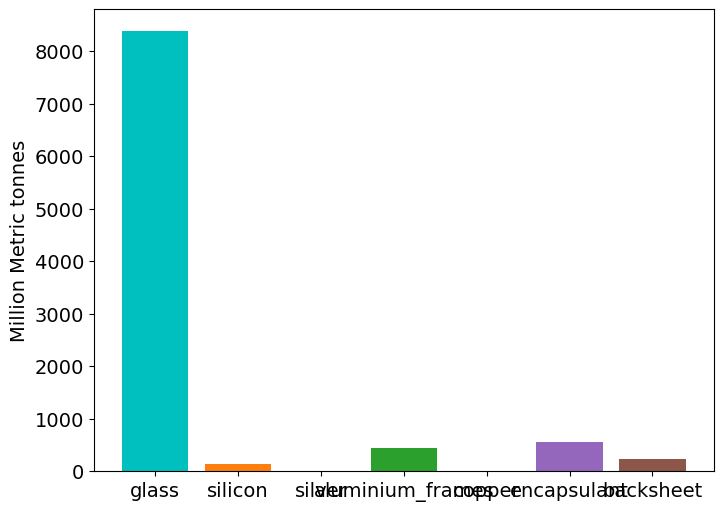

In [102]:
recycledperc_virginstock = cc_cumu.filter(like='VirginStock').filter(like='Recycled')
recycledperc_virginstock.drop('VirginStock_Module_sim1_h_RecycledPERC_[Tonnes]',axis=1, inplace=True)
plt.bar(recycledperc_virginstock.columns, recycledperc_virginstock.loc[2100]/1e6, tick_label = MATERIALS, color=colormats)
plt.ylabel('Million Metric tonnes')

(0.0, 11.815604480998033)

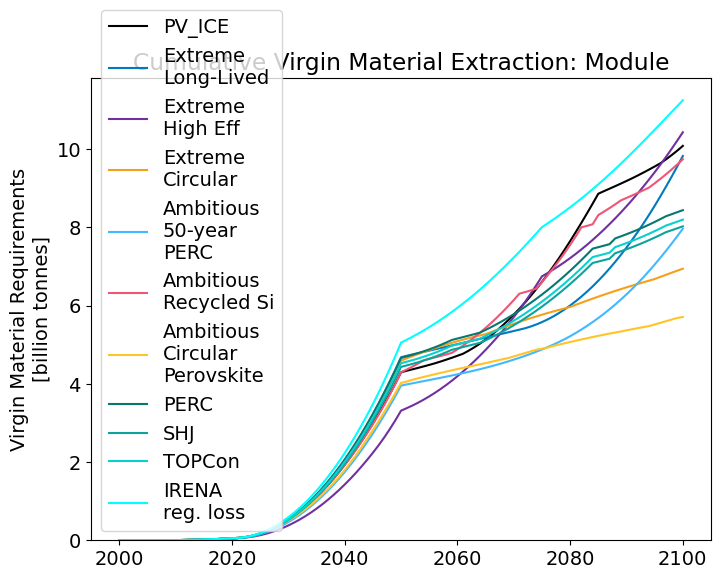

In [103]:
cumu_virgin_module = cc_cumu.filter(like='VirginStock_Module')
plt.plot(cumu_virgin_module/1e9)
plt.legend(scennames_labels)
plt.title('Cumulative Virgin Material Extraction: Module')
plt.ylabel('Virgin Material Requirements\n[billion tonnes]')
plt.ylim(0,)

(0.0, 357.5570213228335)

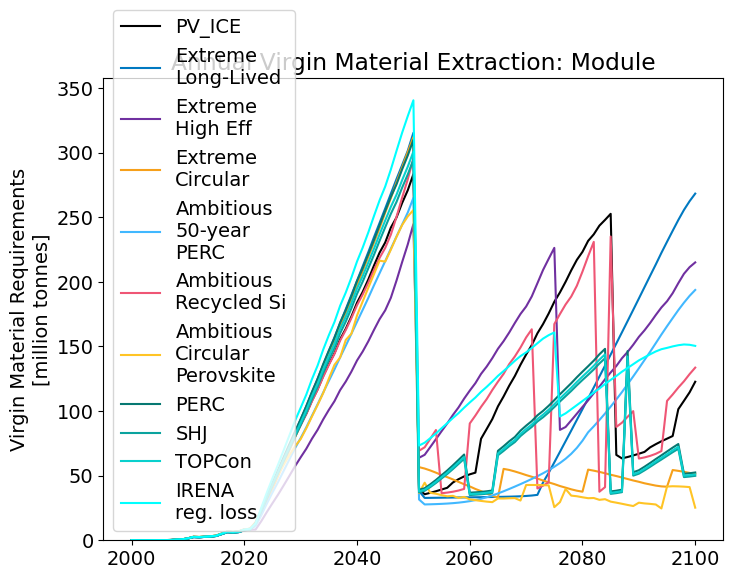

In [104]:
annual_virgin_module = cc_yearly.filter(like='VirginStock_Module')
plt.plot(annual_virgin_module/1e6)
plt.legend(scennames_labels)
plt.title('Annual Virgin Material Extraction: Module')
plt.ylabel('Virgin Material Requirements\n[million tonnes]')
plt.ylim(0,)

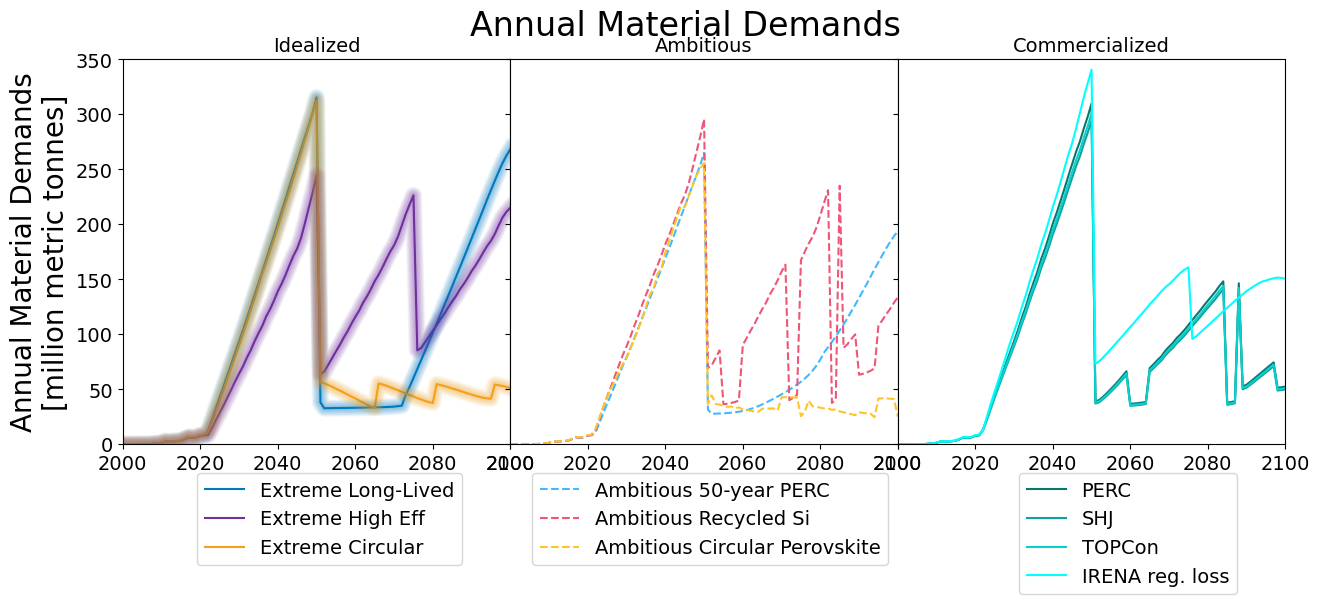

In [105]:
annual_virgin_module_mt = annual_virgin_module/1e6

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5), sharey=True, sharex=True, 
                                      gridspec_kw={'wspace':0})
#ax1.plot(global_projection['World_annual_[MWdc]']/1e6, label='Minimum Deployment', ls='dashdot')
ax1.set_prop_cycle(color=colorpalette[1:4])
ax1.plot(annual_virgin_module_mt.iloc[:,1:4], label=scennames_labels_flat[1:4])# , color=colorpalette[1:4])

#create glowlines for idealized scens
n_lines = 10
diff_linewidth = 1.05
alpha_value = 0.05
for n in range(1, n_lines+1):    
    ax1.plot(annual_virgin_module_mt.iloc[:,1],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[1])

for n in range(1, n_lines+1):    
    ax1.plot(annual_virgin_module_mt.iloc[:,2],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[2])

for n in range(1, n_lines+1):    
    ax1.plot(annual_virgin_module_mt.iloc[:,3],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[3])

ax1.set_title('Idealized', fontsize=14)
ax1.set_ylabel('Annual Material Demands\n[million metric tonnes]', fontsize=20)
ax1.set_xlim(2000,2100)
ax1.set_ylim(0,350)
ax1.legend(bbox_to_anchor=(0.9,-0.05))

#ax2.plot(global_projection['World_annual_[MWdc]']/1e6, label='Minimum Deployment', ls='dashdot')
ax2.set_prop_cycle(color=colorpalette[4:7])
ax2.plot(annual_virgin_module_mt.iloc[:,4:7], label=scennames_labels_flat[4:7], ls='--') #, color=colorpalette[4:7])
ax2.set_title('Ambitious', fontsize=14)
ax2.legend(bbox_to_anchor=(1,-0.05))

#ax3.plot(global_projection['World_annual_[MWdc]']/1e6, label='Minimum Deployment', ls='dashdot')
ax3.set_prop_cycle(color=colorpalette[7:11])
ax3.plot(annual_virgin_module_mt.iloc[:,7:11], label=scennames_labels_flat[7:11])# , color=colorpalette[7:11])
ax3.set_title('Commercialized', fontsize=14)
ax3.legend(bbox_to_anchor=(0.9,-0.05))

fig.suptitle('Annual Material Demands', fontsize=24)
plt.show()
fig.savefig('energyresults-annualMatDemands.png', dpi=300, bbox_inches='tight')

In [106]:
#do it by decade to match up with annual installs graphs
virgin_module_annual = annual_virgin_module.loc[2051:,]
virgin_module_decades = virgin_module_annual.groupby(np.arange(len(virgin_module_annual))//10).sum()
virgin_module_decades.index = ['2051-2060','2061-2070','2071-2080','2081-2090','2091-2100']
virgin_module_decades
#this is the sum each decade, still need to divide by 10 for annual

VirginStock_Module_sim1_PV_ICE_[Tonnes]  \
2051-2060                             4.220275e+08   
2061-2070                             1.052121e+09   
2071-2080                             1.879663e+09   
2081-2090                             1.539121e+09   
2091-2100                             8.971855e+08   

           VirginStock_Module_sim1_ex_PERC_50_[Tonnes]  \
2051-2060                                 3.352095e+08   
2061-2070                                 3.368010e+08   
2071-2080                                 6.516744e+08   
2081-2090                                 1.481997e+09   
2091-2100                                 2.341286e+09   

           VirginStock_Module_sim1_ex_High_eff_[Tonnes]  \
2051-2060                                  8.804683e+08   
2061-2070                                  1.513117e+09   
2071-2080                                  1.508035e+09   
2081-2090                                  1.325661e+09   
2091-2100                                  1.893029e+09   

           VirginStock_Module_sim1_ex_Perovskite_[Tonnes]  \
2051-2060                                    4.952477e+08   
2061-2070                                    4.466704e+08   
2071-2080                                    4.296153e+08   
2081-2090                                    5.013477e+08   
2091-2100                                    4.772295e+08   

           VirginStock_Module_sim1_h_50PERC_[Tonnes]  \
2051-2060                               2.895188e+08   
2061-2070                               3.754950e+08   
2071-2080                               5.984333e+08   
2081-2090                               1.070696e+09   
2091-2100                               1.679661e+09   

           VirginStock_Module_sim1_h_RecycledPERC_[Tonnes]  \
2051-2060                                     5.847210e+08   
2061-2070                                     1.261661e+09   
2071-2080                                     1.409047e+09   
2081-2090                                     1.202020e+09   
2091-2100                                     9.895179e+08   

           VirginStock_Module_sim1_h_Perovskite_[Tonnes]  \
2051-2060                                   3.552753e+08   
2061-2070                                   3.242539e+08   
2071-2080                                   3.675362e+08   
2081-2090                                   2.986008e+08   
2091-2100                                   3.420519e+08   

           VirginStock_Module_sim1_r_PERC_[Tonnes]  \
2051-2060                             4.970195e+08   
2061-2070                             6.230063e+08   
2071-2080                             1.110113e+09   
2081-2090                             9.343835e+08   
2091-2100                             6.160021e+08   

           VirginStock_Module_sim1_r_SHJ_[Tonnes]  \
2051-2060                            4.723163e+08   
2061-2070                            5.922935e+08   
2071-2080                            1.055385e+09   
2081-2090                            8.883211e+08   
2091-2100                            5.856363e+08   

           VirginStock_Module_sim1_r_TOPCon_[Tonnes]  \
2051-2060                               4.823976e+08   
2061-2070                               6.049473e+08   
2071-2080                               1.077932e+09   
2081-2090                               9.072984e+08   
2091-2100                               5.981472e+08   

           VirginStock_Module_sim1_r_IRENA_[Tonnes]  
2051-2060                              8.900923e+08  
2061-2070                              1.286893e+09  
2071-2080                              1.284840e+09  
2081-2090                              1.254326e+09  
2091-2100                              1.482761e+09

In [107]:
annual_virgin_module_decademod = annual_virgin_module.copy()
for col in annual_virgin_module_decademod:
    annual_virgin_module_decademod.loc[2051:2060,col] = virgin_module_decades.loc['2051-2060',col]/10
    annual_virgin_module_decademod.loc[2061:2070,col] = virgin_module_decades.loc['2061-2070',col]/10
    annual_virgin_module_decademod.loc[2071:2080,col] = virgin_module_decades.loc['2071-2080',col]/10
    annual_virgin_module_decademod.loc[2081:2090,col] = virgin_module_decades.loc['2081-2090',col]/10
    annual_virgin_module_decademod.loc[2091:2100,col] = virgin_module_decades.loc['2091-2100',col]/10
    
#plt.plot(annual_virgin_module_decademod)

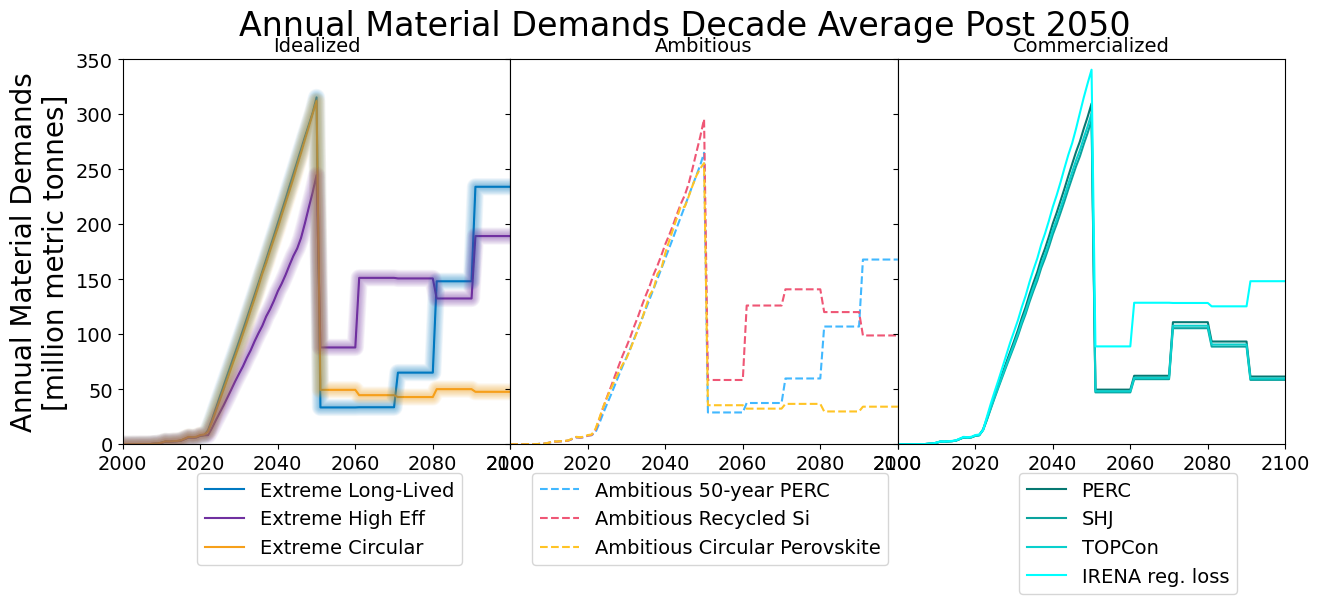

In [156]:
annual_virgin_module_decademod_mt = annual_virgin_module_decademod/1e6

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5), sharey=True, sharex=True, 
                                      gridspec_kw={'wspace':0})
#ax1.plot(global_projection['World_annual_[MWdc]']/1e6, label='Minimum Deployment', ls='dashdot')
ax1.set_prop_cycle(color=colorpalette[1:4])
ax1.plot(annual_virgin_module_decademod_mt.iloc[:,1:4], label=scennames_labels_flat[1:4])# , color=colorpalette[1:4])

#create glowlines for idealized scens
n_lines = 10
diff_linewidth = 1.05
alpha_value = 0.05
for n in range(1, n_lines+1):    
    ax1.plot(annual_virgin_module_decademod_mt.iloc[:,1],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[1])

for n in range(1, n_lines+1):    
    ax1.plot(annual_virgin_module_decademod_mt.iloc[:,2],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[2])

for n in range(1, n_lines+1):    
    ax1.plot(annual_virgin_module_decademod_mt.iloc[:,3],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[3])

ax1.set_title('Idealized', fontsize=14)
ax1.set_ylabel('Annual Material Demands\n[million metric tonnes]', fontsize=20)
ax1.set_xlim(2000,2100)
ax1.set_ylim(0,350)
ax1.legend(bbox_to_anchor=(0.9,-0.05))

#ax2.plot(global_projection['World_annual_[MWdc]']/1e6, label='Minimum Deployment', ls='dashdot')
ax2.set_prop_cycle(color=colorpalette[4:7])
ax2.plot(annual_virgin_module_decademod_mt.iloc[:,4:7], label=scennames_labels_flat[4:7], ls='--') #, color=colorpalette[4:7])
ax2.set_title('Ambitious', fontsize=14)
ax2.legend(bbox_to_anchor=(1,-0.05))

#ax3.plot(global_projection['World_annual_[MWdc]']/1e6, label='Minimum Deployment', ls='dashdot')
ax3.set_prop_cycle(color=colorpalette[7:11])
ax3.plot(annual_virgin_module_decademod_mt.iloc[:,7:11], label=scennames_labels_flat[7:11])# , color=colorpalette[7:11])
ax3.set_title('Commercialized', fontsize=14)
ax3.legend(bbox_to_anchor=(0.9,-0.05))

fig.suptitle('Annual Material Demands Decade Average Post 2050', fontsize=24)
plt.show()
fig.savefig('energyresults-annualMatDemands-decade.png', dpi=300, bbox_inches='tight')

In [111]:
#print out masses for stacked bar charts
#mass_cumu = cc_cumu.loc[[2100]].filter(like='PV_ICE_[Tonnes]')
mass_cumu_virgin = cc_cumu.filter(like='VirginStock').loc[2100]
mass_cumu_wasteall = cc_cumu.filter(like='WasteAll').loc[2100]
mass_cumu = pd.concat([mass_cumu_virgin,mass_cumu_wasteall])
mass_cumu.to_csv(os.path.join(testfolder, 'cc_cumu_mass_2100results.csv'))

In [112]:
cc_cumu.to_csv(os.path.join(testfolder, 'cc_cumu_mass_results.csv'))

# RESULTS: Lifecycle Wastes

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 [Text(0.0, 0, 'PV_ICE'),
  Text(1.0, 0, 'Extreme\nLong-Lived'),
  Text(2.0, 0, 'Extreme\nHigh Eff'),
  Text(3.0, 0, 'Extreme\nCircular'),
  Text(4.0, 0, 'Ambitious\n50-year\nPERC'),
  Text(5.0, 0, 'Ambitious\nRecycled Si'),
  Text(6.0, 0, 'Ambitious\nCircular\nPerovskite'),
  Text(7.0, 0, 'PERC'),
  Text(8.0, 0, 'SHJ'),
  Text(9.0, 0, 'TOPCon'),
  Text(10.0, 0, 'IRENA\nreg. loss')])

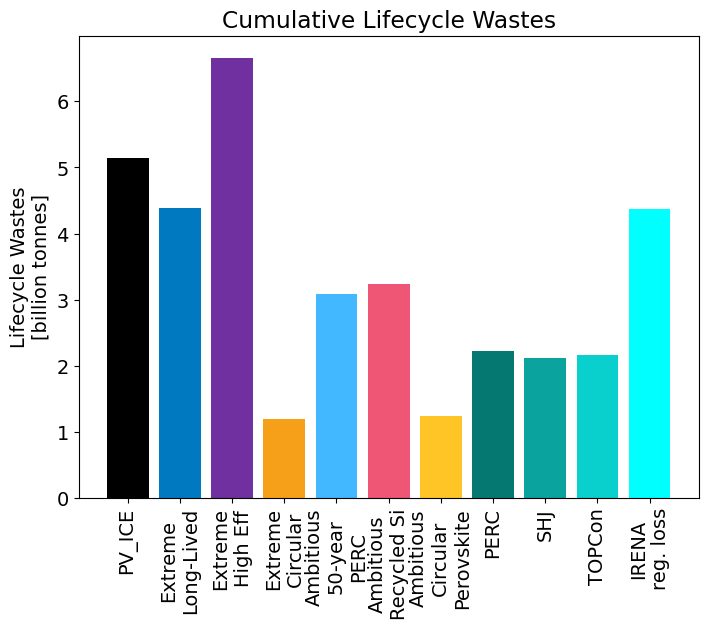

In [157]:
cumu_lifecycle_wastes = cc_cumu.filter(like='WasteAll_Module')

plt.bar(scennames_labels, cumu_lifecycle_wastes.loc[2100]/1e9, 
        tick_label=scennames_labels, color=colorpalette)
#plt.legend(scennames)
plt.title('Cumulative Lifecycle Wastes')
plt.ylabel('Lifecycle Wastes\n[billion tonnes]')
plt.xticks(rotation=90)

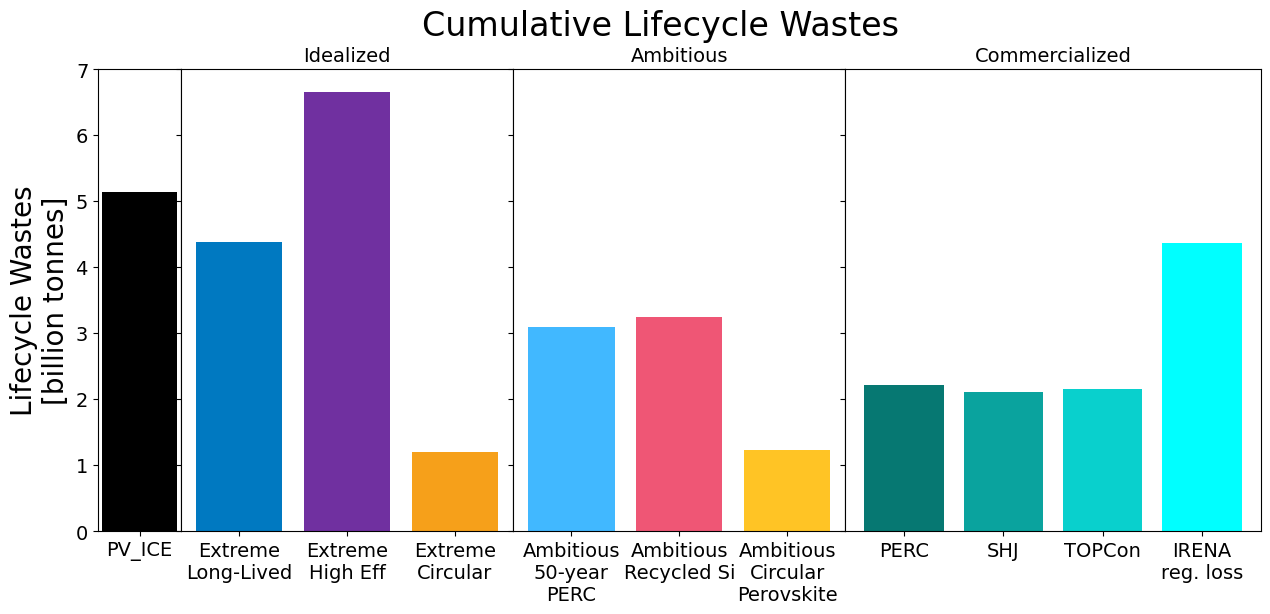

In [158]:
cumu_lifecycle_wastes_bt = cc_cumu.filter(like='WasteAll_Module')/1e9

fig, (ax0,ax1,ax2,ax3) = plt.subplots(1,4,figsize=(15,6), sharey=True, 
                                      gridspec_kw={'wspace': 0, 'width_ratios': [0.5,2,2,2.5]})

ax0.bar(scennames_labels[0:1], cumu_lifecycle_wastes_bt.iloc[-1,0:1], width=0.1, 
        tick_label=scennames_labels[0:1], color=colorpalette[0:1])
ax0.set_ylim(0,7)
ax0.set_ylabel('Lifecycle Wastes\n[billion tonnes]', fontsize=20)
#ax0.set_title('Baseline', fontsize=14)

ax1.bar(scennames_labels[1:4], cumu_lifecycle_wastes_bt.iloc[-1,1:4], width=0.8, 
        tick_label=scennames_labels[1:4], color=colorpalette[1:4])
ax1.set_title('Idealized', fontsize=14)

ax2.bar(scennames_labels[4:7], cumu_lifecycle_wastes_bt.iloc[-1,4:7], width=0.8,
        tick_label=scennames_labels[4:7], color=colorpalette[4:7])
ax2.set_title('Ambitious', fontsize=14)

ax3.bar(scennames_labels[7:11], cumu_lifecycle_wastes_bt.iloc[-1,7:11], width=0.8,
        tick_label=scennames_labels[7:11], color=colorpalette[7:11])
ax3.set_title('Commercialized', fontsize=14)

fig.suptitle('Cumulative Lifecycle Wastes', fontsize=24)
plt.show()

fig.savefig('energyresults-cumuWaste.png', dpi=300, bbox_inches='tight')

In [159]:
wastes = cumu_lifecycle_wastes_bt.iloc[-1,:]
wastes.index=scennames_labels

(0.0, 297.3535841775627)

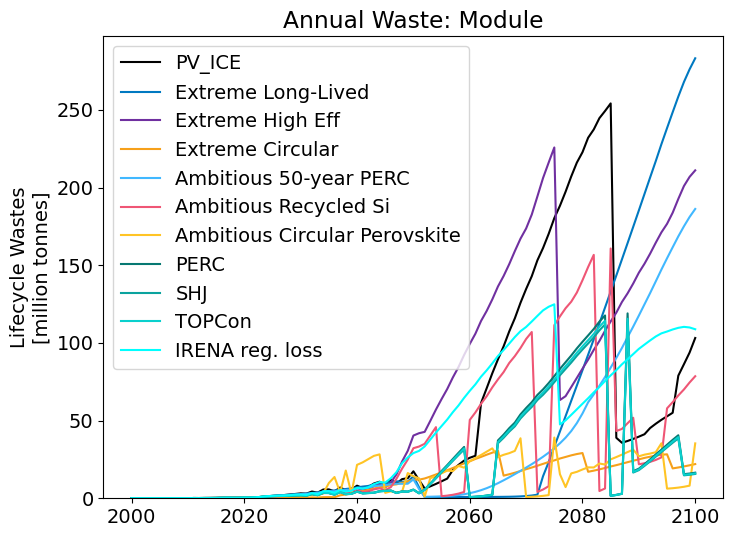

In [160]:
annual_waste_module = cc_yearly.filter(like='WasteAll_Module')
plt.plot(annual_waste_module/1e6)
plt.legend(scennames_labels_flat)
plt.title('Annual Waste: Module')
plt.ylabel('Lifecycle Wastes\n[million tonnes]')
plt.ylim(0,)

In [165]:
#do it by decade to match up with annual installs graphs
waste_module_annual = annual_waste_module.loc[2051:,]
waste_module_decades = waste_module_annual.groupby(np.arange(len(waste_module_annual))//10).sum()
waste_module_decades.index = ['2051-2060','2061-2070','2071-2080','2081-2090','2091-2100']
waste_module_decades
#this is the sum each decade, still need to divide by 10 for annual

WasteAll_Module_sim1_PV_ICE_[Tonnes]  \
2051-2060                          1.486041e+08   
2061-2070                          9.108933e+08   
2071-2080                          1.839154e+09   
2081-2090                          1.406897e+09   
2091-2100                          6.548639e+08   

           WasteAll_Module_sim1_ex_PERC_50_[Tonnes]  \
2051-2060                              1.462062e+07   
2061-2070                              9.974609e+06   
2071-2080                              3.884334e+08   
2081-2090                              1.384573e+09   
2091-2100                              2.419842e+09   

           WasteAll_Module_sim1_ex_High_eff_[Tonnes]  \
2051-2060                               6.795590e+08   
2061-2070                               1.398512e+09   
2071-2080                               1.386332e+09   
2081-2090                               1.168739e+09   
2091-2100                               1.816059e+09   

           WasteAll_Module_sim1_ex_Perovskite_[Tonnes]  \
2051-2060                                 1.755806e+08   
2061-2070                                 2.227167e+08   
2071-2080                                 2.480160e+08   
2081-2090                                 2.094352e+08   
2091-2100                                 2.392993e+08   

           WasteAll_Module_sim1_h_50PERC_[Tonnes]  \
2051-2060                            2.110527e+07   
2061-2070                            1.115302e+08   
2071-2080                            3.551446e+08   
2081-2090                            8.820037e+08   
2091-2100                            1.570645e+09   

           WasteAll_Module_sim1_h_RecycledPERC_[Tonnes]  \
2051-2060                                  2.173515e+08   
2061-2070                                  7.886247e+08   
2071-2080                                  8.745056e+08   
2081-2090                                  6.872162e+08   
2091-2100                                  5.059967e+08   

           WasteAll_Module_sim1_h_Perovskite_[Tonnes]  \
2051-2060                                1.569263e+08   
2061-2070                                2.692754e+08   
2071-2080                                1.190790e+08   
2081-2090                                2.515142e+08   
2091-2100                                1.922708e+08   

           WasteAll_Module_sim1_r_PERC_[Tonnes]  \
2051-2060                          1.591274e+08   
2061-2070                          2.904409e+08   
2071-2080                          8.111384e+08   
2081-2090                          6.074605e+08   
2091-2100                          2.669655e+08   

           WasteAll_Module_sim1_r_SHJ_[Tonnes]  \
2051-2060                         1.514539e+08   
2061-2070                         2.761168e+08   
2071-2080                         7.711336e+08   
2081-2090                         5.775001e+08   
2091-2100                         2.537985e+08   

           WasteAll_Module_sim1_r_TOPCon_[Tonnes]  \
2051-2060                            1.546980e+08   
2061-2070                            2.820156e+08   
2071-2080                            7.876082e+08   
2081-2090                            5.898383e+08   
2091-2100                            2.592208e+08   

           WasteAll_Module_sim1_r_IRENA_[Tonnes]  
2051-2060                           4.900470e+08  
2061-2070                           9.288846e+08  
2071-2080                           8.696334e+08  
2081-2090                           8.058851e+08  
2091-2100                           1.065501e+09

In [166]:
annual_waste_module_decademod = annual_waste_module.copy()
for col in annual_waste_module_decademod:
    annual_waste_module_decademod.loc[2051:2060,col] = waste_module_decades.loc['2051-2060',col]/10
    annual_waste_module_decademod.loc[2061:2070,col] = waste_module_decades.loc['2061-2070',col]/10
    annual_waste_module_decademod.loc[2071:2080,col] = waste_module_decades.loc['2071-2080',col]/10
    annual_waste_module_decademod.loc[2081:2090,col] = waste_module_decades.loc['2081-2090',col]/10
    annual_waste_module_decademod.loc[2091:2100,col] = waste_module_decades.loc['2091-2100',col]/10
    
#plt.plot(annual_virgin_module_decademod)

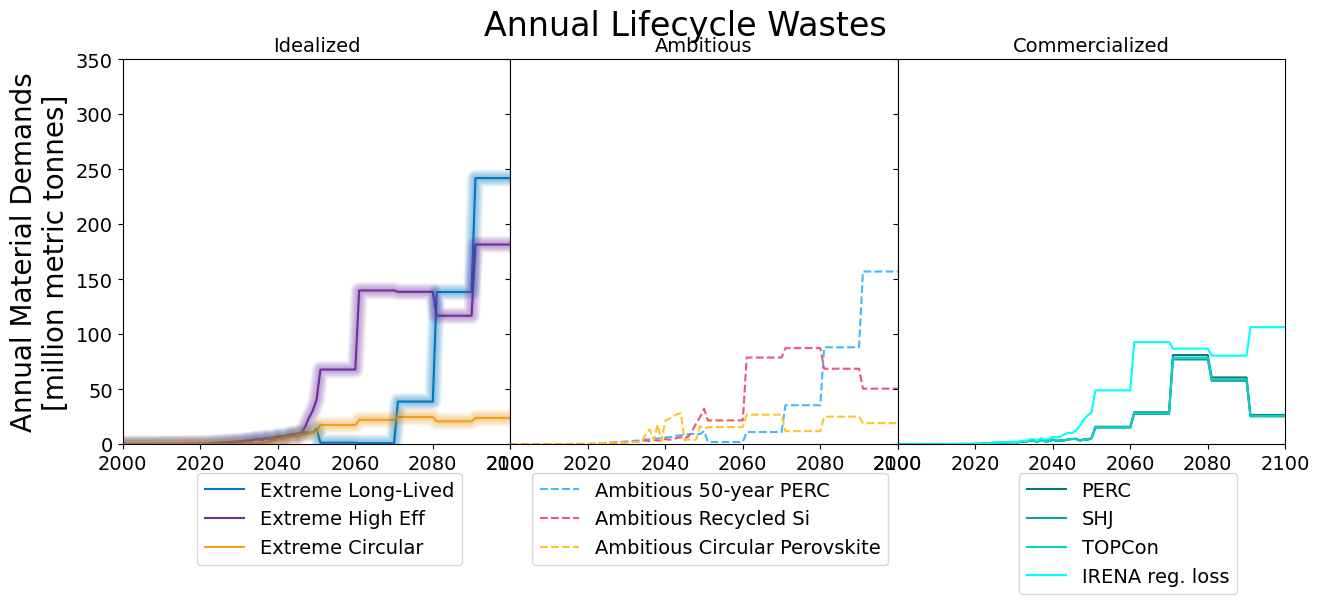

In [167]:
annual_waste_module_decademod_mt = annual_waste_module_decademod/1e6

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5), sharey=True, sharex=True, 
                                      gridspec_kw={'wspace':0})
#ax1.plot(global_projection['World_annual_[MWdc]']/1e6, label='Minimum Deployment', ls='dashdot')
ax1.set_prop_cycle(color=colorpalette[1:4])
ax1.plot(annual_waste_module_decademod_mt.iloc[:,1:4], label=scennames_labels_flat[1:4])# , color=colorpalette[1:4])

#create glowlines for idealized scens
n_lines = 10
diff_linewidth = 1.05
alpha_value = 0.05
for n in range(1, n_lines+1):    
    ax1.plot(annual_waste_module_decademod_mt.iloc[:,1],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[1])

for n in range(1, n_lines+1):    
    ax1.plot(annual_waste_module_decademod_mt.iloc[:,2],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[2])

for n in range(1, n_lines+1):    
    ax1.plot(annual_waste_module_decademod_mt.iloc[:,3],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[3])

ax1.set_title('Idealized', fontsize=14)
ax1.set_ylabel('Annual Material Demands\n[million metric tonnes]', fontsize=20)
ax1.set_xlim(2000,2100)
ax1.set_ylim(0,350)
ax1.legend(bbox_to_anchor=(0.9,-0.05))

#ax2.plot(global_projection['World_annual_[MWdc]']/1e6, label='Minimum Deployment', ls='dashdot')
ax2.set_prop_cycle(color=colorpalette[4:7])
ax2.plot(annual_waste_module_decademod_mt.iloc[:,4:7], label=scennames_labels_flat[4:7], ls='--') #, color=colorpalette[4:7])
ax2.set_title('Ambitious', fontsize=14)
ax2.legend(bbox_to_anchor=(1,-0.05))

#ax3.plot(global_projection['World_annual_[MWdc]']/1e6, label='Minimum Deployment', ls='dashdot')
ax3.set_prop_cycle(color=colorpalette[7:11])
ax3.plot(annual_waste_module_decademod_mt.iloc[:,7:11], label=scennames_labels_flat[7:11])# , color=colorpalette[7:11])
ax3.set_title('Commercialized', fontsize=14)
ax3.legend(bbox_to_anchor=(0.9,-0.05))

fig.suptitle('Annual Lifecycle Wastes', fontsize=24)
plt.show()
fig.savefig('energyresults-annualwaste.png', dpi=300, bbox_inches='tight')

In [117]:
sim1.scenario['r_IRENA'].dataOut_m.loc[45:,]

Area  Cumulative_Active_Area  EOL_BadStatus  EOL_Landfill0  \
45   1.887576e+10            2.426090e+11   6.107428e+08   3.472851e+08   
46   1.959160e+10            2.607759e+11   7.627189e+08   4.844115e+08   
47   2.030250e+10            2.790033e+11   1.416258e+09   6.588455e+08   
48   2.100853e+10            2.968673e+11   2.216851e+09   9.276185e+08   
49   2.170972e+10            3.146111e+11   2.885204e+09   1.080712e+09   
50   2.240613e+10            3.322203e+11   3.597770e+09   1.199257e+09   
51   9.969091e+08            3.276373e+11   4.184910e+09   1.394970e+09   
52   9.969091e+08            3.225390e+11   4.571381e+09   1.523794e+09   
53   9.969091e+08            3.166512e+11   5.163523e+09   1.721174e+09   
54   9.969091e+08            3.099852e+11   5.747217e+09   1.915739e+09   
55   9.969091e+08            3.025514e+11   6.323014e+09   2.107671e+09   
56   9.969091e+08            2.943289e+11   6.914582e+09   2.304861e+09   
57   9.969091e+08            2.853247e+11   7.500791e+09   2.500264e+09   
58   9.969091e+08            2.755473e+11   8.080778e+09   2.693593e+09   
59   9.969091e+08            2.650065e+11   8.653231e+09   2.884410e+09   
60   9.969091e+08            2.537151e+11   9.216280e+09   3.072093e+09   
61   9.969091e+08            2.416888e+11   9.767380e+09   3.255793e+09   
62   9.969091e+08            2.289481e+11   1.030320e+10   3.434400e+09   
63   9.969091e+08            2.155190e+11   1.081950e+10   3.606500e+09   
64   9.969091e+08            2.014345e+11   1.131104e+10   3.770348e+09   
65   9.969091e+08            1.867361e+11   1.177149e+10   3.923832e+09   
66   9.969091e+08            1.714752e+11   1.219338e+10   4.064462e+09   
67   9.969091e+08            1.557146e+11   1.256811e+10   4.189369e+09   
68   9.969091e+08            1.395302e+11   1.288599e+10   4.295329e+09   
69   9.969091e+08            1.230118e+11   1.313647e+10   4.378823e+09   
70   9.969091e+08            1.062642e+11   1.330839e+10   4.436128e+09   
71   9.969091e+08            8.940723e+10   1.339043e+10   4.463476e+09   
72   9.969091e+08            7.257516e+10   1.337174e+10   4.457246e+09   
73   9.969091e+08            5.591512e+10   1.324271e+10   4.414237e+09   
74   9.969091e+08            3.958410e+10   1.299594e+10   4.331981e+09   
75   9.969091e+08            2.374461e+10   1.262730e+10   4.209101e+09   
76   9.969091e+08            2.374461e+10   7.476818e+08   2.492273e+08   
77   9.969091e+08            2.374461e+10   7.476818e+08   2.492273e+08   
78   9.969091e+08            2.374461e+10   7.476818e+08   2.492273e+08   
79   9.969091e+08            2.374461e+10   7.476818e+08   2.492273e+08   
80   9.969091e+08            2.374461e+10   7.476818e+08   2.492273e+08   
81   9.969091e+08            2.374461e+10   7.476818e+08   2.492273e+08   
82   9.969091e+08            2.374461e+10   7.476818e+08   2.492273e+08   
83   9.969091e+08            2.374461e+10   7.476818e+08   2.492273e+08   
84   9.969091e+08            2.374461e+10   7.476818e+08   2.492273e+08   
85   9.969091e+08            2.374461e+10   7.476818e+08   2.492273e+08   
86   9.969091e+08            2.374461e+10   7.476818e+08   2.492273e+08   
87   9.969091e+08            2.374461e+10   7.476818e+08   2.492273e+08   
88   9.969091e+08            2.374461e+10   7.476818e+08   2.492273e+08   
89   9.969091e+08            2.374461e+10   7.476818e+08   2.492273e+08   
90   9.969091e+08            2.374461e+10   7.476818e+08   2.492273e+08   
91   9.969091e+08            2.374461e+10   7.476818e+08   2.492273e+08   
92   9.969091e+08            2.374461e+10   7.476818e+08   2.492273e+08   
93   9.969091e+08            2.374461e+10   7.476818e+08   2.492273e+08   
94   9.969091e+08            2.374461e+10   7.476818e+08   2.492273e+08   
95   9.969091e+08            2.374461e+10   7.476818e+08   2.492273e+08   
96   9.969091e+08            2.374461e+10   7.476818e+08   2.492273e+08   
97   9.969091e+08            2.374461e

# RESULTS: Energy

In [118]:
sim1.scenario['r_SHJ'].dataOut_e

AttributeError: 'Scenario' object has no attribute 'dataOut_e'

## Energy Generation
Because of different bifi factors, they do NOT produce the same energy

(0.0, 146519.47894690625)

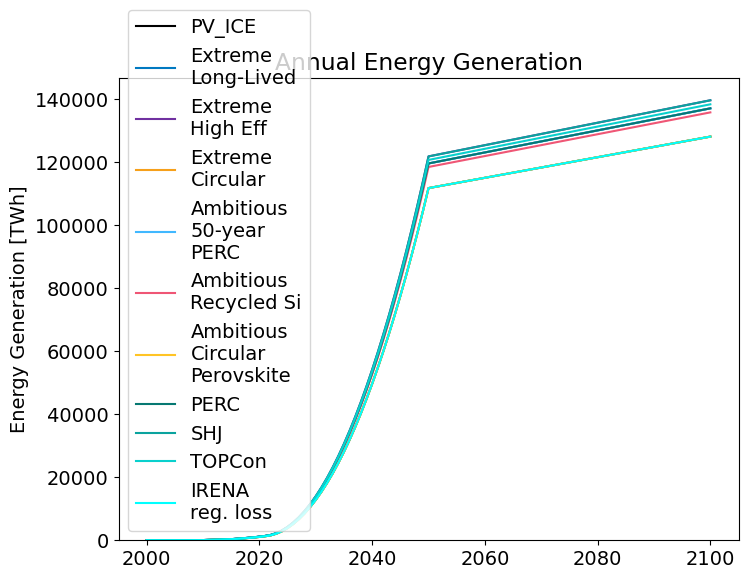

In [119]:
#energyGen = allenergy.filter(like='e_out_annual')
plt.plot(energyGen/1e12)
plt.legend(scennames_labels)
plt.title('Annual Energy Generation')
plt.ylabel('Energy Generation [TWh]')
plt.ylim(0,)

## Net Energy

In [120]:
e_annual_sumDemands = energy_demands.filter(like='demand_total')

(0.0, 6891.365215174994)

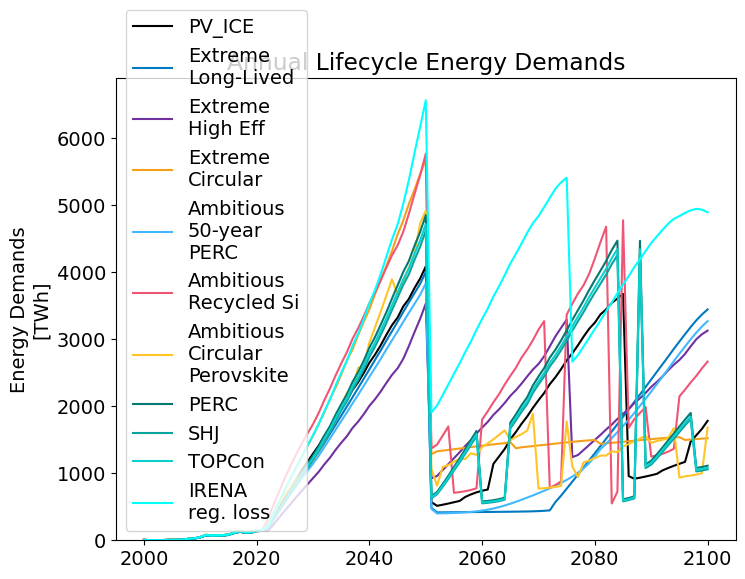

In [121]:
plt.plot(e_annual_sumDemands/1e12)
plt.legend(scennames_labels)
plt.title('Annual Lifecycle Energy Demands')
plt.ylabel('Energy Demands\n[TWh]')
plt.ylim(0,)

In [122]:
e_annual_sumDemands_cumu = e_annual_sumDemands.cumsum()

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 [Text(0.0, 0, 'PV_ICE'),
  Text(1.0, 0, 'Extreme\nLong-Lived'),
  Text(2.0, 0, 'Extreme\nHigh Eff'),
  Text(3.0, 0, 'Extreme\nCircular'),
  Text(4.0, 0, 'Ambitious\n50-year\nPERC'),
  Text(5.0, 0, 'Ambitious\nRecycled Si'),
  Text(6.0, 0, 'Ambitious\nCircular\nPerovskite'),
  Text(7.0, 0, 'PERC'),
  Text(8.0, 0, 'SHJ'),
  Text(9.0, 0, 'TOPCon'),
  Text(10.0, 0, 'IRENA\nreg. loss')])

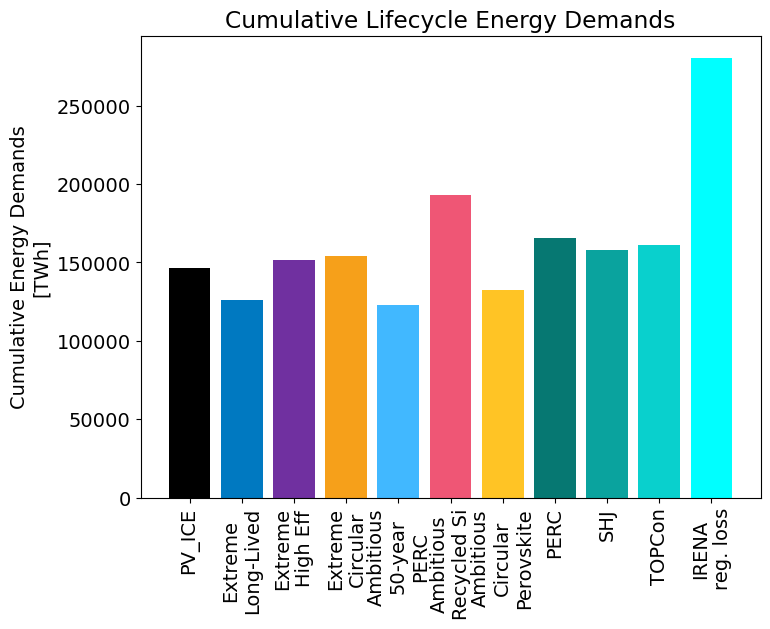

In [123]:
plt.bar(e_annual_sumDemands_cumu.columns, e_annual_sumDemands_cumu.loc[2100]/1e12, 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('Cumulative Lifecycle Energy Demands')
plt.ylabel('Cumulative Energy Demands\n[TWh]')
plt.xticks(rotation=90)

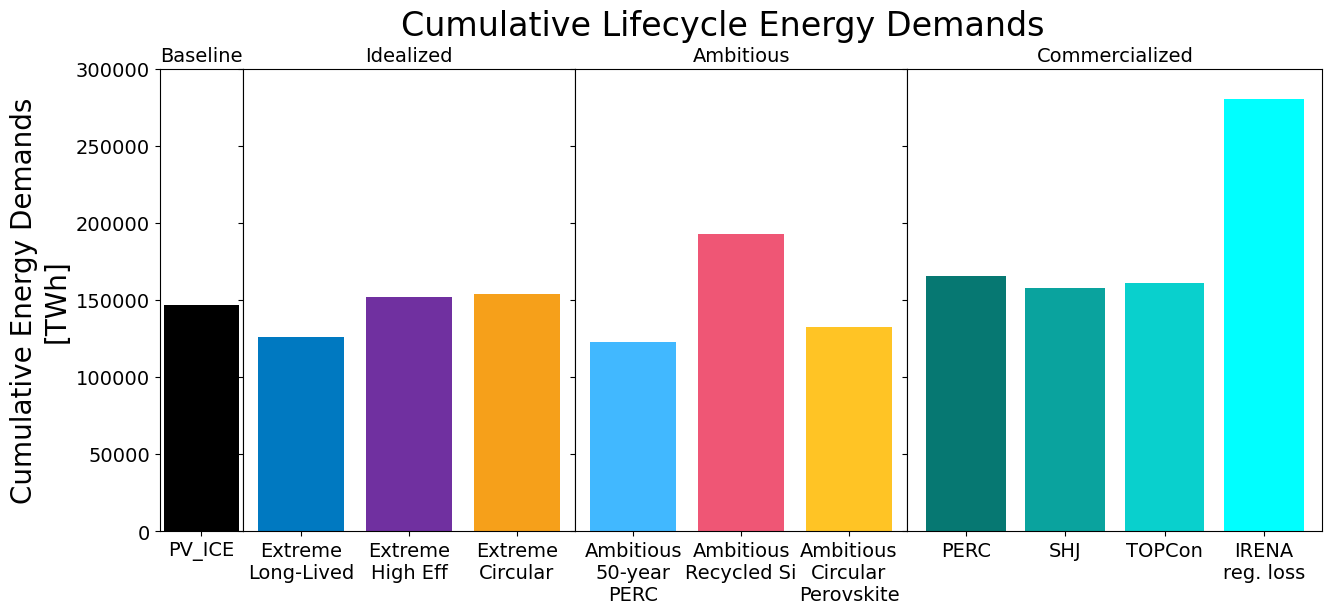

In [129]:
cumu_e_demands_twh = e_annual_sumDemands_cumu.loc[2100]/1e12

fig, (ax0,ax1,ax2,ax3) = plt.subplots(1,4,figsize=(15,6), sharey=True, 
                                      gridspec_kw={'wspace': 0, 'width_ratios': [0.5,2,2,2.5]})

ax0.bar(scennames_labels[0:1], cumu_e_demands_twh.iloc[0:1], width=0.1, 
        tick_label=scennames_labels[0:1], color=colorpalette[0:1])
ax0.set_ylim(0,300000)
ax0.set_ylabel('Cumulative Energy Demands\n[TWh]', fontsize=20)
ax0.set_title('Baseline', fontsize=14)

ax1.bar(scennames_labels[1:4], cumu_e_demands_twh.iloc[1:4], width=0.8, 
        tick_label=scennames_labels[1:4], color=colorpalette[1:4])
ax1.set_title('Idealized', fontsize=14)

ax2.bar(scennames_labels[4:7], cumu_e_demands_twh.iloc[4:7], width=0.8,
        tick_label=scennames_labels[4:7], color=colorpalette[4:7])
ax2.set_title('Ambitious', fontsize=14)

ax3.bar(scennames_labels[7:11], cumu_e_demands_twh.iloc[7:11], width=0.8,
        tick_label=scennames_labels[7:11], color=colorpalette[7:11])
ax3.set_title('Commercialized', fontsize=14)

fig.suptitle('Cumulative Lifecycle Energy Demands', fontsize=24)
plt.show()

fig.savefig('energyresults-energyDemands.png', dpi=300, bbox_inches='tight')

In [130]:
#select material demands that are not fuel
e_fuels = energy_demands.filter(like='_fuel')
e_energydemands = energy_demands.loc[:,~energy_demands.columns.isin(e_fuels.columns)]
#sum energy demands by material
e_mfging_bymat = pd.DataFrame()
for scen in sim1.scenario.keys():
    e_energy_mfg_scen = e_energydemands.filter(like=scen).filter(like='_MFG_')
    e_energy_mod_mfg_scen = energy_demands.filter(like=scen).filter(like='mod_MFG')
    e_mfging_bymat = pd.concat([e_mfging_bymat,e_energy_mfg_scen,e_energy_mod_mfg_scen], axis=1)

In [131]:
cum_e_mfging_bymat = e_mfging_bymat.cumsum().loc[2100]
cum_e_mfging_bymat

PV_ICE_glass_mat_MFG_virgin                2.830129e+16
PV_ICE_silicon_mat_MFG_virgin              6.254999e+16
PV_ICE_silver_mat_MFG_virgin               4.701355e+14
PV_ICE_aluminium_frames_mat_MFG_virgin     1.991850e+16
PV_ICE_copper_mat_MFG_virgin               9.871803e+13
                                               ...     
r_IRENA_aluminium_frames_mat_MFG_virgin    1.767499e+16
r_IRENA_copper_mat_MFG_virgin              1.609136e+14
r_IRENA_encapsulant_mat_MFG_virgin         3.576765e+15
r_IRENA_backsheet_mat_MFG_virgin           4.466692e+15
r_IRENA_mod_MFG                            4.250298e+15
Name: 2100, Length: 88, dtype: float64

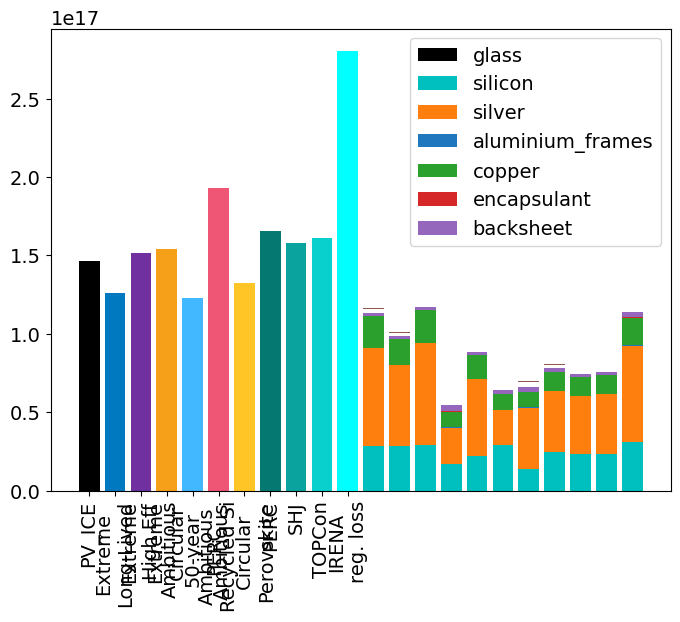

In [132]:
#run 2x rn??
#energy demands by material mfging
plt.bar(e_annual_sumDemands_cumu.columns, e_annual_sumDemands_cumu.loc[2100], 
        tick_label=(scennames_labels), color=colorpalette)

#Materials
cume_mfg_glass = cum_e_mfging_bymat.filter(like='glass')
cume_mfg_silicon = cum_e_mfging_bymat.filter(like='silicon')
cume_mfg_silver = cum_e_mfging_bymat.filter(like='silver')
cume_mfg_aluminium_frames = cum_e_mfging_bymat.filter(like='aluminium_frames')
cume_mfg_copper = cum_e_mfging_bymat.filter(like='copper')
cume_mfg_encapsulant = cum_e_mfging_bymat.filter(like='encapsulant')
cume_mfg_backsheet = cum_e_mfging_bymat.filter(like='backsheet')
cume_mfg_mod = cum_e_mfging_bymat.filter(like='mod')

bot_ag = cume_mfg_glass.values+cume_mfg_silicon.values
bot_al = cume_mfg_glass.values+cume_mfg_silicon.values+cume_mfg_silver.values
bot_cu = cume_mfg_glass.values+cume_mfg_silicon.values+cume_mfg_silver.values+cume_mfg_aluminium_frames.values
bot_encap = cume_mfg_glass.values+cume_mfg_silicon.values+cume_mfg_silver.values+cume_mfg_aluminium_frames.values+cume_mfg_copper.values
bot_back = cume_mfg_glass.values+cume_mfg_silicon.values+cume_mfg_silver.values+cume_mfg_aluminium_frames.values+cume_mfg_copper.values+cume_mfg_encapsulant.values
bot_mod = cume_mfg_glass.values+cume_mfg_silicon.values+cume_mfg_silver.values+cume_mfg_aluminium_frames.values+cume_mfg_copper.values+cume_mfg_encapsulant.values+cume_mfg_backsheet.values

plt.bar(scennames_labels, cume_mfg_glass, color = colormats[0])
plt.bar(scennames_labels, cume_mfg_silicon, bottom = cume_mfg_glass, color=colormats[1])
plt.bar(scennames_labels, cume_mfg_silver, bottom = bot_ag, color=colormats[2])
plt.bar(scennames_labels, cume_mfg_aluminium_frames, bottom = bot_al, color=colormats[3])
plt.bar(scennames_labels, cume_mfg_copper, bottom = bot_cu , color=colormats[4])
plt.bar(scennames_labels, cume_mfg_encapsulant, bottom = bot_encap ,color=colormats[5])
plt.bar(scennames_labels, cume_mfg_backsheet, bottom = bot_back, color=colormats[6])
plt.bar(scennames_labels, cume_mfg_mod, bottom = bot_back, color='white')

plt.xticks(rotation=90)

plt.legend(MATERIALS)

In [133]:
energyGen_cumu = energyGen.cumsum()
energyGen_cumu.columns = e_annual_sumDemands_cumu.columns = scennames_labels
netEnergy_cumu = energyGen_cumu.loc[[2100]] - e_annual_sumDemands_cumu.loc[[2100]]

In [134]:
e_annual_sumDemands_cumu.loc[[2100]]

PV_ICE  Extreme\nLong-Lived  Extreme\nHigh Eff  Extreme\nCircular  \
year                                                                            
2100  1.467254e+17         1.260461e+17       1.518354e+17       1.543491e+17   

      Ambitious\n50-year\nPERC  Ambitious\nRecycled Si  \
year                                                     
2100              1.230051e+17            1.927813e+17   

      Ambitious\nCircular\nPerovskite          PERC           SHJ  \
year                                                                
2100                     1.326062e+17  1.658780e+17  1.579555e+17   

            TOPCon  IRENA\nreg. loss  
year                                  
2100  1.612970e+17      2.804943e+17

In [135]:
netEnergy_cumu

PV_ICE  Extreme\nLong-Lived  Extreme\nHigh Eff  Extreme\nCircular  \
year                                                                            
2100  7.041304e+18         7.565146e+18       7.683117e+18       7.033681e+18   

      Ambitious\n50-year\nPERC  Ambitious\nRecycled Si  \
year                                                     
2100              7.568187e+18            7.426530e+18   

      Ambitious\nCircular\nPerovskite          PERC           SHJ  \
year                                                                
2100                     7.055423e+18  7.525314e+18  7.676997e+18   

            TOPCon  IRENA\nreg. loss  
year                                  
2100  7.601775e+18      6.907535e+18

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 [Text(0.0, 0, 'PV_ICE'),
  Text(1.0, 0, 'Extreme\nLong-Lived'),
  Text(2.0, 0, 'Extreme\nHigh Eff'),
  Text(3.0, 0, 'Extreme\nCircular'),
  Text(4.0, 0, 'Ambitious\n50-year\nPERC'),
  Text(5.0, 0, 'Ambitious\nRecycled Si'),
  Text(6.0, 0, 'Ambitious\nCircular\nPerovskite'),
  Text(7.0, 0, 'PERC'),
  Text(8.0, 0, 'SHJ'),
  Text(9.0, 0, 'TOPCon'),
  Text(10.0, 0, 'IRENA\nreg. loss')])

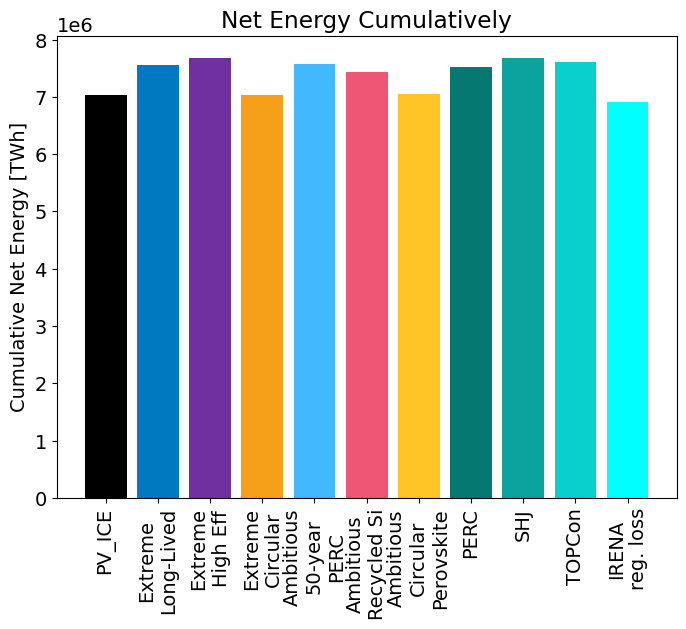

In [136]:
plt.bar(netEnergy_cumu.columns, netEnergy_cumu.loc[2100]/1e12, 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('Net Energy Cumulatively')
plt.ylabel('Cumulative Net Energy [TWh]')
#plt.ylim(4e6,5.5e6)
plt.xticks(rotation=90)

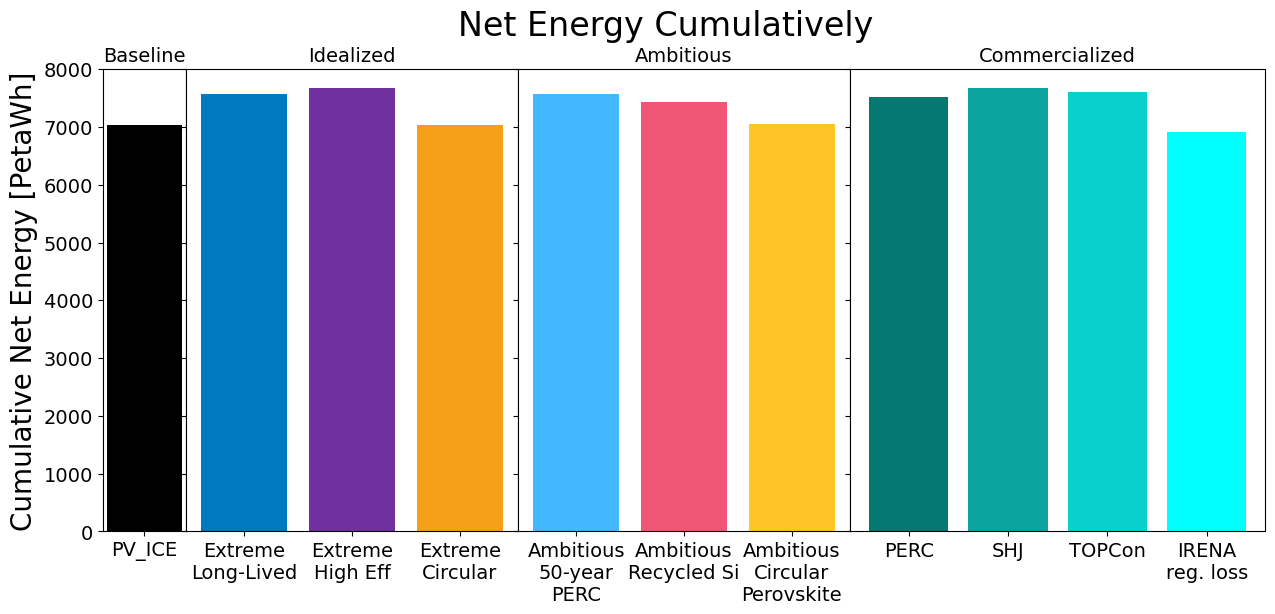

In [137]:
cumu_netEnergy_twh = netEnergy_cumu.loc[2100]/1e15

fig, (ax0,ax1,ax2,ax3) = plt.subplots(1,4,figsize=(15,6), sharey=True, 
                                      gridspec_kw={'wspace': 0, 'width_ratios': [0.5,2,2,2.5]})

ax0.bar(scennames_labels[0:1], cumu_netEnergy_twh.iloc[0:1], width=0.1, 
        tick_label=scennames_labels[0:1], color=colorpalette[0:1])
ax0.set_ylim(0,8000)
ax0.set_ylabel('Cumulative Net Energy [PetaWh]', fontsize=20)
ax0.set_title('Baseline', fontsize=14)

ax1.bar(scennames_labels[1:4], cumu_netEnergy_twh.iloc[1:4], width=0.8, 
        tick_label=scennames_labels[1:4], color=colorpalette[1:4])
ax1.set_title('Idealized', fontsize=14)

ax2.bar(scennames_labels[4:7], cumu_netEnergy_twh.iloc[4:7], width=0.8,
        tick_label=scennames_labels[4:7], color=colorpalette[4:7])
ax2.set_title('Ambitious', fontsize=14)

ax3.bar(scennames_labels[7:11], cumu_netEnergy_twh.iloc[7:11], width=0.8,
        tick_label=scennames_labels[7:11], color=colorpalette[7:11])
ax3.set_title('Commercialized', fontsize=14)

fig.suptitle('Net Energy Cumulatively', fontsize=24)
plt.show()

fig.savefig('energyresults-cumuNetEnergy.png', dpi=300, bbox_inches='tight')

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 [Text(0.0, 0, 'PV_ICE'),
  Text(1.0, 0, 'Extreme\nLong-Lived'),
  Text(2.0, 0, 'Extreme\nHigh Eff'),
  Text(3.0, 0, 'Extreme\nCircular'),
  Text(4.0, 0, 'Ambitious\n50-year\nPERC'),
  Text(5.0, 0, 'Ambitious\nRecycled Si'),
  Text(6.0, 0, 'Ambitious\nCircular\nPerovskite'),
  Text(7.0, 0, 'PERC'),
  Text(8.0, 0, 'SHJ'),
  Text(9.0, 0, 'TOPCon'),
  Text(10.0, 0, 'IRENA\nreg. loss')])

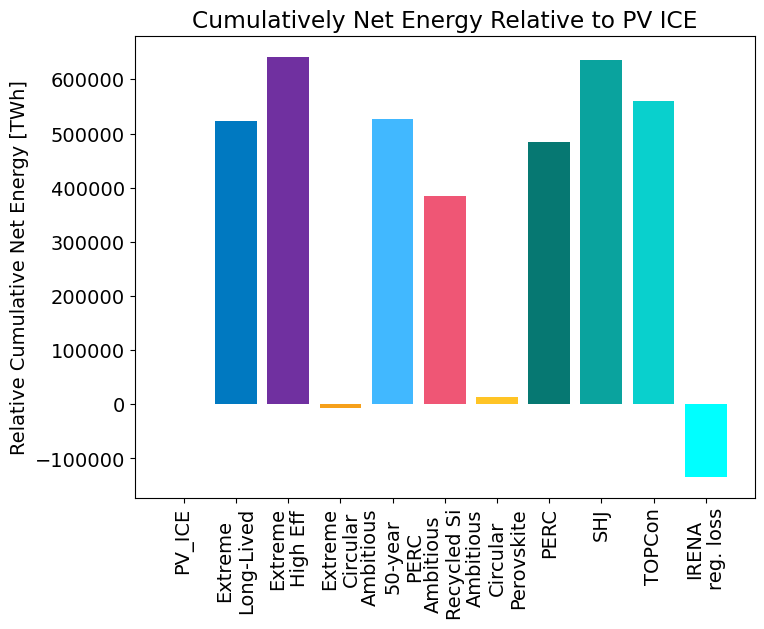

In [138]:
netEnergy_relative = netEnergy_cumu - netEnergy_cumu.loc[2100,'PV_ICE']
netEnergy_relative
plt.bar(netEnergy_relative.columns, netEnergy_relative.loc[2100]/1e12, 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('Cumulatively Net Energy Relative to PV ICE')
plt.ylabel('Relative Cumulative Net Energy [TWh]')
plt.xticks(rotation=90)

In [139]:
netEnergy_cumu_norm = netEnergy_cumu/netEnergy_cumu.loc[2100,'PV_ICE']
netEnergy_cumu_norm_waterfall = netEnergy_cumu_norm-1
netEnergy_cumu_norm


PV_ICE  Extreme\nLong-Lived  Extreme\nHigh Eff  Extreme\nCircular  \
year                                                                      
2100     1.0             1.074396            1.09115           0.998917   

      Ambitious\n50-year\nPERC  Ambitious\nRecycled Si  \
year                                                     
2100                  1.074827                1.054709   

      Ambitious\nCircular\nPerovskite      PERC       SHJ    TOPCon  \
year                                                                  
2100                         1.002005  1.068739  1.090281  1.079598   

      IRENA\nreg. loss  
year                    
2100          0.981002

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 [Text(0.0, 0, 'PV_ICE'),
  Text(1.0, 0, 'Extreme\nLong-Lived'),
  Text(2.0, 0, 'Extreme\nHigh Eff'),
  Text(3.0, 0, 'Extreme\nCircular'),
  Text(4.0, 0, 'Ambitious\n50-year\nPERC'),
  Text(5.0, 0, 'Ambitious\nRecycled Si'),
  Text(6.0, 0, 'Ambitious\nCircular\nPerovskite'),
  Text(7.0, 0, 'PERC'),
  Text(8.0, 0, 'SHJ'),
  Text(9.0, 0, 'TOPCon'),
  Text(10.0, 0, 'IRENA\nreg. loss')])

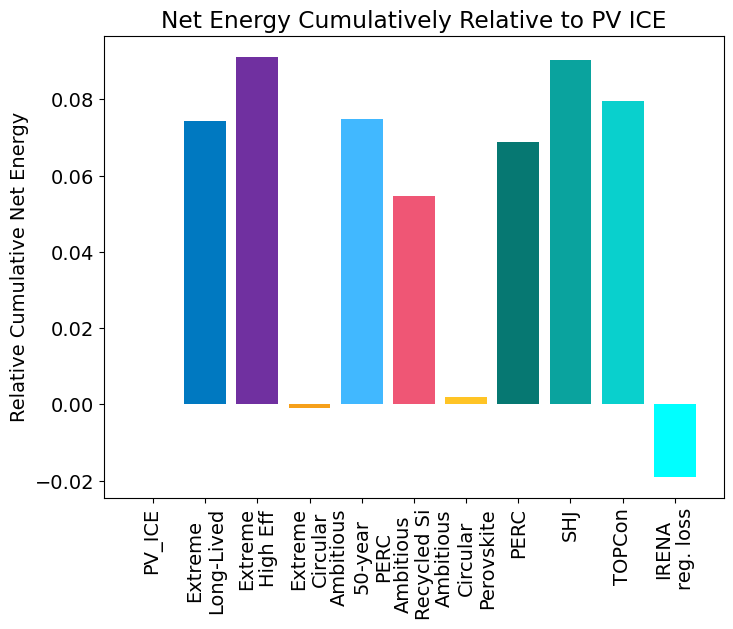

In [140]:
plt.bar(netEnergy_cumu.columns, netEnergy_cumu_norm_waterfall.loc[2100], 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('Net Energy Cumulatively Relative to PV ICE')
plt.ylabel('Relative Cumulative Net Energy')
#plt.ylim(-0.026,0.005)
plt.plot(0.0, lw=2)
plt.xticks(rotation=90)

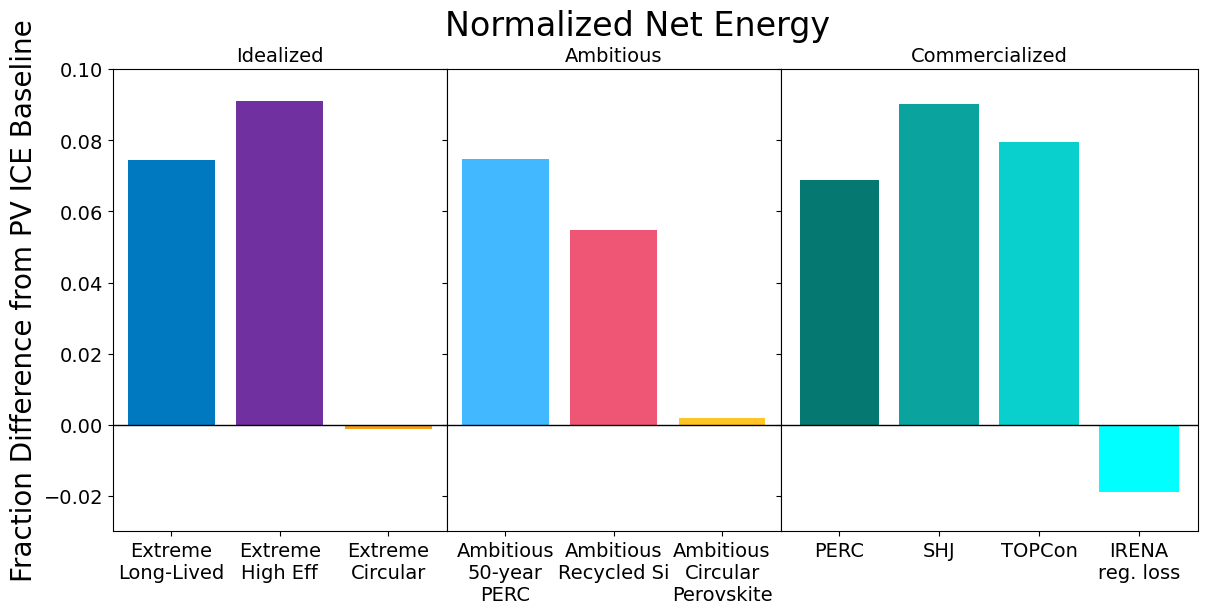

In [143]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,6), sharey=True, 
                                      gridspec_kw={'wspace': 0, 'width_ratios': [2,2,2.5]})

#ax0.bar(scennames_labels[0:1], netEnergy_cumu_norm_waterfall.iloc[-1,0:1], width=0.1, 
#        tick_label=scennames_labels[0:1], color=colorpalette[0:1])

#ax0.set_title('Baseline', fontsize=14)

ax1.bar(scennames_labels[1:4], netEnergy_cumu_norm_waterfall.iloc[-1,1:4], width=0.8, 
        tick_label=scennames_labels[1:4], color=colorpalette[1:4])
ax1.set_title('Idealized', fontsize=14)
ax1.set_ylim(-.03,.1)
ax1.set_ylabel('Fraction Difference from PV ICE Baseline', fontsize=20)
ax1.axhline(0, lw=1, color='black')

ax2.bar(scennames_labels[4:7], netEnergy_cumu_norm_waterfall.iloc[-1,4:7], width=0.8,
        tick_label=scennames_labels[4:7], color=colorpalette[4:7])
ax2.set_title('Ambitious', fontsize=14)
ax2.axhline(0, lw=1, color='black')

ax3.bar(scennames_labels[7:11], netEnergy_cumu_norm_waterfall.iloc[-1,7:11], width=0.8,
        tick_label=scennames_labels[7:11], color=colorpalette[7:11])
ax3.set_title('Commercialized', fontsize=14)
ax3.axhline(0, lw=1, color='black')

fig.suptitle('Normalized Net Energy', fontsize=24)
plt.show()

fig.savefig('energyresults-cumuNetEnergyNorm.png', dpi=300, bbox_inches='tight')

In [142]:
netenergy_final = netEnergy_cumu.loc[2100]/1e12

In [ ]:
plt.bar(netEnergy_cumu.columns, netEnergy_cumu.loc[2100]/1e12, 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('Net Energy Cumulatively')
plt.ylabel('Cumulative Net Energy\n[TWh]')
plt.xticks(rotation=90)

In [ ]:
energyGen.columns = e_annual_sumDemands.columns = scennames_labels
annual_net_energy = energyGen - e_annual_sumDemands

In [ ]:
plt.plot(annual_net_energy/1e12)
plt.legend(scennames_labels_flat)
plt.title('Annual Net Energy')
plt.ylabel('Net Energy (Eout - Ein)\n[TWh]')
plt.ylim(0,)
plt.xlim(2000,2100)

## Energy Balance
Inspired by EROI, this is all the energy generation divided by all the energy demanded for all systems deployed in energy transition. This is giving us an idea of our energy bang for energy buck

In [ ]:
energyBalance_allyears = energyGen_cumu/e_annual_sumDemands_cumu

In [ ]:
plt.bar(energyBalance_allyears.columns, energyBalance_allyears.loc[2100], 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('EROI of all Deployments')
plt.ylabel('Unitless')
plt.xticks(rotation=90)

In [ ]:
energyBalance = energyBalance_allyears.loc[2100]

fig, (ax0,ax1,ax2,ax3) = plt.subplots(1,4,figsize=(15,6), sharey=True, 
                                      gridspec_kw={'wspace': 0, 'width_ratios': [0.5,2,2,2.5]})

ax0.bar(scennames_labels[0:1], energyBalance.iloc[0:1], width=0.1, 
        tick_label=scennames_labels[0:1], color=colorpalette[0:1])
ax0.set_ylim(0,70)
ax0.set_ylabel('Unitless', fontsize=20)
ax0.set_title('Baseline', fontsize=14)

ax1.bar(scennames_labels[1:4], energyBalance.iloc[1:4], width=0.8, 
        tick_label=scennames_labels[1:4], color=colorpalette[1:4])
ax1.set_title('Idealized', fontsize=14)

ax2.bar(scennames_labels[4:7], energyBalance.iloc[4:7], width=0.8,
        tick_label=scennames_labels[4:7], color=colorpalette[4:7])
ax2.set_title('Ambitious', fontsize=14)

ax3.bar(scennames_labels[7:11], energyBalance.iloc[7:11], width=0.8,
        tick_label=scennames_labels[7:11], color=colorpalette[7:11])
ax3.set_title('Commercialized', fontsize=14)

fig.suptitle('Energy Balance', fontsize=24)
plt.show()

fig.savefig('energyresults-energyBalance.png', dpi=300, bbox_inches='tight')

### Discussion summary table

In [ ]:
discussTable = pd.concat([replacements,virgin,wastes, cumu_e_demands_twh,netenergy_final,energyBalance], axis=1,
         keys=['replacements','virgin','wastes','energydemand','netenergy','energybalance']).T
discussTable.to_csv(os.path.join(testfolder,'discussiontable.csv'))
discussTable

In [ ]:
cumu_lifecycle_wastes_bt